In [193]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import models

import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

import importlib
import utils.ml_utils as ml_utils
importlib.reload(ml_utils)

<module 'utils.ml_utils' from '/home/technoapurva_gmail_com/ml-experiments/utils/ml_utils.py'>

## Init seeds and env variables (makes training deterministic)

In [2]:
ml_utils.init_env()

## Helper Functions

In [47]:
def summarize_activations(stats_by_regularizer, model_state_by_regularizer, sample_batch):
    activation_by_regularizers = {}
    for key, model_state in model_state_by_regularizer.items():
        # Build model and load weights
        use_bn=True
        idx_n=32
        model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
        model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
        layer_outputs = [layer.output for layer in model.layers]
        activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

        activation_n = activation_model.predict(sample_batch[0], steps=1)[idx_n]

        activation_by_regularizers[key]=(activation_n, 
                                         sample_batch[1])

        activation_n_sum = np.sum(activation_n, axis=0)
        non_zero_activation_n = np.average(np.sum(activation_n>0, axis=1))
        average_activation_n = np.average(np.sum(abs(activation_n), axis=1))

        best_val_accuracy = np.max(model_state.history['val_accuracy'])
        best_val_loss = np.min(model_state.history['val_loss'])

        # Summarize activations
        print('Stats for {key} at convergence: '.format(key=key), stats_by_regularizer[key])
        print('Non-zero Activations Ln: {non_zero_activations}, Average Activation Ln: {average_activation}'.
             format(non_zero_activations=non_zero_activation_n, average_activation=average_activation_n))
        print('\n*********************************************************************\n')

In [113]:
def regularizer_printable_key(key, typ='dr'):
    for (k,(c,d)) in zip(['dr', 'l2', 'l1'], key):
        if typ==k:
            return 'conv_{k}={conv}, dense_{k}={dense}'.format(k=k, conv=c, dense=d)
        
def key_to_str(key):
    dropout = key[0]
    l2 = key[1]
    l1 = key[2]
    maxnorm = key[3]
    return 'dr={dropout}_l2={l2}_l1={l1}_maxnorm={maxnorm}'.format(**locals())

In [216]:
def visualize_activations(weights_path, layer_idx, sample_batch, title_key, model=None, show_plot=True, bins=100):
    if not model:
        model = ml_utils.build_model()
    model.load_weights(weights_path)#'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activation = activation_model.predict(sample_batch[0], steps=1)[layer_idx]

    activation_average = np.average(activation, axis=0)
    non_zero_activation_average = np.average(np.sum(activation>0, axis=1))
    activation_flat=np.ndarray.flatten(activation)
    
    if show_plot:
        plt.figure(figsize=(20, 7), dpi=80)
        plt.subplot(121)
        plt.title('Mean Activation: {}'.format(title_key))
        plt.hist(activation_average, bins=bins)

        plt.subplot(122)
        plt.title('Activation: {}'.format(title_key))
        plt.hist(np.ndarray.flatten(activation_flat), bins=bins)

        plt.show()
    
    print('Average no. of non zero activations across a mini batch: {}'.format(non_zero_activation_average))
    return np.average(np.sum(activation>0, axis=1))
    

In [156]:
def visualize_stats(stats):
    return pd.DataFrame(stats.values(), index=stats.keys(), 
                   columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'epochs']
                  ) 

## Read Data

In [4]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

# Read in training and validation data
train, validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_vs_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


In [5]:
sample_batch=validation.take(1)
np_sample_batch=sample_batch.as_numpy_iterator().next()

## Run All Regularizer Experiments
Apply dropout, L1 and L2 regularizations in dense layers only

In [6]:
model_state_by_regularizers = {}
#model_state_by_regularizers = ml_utils.load_model_state('regularization/model_state_by_regularizers')

In [226]:
regularizer_configs = [
    #((conv_dropout, dense_dropout), (conv_l2, dense_l2), (conv_l1, dense_l1), (conv_maxnorm, dense_maxnorm))
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0.2), (0,0), (0,0), (0,0)),
    ((0,0.4), (0,0), (0,0), (0,0)),
    ((0,0.6), (0,0), (0,0), (0,0)),
    ((0,0.8), (0,0), (0,0), (0,0)),
    ((0.1,0.2), (0,0), (0,0), (0,0)),
    ((0.1,0.4), (0,0), (0,0), (0,0)),
    ((0.1,0.6), (0,0), (0,0), (0,0)),
    ((0.2,0.2), (0,0), (0,0), (0,0)),
    ((0.2,0.4), (0,0), (0,0), (0,0)),
    ((0.2,0.5), (0,0), (0,0), (0,0)),
    ((0.2,0.6), (0,0), (0,0), (0,0)),
    ((0.3,0.2), (0,0), (0,0), (0,0)),
    ((0.3,0.4), (0,0), (0,0), (0,0)),
    ((0.3,0.6), (0,0), (0,0), (0,0)),
    ((0,0), (0,0.0001), (0,0), (0,0)),
    ((0,0), (0,0.001), (0,0), (0,0)),
    ((0,0), (0,0.01), (0,0), (0,0)),
    ((0,0), (0,0.1), (0,0), (0,0)),
    ((0,0), (0,1), (0,0), (0,0)),
    ((0,0), (0.001,0.1), (0,0), (0,0)),
    ((0,0), (0.01,0.1), (0,0), (0,0)),
    ((0,0), (0.02,0.1), (0,0), (0,0)),
    ((0,0), (0.1,0.1), (0,0), (0,0)),
    ((0,0), (0,0), (0,0.00001), (0,0)),
    ((0,0), (0,0), (0,0.0001), (0,0)),
    ((0,0), (0,0), (0,0.001), (0,0)),
    ((0,0), (0,0), (0,0.01), (0,0)),
    ((0,0), (0,0), (0.00001,0.01), (0,0)),
    ((0,0), (0,0), (0.0001,0.01), (0,0)),
    ((0,0), (0,0), (0.001,0.01), (0,0)),
    ((0,0), (0,0), (0.01,0.01), (0,0)),
    ((0,0), (0,0), (0.002,0.01), (0,0)),
]

for regularizer_config in regularizer_configs:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    maxnorm = regularizer_config[3]
    key = 'dr={dropout}_l2={l2}_l1={l1}_maxnorm={maxnorm}'.format(**locals())
    print('Processing: ', key)
    
    if key in model_state_by_regularizers:
        continue
    
    # Build and train model
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
    model = ml_utils.build_model(
        conv_dropout_rate=dropout[0],
        dense_dropout_rate=dropout[1],
        conv_l2_regularizer=l2[0],
        dense_l2_regularizer=l2[1],
        conv_l1_regularizer=l1[0],
        dense_l1_regularizer=l1[1],
        conv_kernel_constraint=keras.constraints.max_norm(maxnorm[0]) if maxnorm[0]>0 else None,
        dense_kernel_constraint=keras.constraints.max_norm(maxnorm[1]) if maxnorm[1]>0 else None,
        optimizer=optimizer
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    model_state_by_regularizers[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Processing:  dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0, 0.8)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.1, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.1, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.1, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.2, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.2, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.2, 0.5)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.3, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.3, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0.3, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0, 0)_l2=(0, 0.0001)_l1=(0, 0)_maxnorm=(0, 0)
Processing:  dr=(0,

581/582 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.8944
Epoch 00020: val_loss improved from 0.57394 to 0.57211, saving model to pickled_objects/regularization/regularizers_dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0)_best_weights.h5
582/582 [==============================] - 8s 14ms/step - loss: 0.4952 - accuracy: 0.8944 - val_loss: 0.5721 - val_accuracy: 0.8465
Epoch 21/1000
581/582 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8938
Epoch 00021: val_loss did not improve from 0.57211
582/582 [==============================] - 8s 14ms/step - loss: 0.4931 - accuracy: 0.8938 - val_loss: 0.5830 - val_accuracy: 0.8459
Epoch 22/1000
578/582 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.8960
Epoch 00022: val_loss did not improve from 0.57211
582/582 [==============================] - 8s 14ms/step - loss: 0.4940 - accuracy: 0.8959 - val_loss: 0.6527 - val_accuracy: 0.8194
Epoch 23/1000
577/582 [==============

580/582 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.9109
Epoch 00047: val_loss did not improve from 0.53207
582/582 [==============================] - 8s 14ms/step - loss: 0.4721 - accuracy: 0.9110 - val_loss: 0.5425 - val_accuracy: 0.8697
Epoch 48/1000
580/582 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.9102
Epoch 00048: val_loss did not improve from 0.53207
582/582 [==============================] - 8s 14ms/step - loss: 0.4737 - accuracy: 0.9102 - val_loss: 0.5533 - val_accuracy: 0.8652
Epoch 49/1000
577/582 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.9055
Epoch 00049: val_loss did not improve from 0.53207
582/582 [==============================] - 8s 14ms/step - loss: 0.4793 - accuracy: 0.9056 - val_loss: 0.5923 - val_accuracy: 0.8495
Epoch 50/1000
581/582 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.9104
Epoch 00050: val_loss did not improve from 0.53207
582/582 [=========

Epoch 76/1000
577/582 [============================>.] - ETA: 0s - loss: 0.4644 - accuracy: 0.9157
Epoch 00076: val_loss did not improve from 0.53105
582/582 [==============================] - 8s 14ms/step - loss: 0.4639 - accuracy: 0.9160 - val_loss: 0.5980 - val_accuracy: 0.8536
Epoch 77/1000
580/582 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.9143
Epoch 00077: val_loss improved from 0.53105 to 0.52137, saving model to pickled_objects/regularization/regularizers_dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0)_best_weights.h5
582/582 [==============================] - 8s 14ms/step - loss: 0.4638 - accuracy: 0.9144 - val_loss: 0.5214 - val_accuracy: 0.8880
Epoch 78/1000
581/582 [============================>.] - ETA: 0s - loss: 0.4605 - accuracy: 0.9127
Epoch 00078: val_loss did not improve from 0.52137
582/582 [==============================] - 8s 14ms/step - loss: 0.4606 - accuracy: 0.9126 - val_loss: 0.5971 - val_accuracy: 0.8442
Epoch 79/1000
581/582 [

Epoch 105/1000
578/582 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.9154
Epoch 00105: val_loss did not improve from 0.52137
582/582 [==============================] - 8s 14ms/step - loss: 0.4556 - accuracy: 0.9153 - val_loss: 0.6559 - val_accuracy: 0.8136
Epoch 106/1000
578/582 [============================>.] - ETA: 0s - loss: 0.4486 - accuracy: 0.9208
Epoch 00106: val_loss did not improve from 0.52137
582/582 [==============================] - 8s 14ms/step - loss: 0.4488 - accuracy: 0.9206 - val_loss: 0.8023 - val_accuracy: 0.7666
Epoch 107/1000
579/582 [============================>.] - ETA: 0s - loss: 0.4514 - accuracy: 0.9166
Epoch 00107: val_loss did not improve from 0.52137
582/582 [==============================] - 8s 14ms/step - loss: 0.4513 - accuracy: 0.9169 - val_loss: 0.5706 - val_accuracy: 0.8598
Epoch 108/1000
581/582 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.9178
Epoch 00108: val_loss did not improve from 0.52137


In [227]:
stats_by_regularizer={}
for key,model_state in model_state_by_regularizers.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats['epochs']=best_epoch
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Stats for dr=(0, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3260412749057172, 'val_loss': 0.39938245295253516, 'train_accuracy': 0.85593766, 'val_accuracy': 0.8237317, 'epochs': 10}
Stats for dr=(0, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3256726132989058, 'val_loss': 0.36196453063047096, 'train_accuracy': 0.8575497, 'val_accuracy': 0.84200346, 'epochs': 19}
Stats for dr=(0, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.2773638262151711, 'val_loss': 0.35707019565448367, 'train_accuracy': 0.8821064, 'val_accuracy': 0.85361135, 'epochs': 44}
Stats for dr=(0, 0.8)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.28069385567831134, 'val_loss': 0.31935675391187407, 'train_a

In [278]:
ml_utils.save_model_state(model_state_by_regularizers, 'regularization/model_state_by_regularizers_new')

In [242]:
model_state_by_regularizers.keys()

dict_keys(['dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0.8)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.1, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.1, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.1, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.2, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.2, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.3, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.3, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.3, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0)_l2=(0, 0.0001)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0)_l2=(0, 0.001)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0)_l2=(0, 0.01)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0)_l2=(0, 0.1)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0, 0)_l2=(0, 1)_l1=(0, 0)_maxnorm=(0, 0)', 'dr=(0.2, 0.5)_l2=(

## Regularizers
We are going to compare the following regularization techniques in this notebook:
    1. Dropout
    2. L2 Regularization
    3. L1 Regularization
    4. Batch Normalization

### 1. Dropout
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

In [108]:
model_state_by_dropout={}
dropout_key={}
for regularizer_config in [ # dense(dropout, l2, l1)
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0.6), (0,0), (0,0), (0,0)),
    ((0,0.8), (0,0), (0,0), (0,0)),
    ((0.1,0.6), (0,0), (0,0), (0,0)),
    ((0.2,0.6), (0,0), (0,0), (0,0)),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    maxnorm = regularizer_config[3]
    key = 'dr={dropout}_l2={l2}_l1={l1}_maxnorm={maxnorm}'.format(**locals())
    dropout_key[key]='conv_dr={conv}, dense_dr={dense}'.format(conv=dropout[0], dense=dropout[1])
    
    model_state_by_dropout[key] = model_state_by_regularizers[key]

In [17]:
dropout_by_key={dropout_key[k]:v for k,v in model_state_by_dropout.items()}

#### Summarize Results
We observed around 3.5% accuracy gain as a result of applying dropout. It also closed the generalization gap between train and test loss. The best loss value was: 0.3443 when dropout was set at 0.7

In [18]:
stats_by_dropout={}
for key,model_state in model_state_by_dropout.items():
    stats_by_dropout[dropout_key[key]]=stats_by_regularizer[key]
    print('Stats for {key} at convergence: '.format(key=key), stats_by_regularizer[key])
    
    

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Stats for dr=(0, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.2773638262151711, 'val_loss': 0.35707019565448367, 'train_accuracy': 0.8821064, 'val_accuracy': 0.85361135, 'epochs': 44}
Stats for dr=(0, 0.8)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.28069385567831134, 'val_loss': 0.31935675391187407, 'train_accuracy': 0.8807093, 'val_accuracy': 0.8662941, 'epochs': 82}
Stats for dr=(0.1, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.20076011766643054, 'val_loss': 0.22893304602332312, 'train_accuracy': 0.9186459, 'val_accuracy': 0.90434223, 'epochs': 257}
Stats for dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.23773994095411305, 'val_loss': 0.19532792321214937, 't

In [19]:
df1 = pd.DataFrame(stats_by_dropout.values(), index=stats_by_dropout.keys(), 
                   columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'epochs']
                  ) 
df1

train_loss  val_loss  train_accuracy  val_accuracy  \
conv_dr=0, dense_dr=0        0.361213  0.474447        0.844277      0.779665   
conv_dr=0, dense_dr=0.6      0.277364  0.357070        0.882106      0.853611   
conv_dr=0, dense_dr=0.8      0.280694  0.319357        0.880709      0.866294   
conv_dr=0.1, dense_dr=0.6    0.200760  0.228933        0.918646      0.904342   
conv_dr=0.2, dense_dr=0.6    0.237740  0.195328        0.901451      0.918960   

                           epochs  
conv_dr=0, dense_dr=0           3  
conv_dr=0, dense_dr=0.6        44  
conv_dr=0, dense_dr=0.8        82  
conv_dr=0.1, dense_dr=0.6     257  
conv_dr=0.2, dense_dr=0.6     485

#### Loss

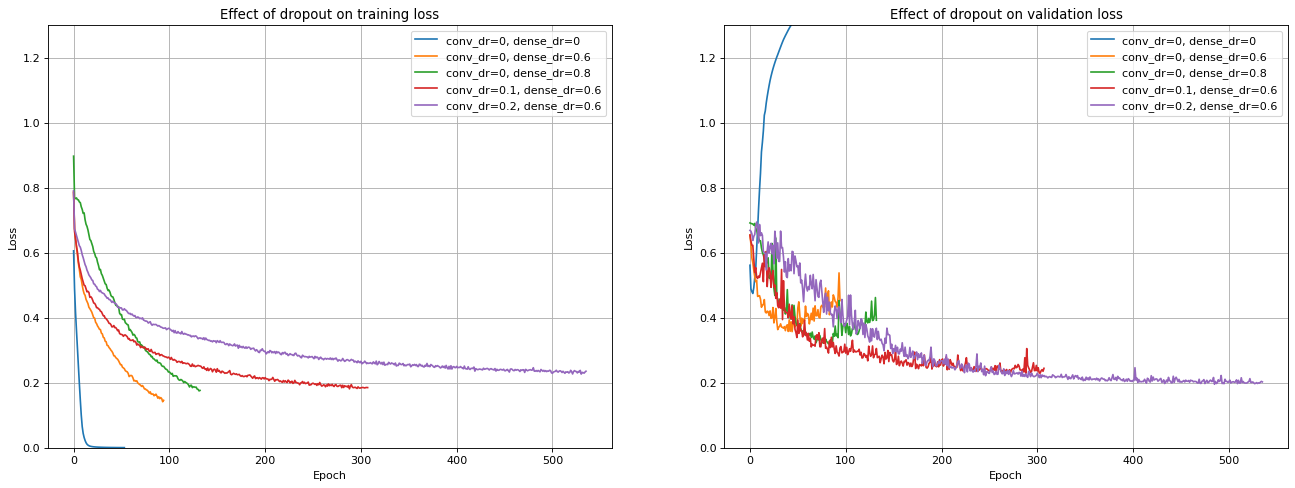

<Figure size 432x288 with 0 Axes>

In [23]:
ml_utils.plot_loss_by_param(dropout_by_key, 'dropout', 'dropout_loss', ylim_left=0, ylim_right=1.3)

#### Accuracy

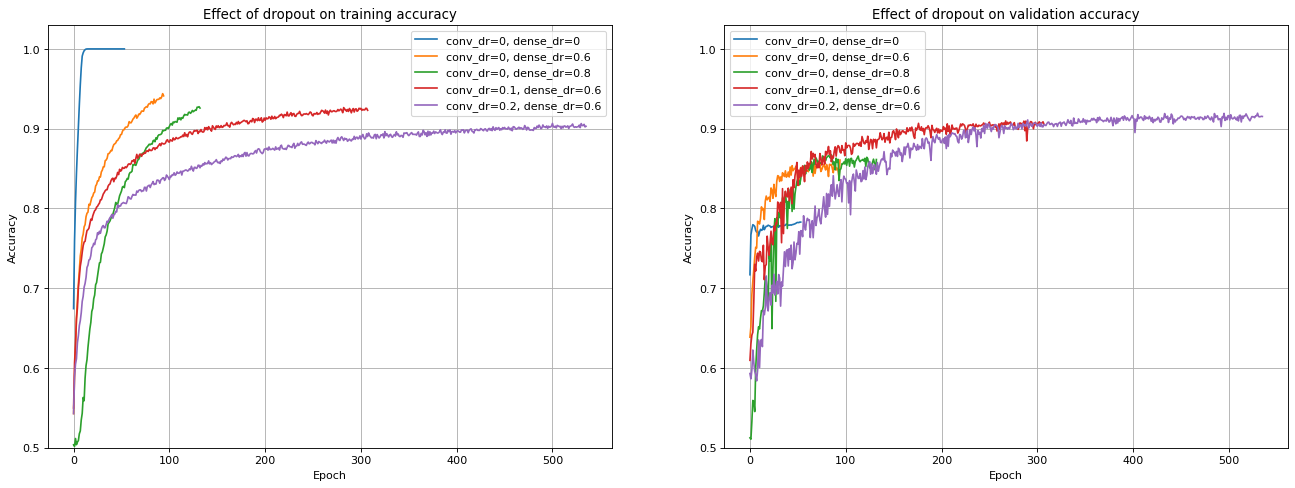

<Figure size 432x288 with 0 Axes>

In [21]:
ml_utils.plot_accuracies_by_param(dropout_by_key, 'dropout', 'dropout_accuracy', ylim_right=1.03, ylim_left=0.5)

#### Generalization Gap
Generalization gap is defined as the ratio of validation loss and training loss. The idea value for this is 1. For the ease of visualization we have clipped this value at 5. As we can see that the generalization gap becomes better as we increase the dropout rate.

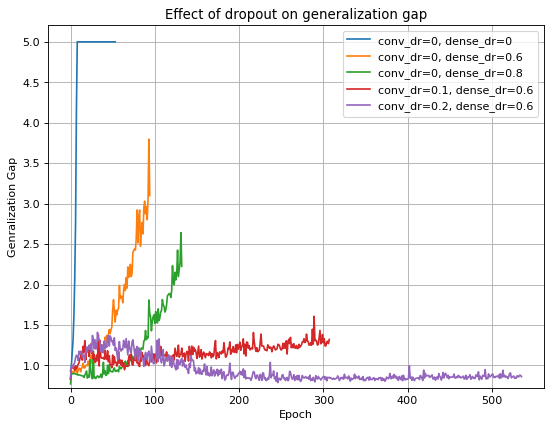

In [22]:
ml_utils.plot_generalization_gap_by_param(dropout_by_key, 'dropout', 'dropout_gen_gap', 5)

#### Weight Visualization
Dropout doesn't have an effect on weights distribution

In [28]:
print(len(model.get_weights()))
for w in model.get_weights():
    print(np.shape(w))

44
(3,)
(3,)
(3,)
(3,)
(3, 3, 3, 4)
(4,)
(4,)
(4,)
(4,)
(4,)
(3, 3, 4, 8)
(8,)
(8,)
(8,)
(8,)
(8,)
(3, 3, 8, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(3, 3, 16, 32)
(32,)
(32,)
(32,)
(32,)
(32,)
(3, 3, 32, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(1024, 256)
(256,)
(256,)
(256,)
(256,)
(256,)
(256, 256)
(256,)
(256, 1)
(1,)


Model: conv_dr=0, dense_dr=0, Max Weight: 0.19702987372875214, Min Weight: 0.19702987372875214, Weight Mean Square: 0.009070958010852337
Model: conv_dr=0.2, dense_dr=0.6, Max Weight: 0.05851571261882782, Min Weight: 0.05851571261882782, Weight Mean Square: 0.0006487532518804073
Model: conv_dr=0, dense_dr=0, Max Weight: 0.11880972236394882, Min Weight: 0.11880972236394882, Weight Mean Square: 0.003912077751010656
Model: conv_dr=0.2, dense_dr=0.6, Max Weight: 0.26504892110824585, Min Weight: 0.26504892110824585, Weight Mean Square: 0.003246110398322344
Model: conv_dr=0, dense_dr=0, Max Weight: 0.10001704841852188, Min Weight: 0.10001704841852188, Weight Mean Square: 0.0015703312819823623
Model: conv_dr=0.2, dense_dr=0.6, Max Weight: 0.13394947350025177, Min Weight: 0.13394947350025177, Weight Mean Square: 0.0016501503996551037
Model: conv_dr=0, dense_dr=0, Max Weight: 0.1375252902507782, Min Weight: 0.1375252902507782, Weight Mean Square: 0.0023956038057804108
Model: conv_dr=0.2, dense_d

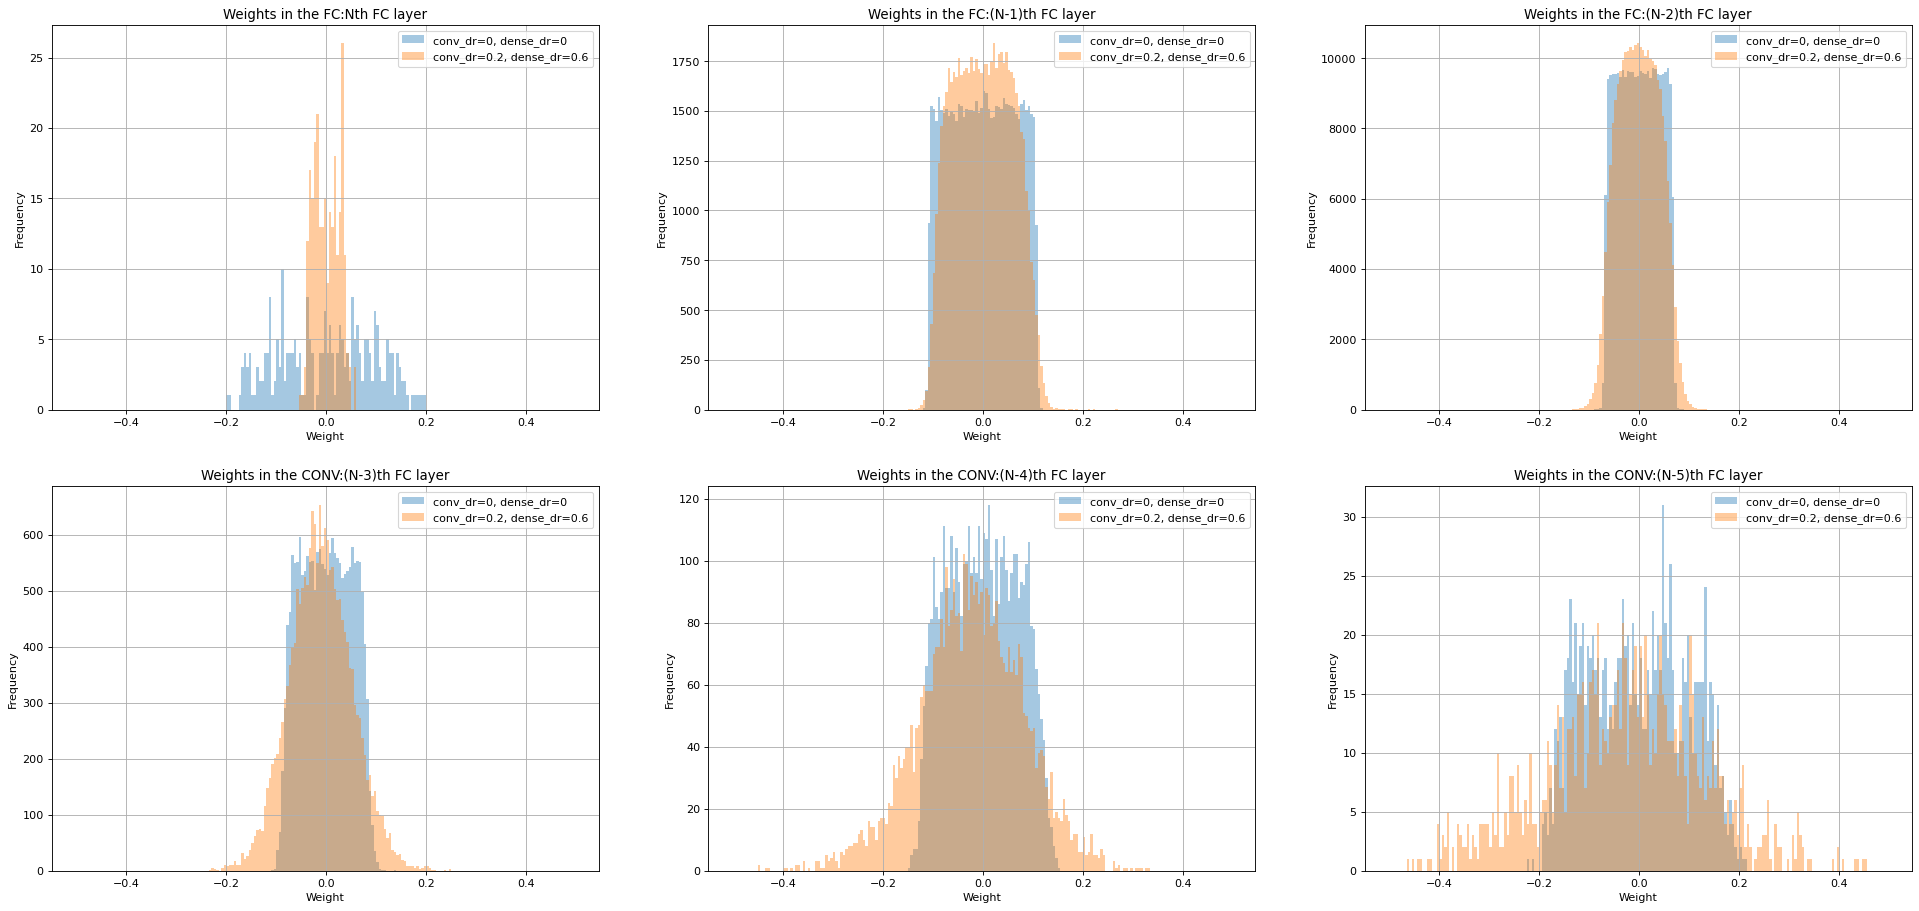

In [80]:
plt.figure(figsize=(30, 14), dpi=80)
for (weight_index, subplot, param) in [(42,231, 'FC:N'), (40,232, 'FC:(N-1)'), (34,233, 'FC:(N-2)'), 
                                      (28,234, 'CONV:(N-3)'), (22,235, 'CONV:(N-4)'), (16,236, 'CONV:(N-5)'),]:
    plt.subplot(subplot)
    plt.title('Weights in the {}th FC layer'.format(param))
    
    model_weights_by_regularizers = {}
    for key in model_state_by_dropout.keys():
        if key not in 'dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)' \
            and key not in 'dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)':
            continue
        model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0)
        model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
        model_weights_by_regularizers[dropout_key[key]] = model.get_weights()[weight_index]

    ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_dropout')

In [70]:
np.sum(np.power([1, 2], 2))

5

#### Activation Visualization
As we increase the droput, the no. of nodes with zero activations across all layers go up. The average activation value however didn't change much.

In [81]:
len(model.layers)

35

In [34]:
model.layers

In [124]:
non_zero_activations_by_dropout={}
for key in [
    ((0,0), (0,0), (0,0), (0,0)),
    ((0.2,0.2), (0,0), (0,0), (0,0)),
    ((0.2,0.4), (0,0), (0,0), (0,0)),
    ((0.2,0.6), (0,0), (0,0), (0,0)),
]:
    weights_path='pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key_to_str(key))
    dr_key=regularizer_printable_key(key, typ='dr')
    print(key_to_str(key))
    non_zero_activations_by_dropout[dr_key]=visualize_activations(
        weights_path, 32, np_sample_batch, dr_key, show_plot=False)
    
    
plt.title('Effect of dropout on sparsity')
plt.barh(
    list(non_zero_activations_by_dropout.keys()), 
    list(non_zero_activations_by_dropout.values()))
plt.xlabel('Non-zero activations in last FC layer')   

dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Average no. of non zero activations across a mini batch: 127.59375
dr=(0.2, 0.2)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Average no. of non zero activations across a mini batch: 124.15625
dr=(0.2, 0.4)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Average no. of non zero activations across a mini batch: 115.28125
dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
Average no. of non zero activations across a mini batch: 113.6875


Text(0.5, 0, 'Non-zero activations in last FC layer')

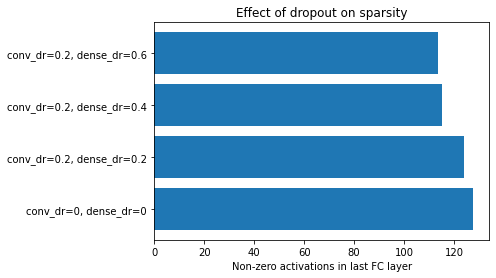

In [134]:
plt.title('Effect of dropout on sparsity')
plt.barh(
    list(non_zero_activations_by_dropout.keys()), 
    list(non_zero_activations_by_dropout.values()))
plt.xlabel('Non-zero activations in last FC layer')

In [146]:
model.layers

In [48]:
summarize_activations(stats_by_regularizer, model_state_by_dropout, np_sample_batch)

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Non-zero Activations L(n-1): 127.59375, Average Activation L(n-1): 103.25991821289062
Non-zero Activations Ln: 127.59375, Average Activation Ln: 103.25991821289062

*********************************************************************

Stats for dr=(0, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.2773638262151711, 'val_loss': 0.35707019565448367, 'train_accuracy': 0.8821064, 'val_accuracy': 0.85361135, 'epochs': 44}
Non-zero Activations L(n-1): 121.125, Average Activation L(n-1): 162.69891357421875
Non-zero Activations Ln: 121.125, Average Activation Ln: 162.69891357421875

*********************************************************************

Stats for dr=(0, 0.8)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.28069385567831134,

### 2. L2 Regularization

In [233]:
model_state_by_l2={}
l2_key={}
for regularizer_config in [ # dense(dropout, l2, l1)
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0,0.1), (0,0), (0,0)),
    ((0,0), (0.001,0.1), (0,0), (0,0)),
    ((0,0), (0.01,0.1), (0,0), (0,0)),
    ((0,0), (0.02,0.1), (0,0), (0,0)),
]:
    # Read config from regularizer_config
    key = key_to_str(regularizer_config)
    l2_key[key]=regularizer_printable_key(regularizer_config, 'l2')
    if key in model_state_by_regularizers:
        model_state_by_l2[key] = model_state_by_regularizers[key] 

l2_by_key={l2_key[k]:v for k,v in model_state_by_l2.items()}

#### Summarize Results
Surprisingly L2 Regularization didn't help increase validation accuracy a lot. 

In [234]:
stats_by_l2={}
for key,model_state in model_state_by_l2.items():
    stats_by_l2[l2_key[key]]=stats_by_regularizer[key]
    print('Stats for {key} at convergence: '.format(key=key), stats_by_regularizer[key])
    
    

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Stats for dr=(0, 0)_l2=(0, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.4782408247866469, 'val_loss': 0.5302939139408608, 'train_accuracy': 0.82788825, 'val_accuracy': 0.7970765, 'epochs': 6}
Stats for dr=(0, 0)_l2=(0.001, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.555219338280997, 'val_loss': 0.5788839455336741, 'train_accuracy': 0.8252552, 'val_accuracy': 0.811264, 'epochs': 6}
Stats for dr=(0, 0)_l2=(0.01, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.41262125944591604, 'val_loss': 0.5441187722225712, 'train_accuracy': 0.9396024, 'val_accuracy': 0.8757524, 'epochs': 118}
Stats for dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.46376436874470617, 'val_loss': 0.5213706871009853, 'train

In [235]:
visualize_stats(stats_by_l2)

train_loss  val_loss  train_accuracy  \
conv_l2=0, dense_l2=0          0.361213  0.474447        0.844277   
conv_l2=0, dense_l2=0.1        0.478241  0.530294        0.827888   
conv_l2=0.001, dense_l2=0.1    0.555219  0.578884        0.825255   
conv_l2=0.01, dense_l2=0.1     0.412621  0.544119        0.939602   
conv_l2=0.02, dense_l2=0.1     0.463764  0.521371        0.914401   

                             val_accuracy  epochs  
conv_l2=0, dense_l2=0            0.779665       3  
conv_l2=0, dense_l2=0.1          0.797077       6  
conv_l2=0.001, dense_l2=0.1      0.811264       6  
conv_l2=0.01, dense_l2=0.1       0.875752     118  
conv_l2=0.02, dense_l2=0.1       0.888005      76

#### Loss

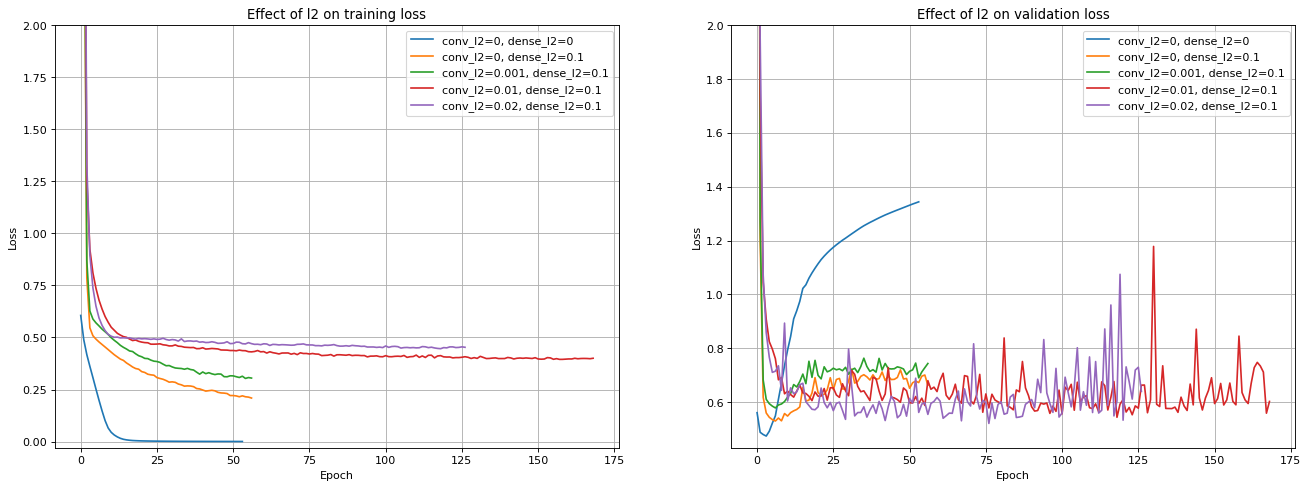

<Figure size 432x288 with 0 Axes>

In [236]:
ml_utils.plot_loss_by_param(l2_by_key, 'l2', 'l2_loss', ylim_right=2)

#### Accuracy

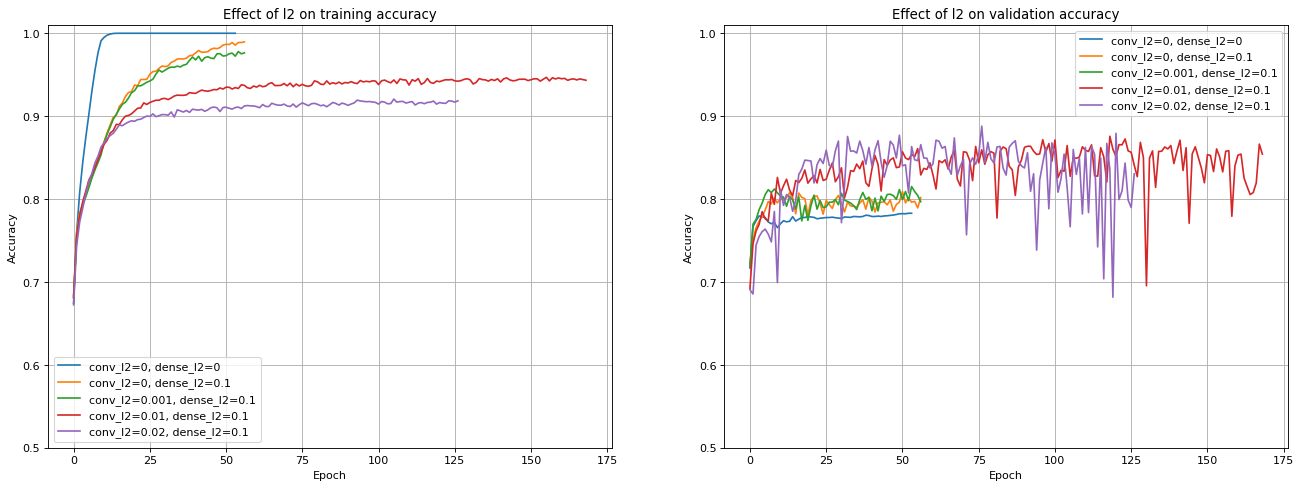

<Figure size 432x288 with 0 Axes>

In [237]:
ml_utils.plot_accuracies_by_param(l2_by_key, 'l2', 'l2_accuracy', ylim_left=0.5, ylim_right=1.01)

#### Generalization Gap

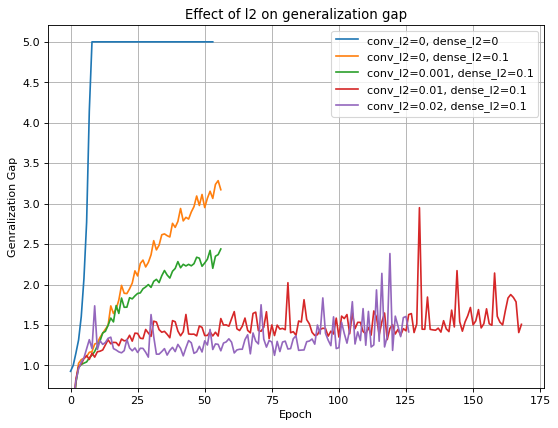

In [238]:
ml_utils.plot_generalization_gap_by_param(l2_by_key, 'l2', 'l2_gen_gap', 5)

#### Weight Visualization
Weights are distributed by guassian as a result of applying L2 norm. The standard deviation reduces as we increase the l2 regularization scalar.

Model: conv_l2=0, dense_l2=0, Max Weight: 0.19702987372875214, Min Weight: 0.19702987372875214, Weight Mean Square: 0.009070958010852337
Model: conv_l2=0.02, dense_l2=0.1, Max Weight: 0.09618420898914337, Min Weight: 0.09618420898914337, Weight Mean Square: 0.0014816634356975555
Model: conv_l2=0, dense_l2=0, Max Weight: 0.11880972236394882, Min Weight: 0.11880972236394882, Weight Mean Square: 0.003912077751010656
Model: conv_l2=0.02, dense_l2=0.1, Max Weight: 0.005407965742051601, Min Weight: 0.005407965742051601, Weight Mean Square: 5.752602191932965e-06
Model: conv_l2=0, dense_l2=0, Max Weight: 0.10001704841852188, Min Weight: 0.10001704841852188, Weight Mean Square: 0.0015703312819823623
Model: conv_l2=0.02, dense_l2=0.1, Max Weight: 0.003670585108920932, Min Weight: 0.003670585108920932, Weight Mean Square: 1.0078356353915296e-06
Model: conv_l2=0, dense_l2=0, Max Weight: 0.1375252902507782, Min Weight: 0.1375252902507782, Weight Mean Square: 0.0023956038057804108
Model: conv_l2=0.0

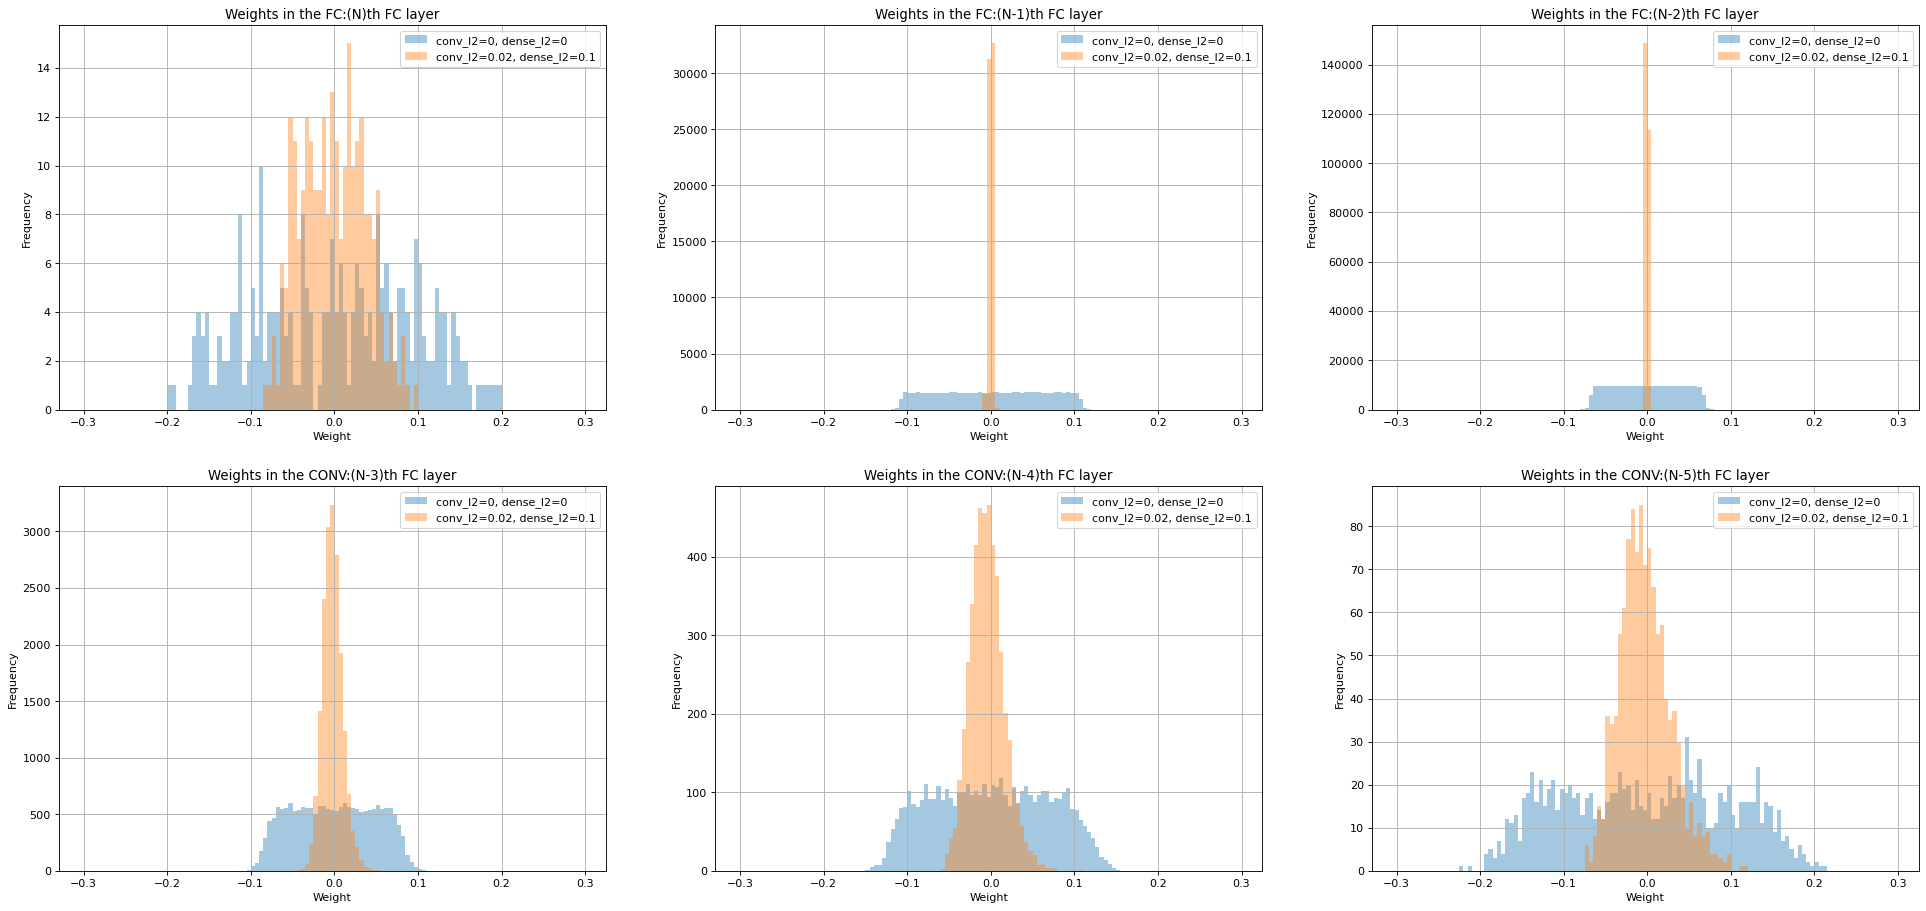

In [239]:
plt.figure(figsize=(30, 14), dpi=80)
for (weight_index, subplot, param) in [(42,231, 'FC:(N)'), (40,232, 'FC:(N-1)'), (34,233, 'FC:(N-2)'), 
                                      (28,234, 'CONV:(N-3)'), (22,235, 'CONV:(N-4)'), (16,236, 'CONV:(N-5)'),]:
    plt.subplot(subplot)
    plt.title('Weights in the {}th FC layer'.format(param))
    
    model_weights_by_regularizers = {}
    for key in model_state_by_l2.keys():
        if key in 'dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)' \
            or key in 'dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0)':
            model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0)
            model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
            model_weights_by_regularizers[l2_key[key]] = model.get_weights()[weight_index]

    ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l2')

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0_l2=0.0001_l1=0, Max Weight: 0.14537467062473297, Min Weight: 0.14537467062473297
Model: dense:dr=0_l2=0.001_l1=0, Max Weight: 0.1363087147474289, Min Weight: 0.1363087147474289
Model: dense:dr=0_l2=0.01_l1=0, Max Weight: 0.070401132106781, Min Weight: 0.070401132106781


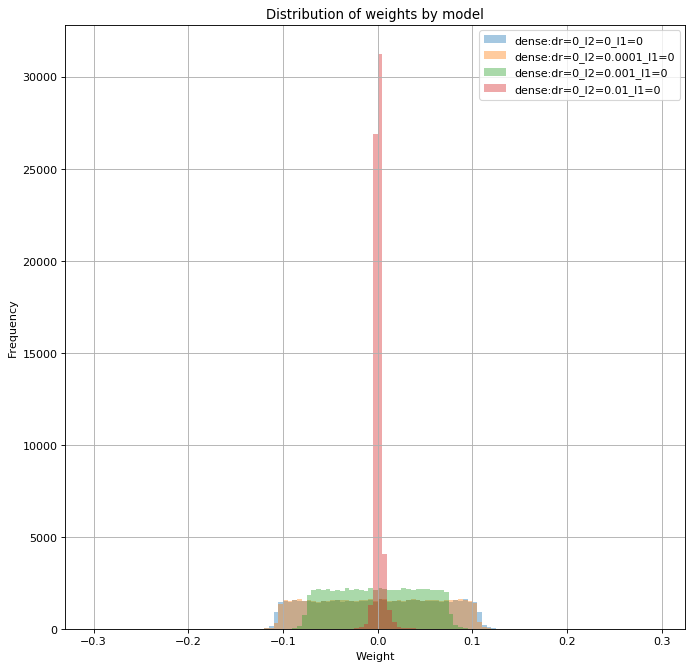

In [160]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'dense:dr=0_l2=0.0001_l1=0',
    'dense:dr=0_l2=0.001_l1=0',
    'dense:dr=0_l2=0.01_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l2')

#### Activation Visualization
The average activations are really small whenever the model doesn't converge.

dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0)


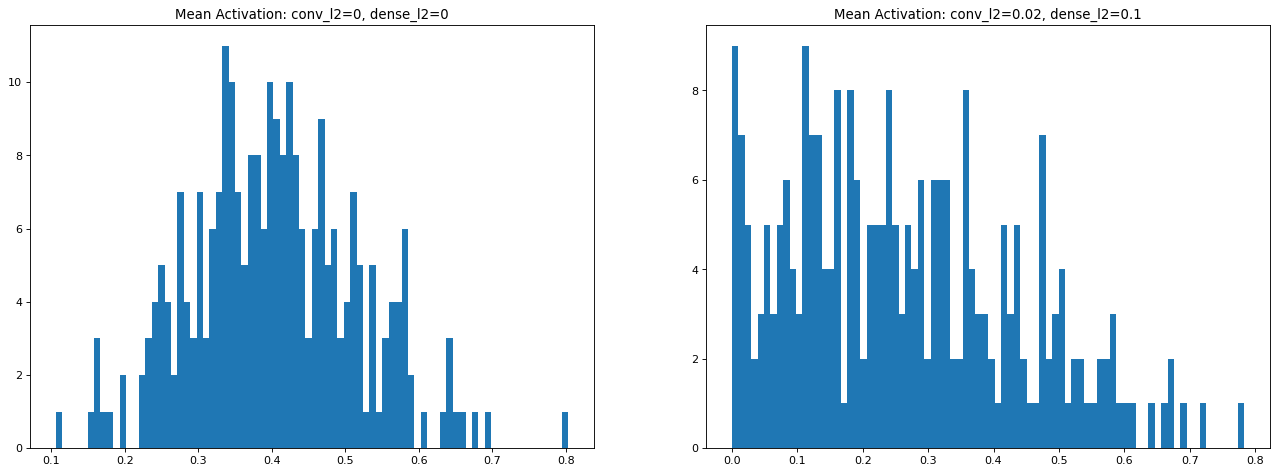

In [240]:
non_zero_activations_by_l2={}
plt.figure(figsize=(20, 7), dpi=80)
i=0
for key in [
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0.02,0.1), (0,0), (0,0)),
]:
    weights_path='pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key_to_str(key))
    dr_key=regularizer_printable_key(key, typ='l2')
    print(key_to_str(key))
    model = ml_utils.build_model()
    model.load_weights(weights_path)#'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activation = activation_model.predict(np_sample_batch[0], steps=1)[32]

    activation_average = np.average(activation, axis=0)
    non_zero_activation_average = np.average(np.sum(activation>0, axis=1))
    activation_flat=np.ndarray.flatten(activation)
    
    plt.subplot(121+i)
    plt.title('Mean Activation: {}'.format(dr_key))
    plt.hist(activation_average, bins=80)
    i=i+1
    
    
plt.show() 

dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)


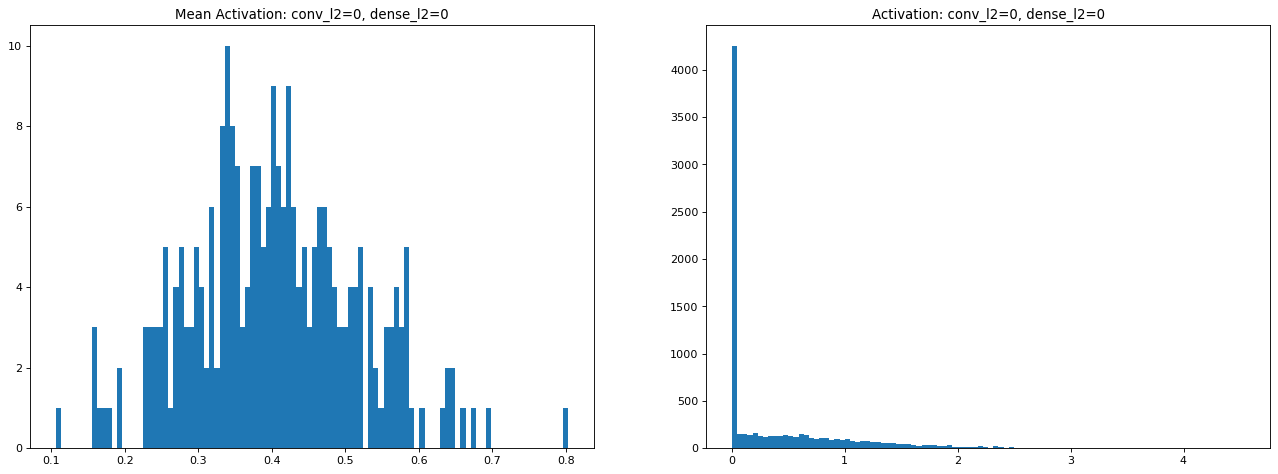

Average no. of non zero activations across a mini batch: 127.59375
dr=(0, 0)_l2=(0, 0.1)_l1=(0, 0)_maxnorm=(0, 0)


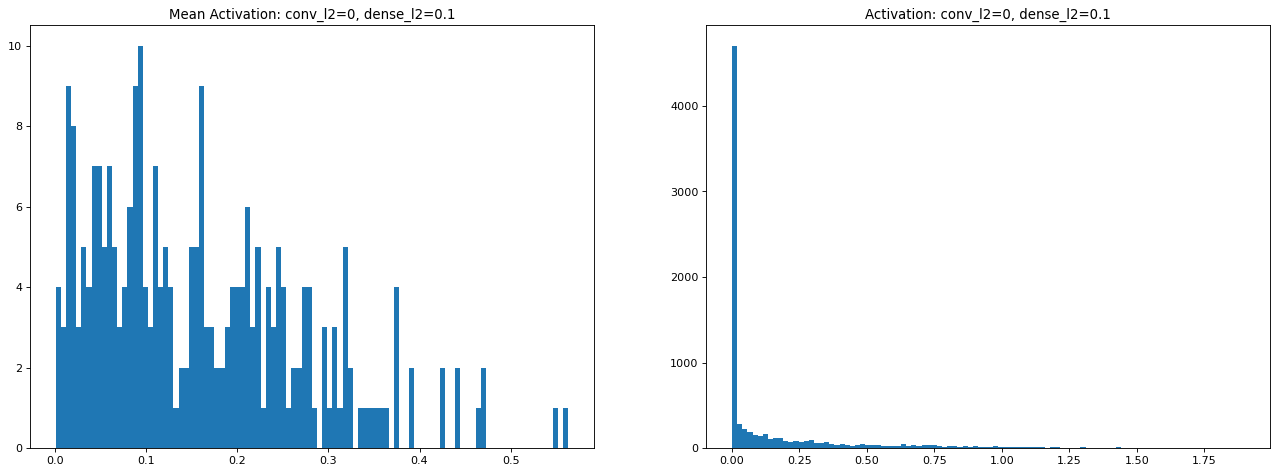

Average no. of non zero activations across a mini batch: 128.34375
dr=(0, 0)_l2=(0.001, 0.1)_l1=(0, 0)_maxnorm=(0, 0)


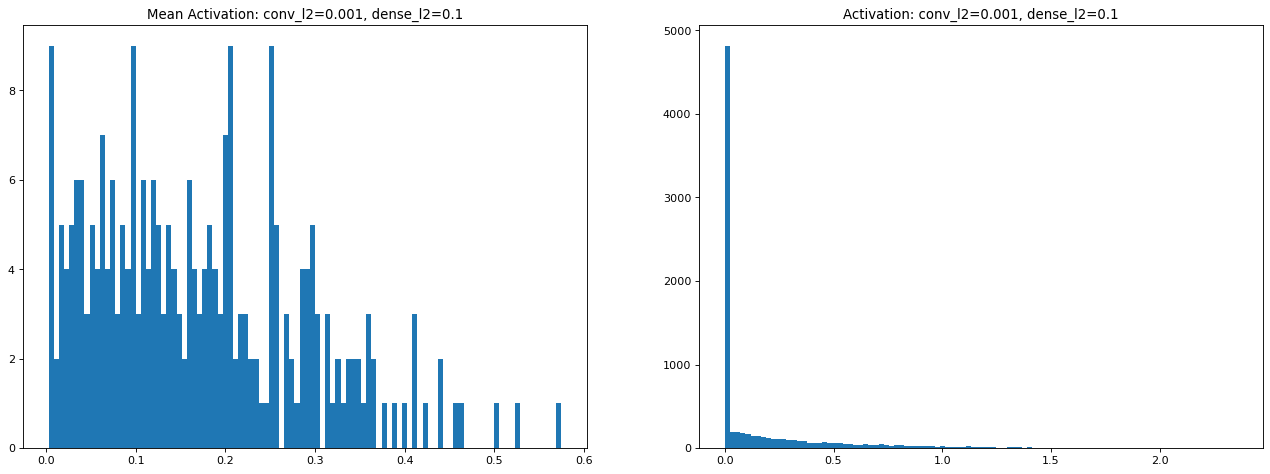

Average no. of non zero activations across a mini batch: 120.34375
dr=(0, 0)_l2=(0.01, 0.1)_l1=(0, 0)_maxnorm=(0, 0)


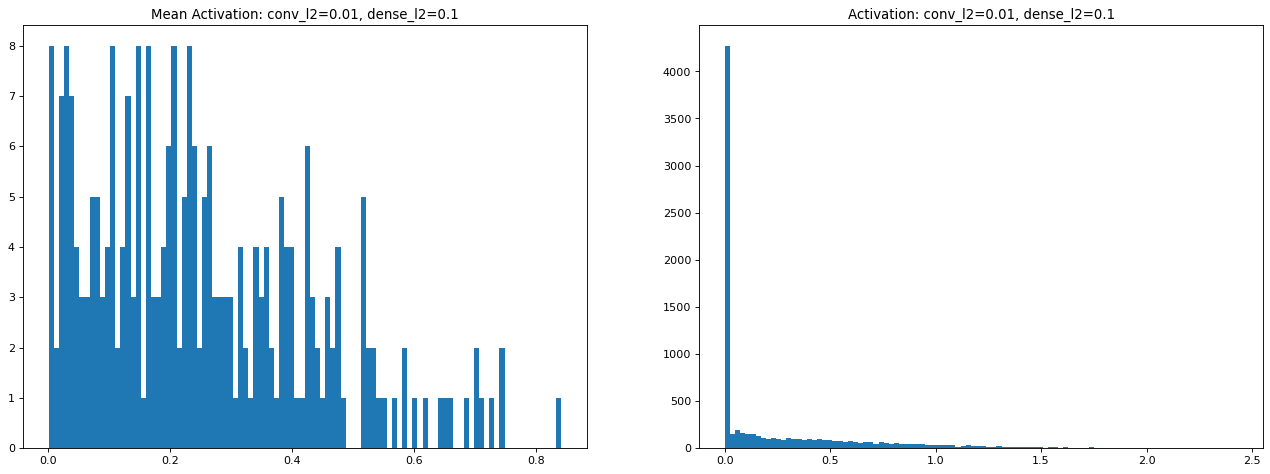

Average no. of non zero activations across a mini batch: 132.65625
dr=(0, 0)_l2=(0.1, 0.1)_l1=(0, 0)_maxnorm=(0, 0)


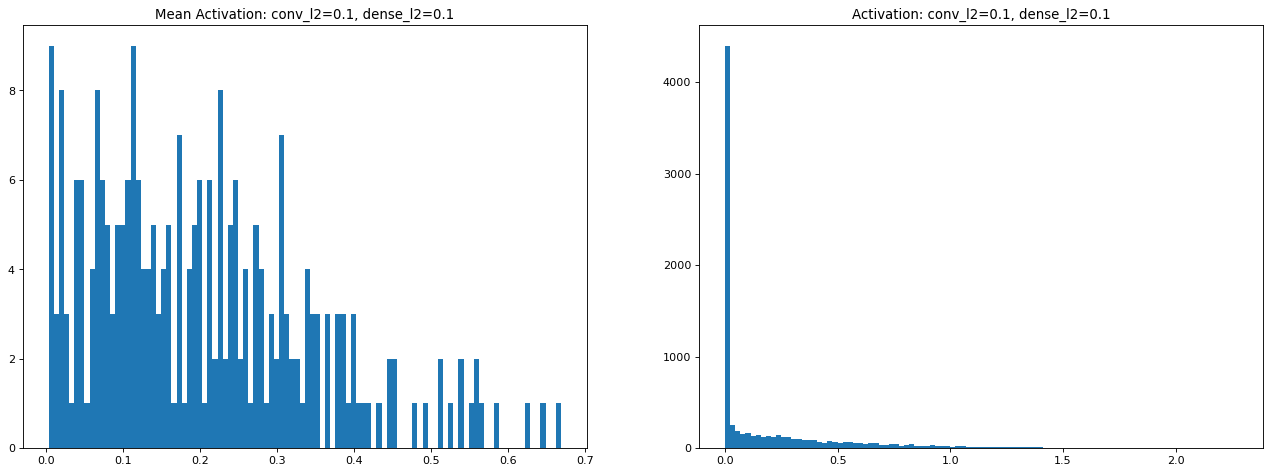

Average no. of non zero activations across a mini batch: 128.25


Text(0.5, 0, 'Non-zero activations in last FC layer')

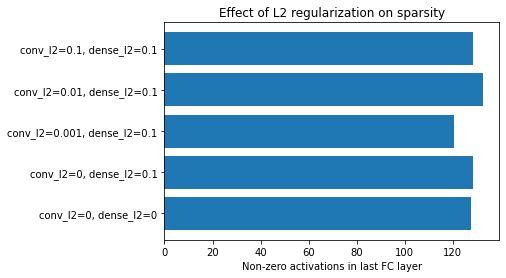

In [168]:
non_zero_activations_by_l2={}
for key in [
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0,0.1), (0,0), (0,0)),
    ((0,0), (0.001,0.1), (0,0), (0,0)),
    ((0,0), (0.01,0.1), (0,0), (0,0)),
    ((0,0), (0.1,0.1), (0,0), (0,0)),
]:
    weights_path='pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key_to_str(key))
    dr_key=regularizer_printable_key(key, typ='l2')
    print(key_to_str(key))
    non_zero_activations_by_l2[dr_key]=visualize_activations(
        weights_path, 32, np_sample_batch, dr_key, show_plot=True)
    
    
plt.title('Effect of L2 regularization on sparsity')
plt.barh(
    list(non_zero_activations_by_l2.keys()), 
    list(non_zero_activations_by_l2.values()))
plt.xlabel('Non-zero activations in last FC layer')   

In [174]:
summarize_activations(stats_by_regularizer, model_state_by_l2, np_sample_batch)

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Non-zero Activations L(n-1): 127.59375, Average Activation L(n-1): 103.25991821289062
Non-zero Activations Ln: 127.59375, Average Activation Ln: 103.25991821289062

*********************************************************************

Stats for dr=(0, 0)_l2=(0, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.4782408247866469, 'val_loss': 0.5302939139408608, 'train_accuracy': 0.82788825, 'val_accuracy': 0.7970765, 'epochs': 6}
Non-zero Activations L(n-1): 128.34375, Average Activation L(n-1): 40.774566650390625
Non-zero Activations Ln: 128.34375, Average Activation Ln: 40.774566650390625

*********************************************************************

Stats for dr=(0, 0)_l2=(0.001, 0.1)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.555219338280

### 3. L1 Regularization

In [217]:
model_state_by_l1={}
l1_key={}
for regularizer_config in [ # dense(dropout, l2, l1)
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0,0), (0,0.01), (0,0)),
    ((0,0), (0,0), (0.001,0.01), (0,0)),
    ((0,0), (0,0), (0.002,0.01), (0,0)),
]:
    # Read config from regularizer_config
    key = key_to_str(regularizer_config)
    l1_key[key]=regularizer_printable_key(regularizer_config, 'l1')
    if key in model_state_by_regularizers:
        model_state_by_l1[key] = model_state_by_regularizers[key] 

l1_by_key={l1_key[k]:v for k,v in model_state_by_l1.items()}

#### Summarize Results
Surprisingly L1 Regularization didn't help increase validation accuracy a lot. 

In [218]:
stats_by_l1={}
for key,model_state in model_state_by_l1.items():
    stats_by_l1[l1_key[key]]=stats_by_regularizer[key]
    print('Stats for {key} at convergence: '.format(key=key), stats_by_regularizer[key])
    
    

Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.3612129134317677, 'val_loss': 0.4744470745120963, 'train_accuracy': 0.84427726, 'val_accuracy': 0.77966464, 'epochs': 3}
Stats for dr=(0, 0)_l2=(0, 0)_l1=(0, 0.01)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.697991015986689, 'val_loss': 0.763220970761286, 'train_accuracy': 0.82853305, 'val_accuracy': 0.78933793, 'epochs': 13}
Stats for dr=(0, 0)_l2=(0, 0)_l1=(0.001, 0.01)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.8239409928165541, 'val_loss': 0.8753806352615356, 'train_accuracy': 0.85905427, 'val_accuracy': 0.8344798, 'epochs': 20}
Stats for dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.7213354419854814, 'val_loss': 0.7387945141694318, 'train_accuracy': 0.8892531, 'val_accuracy': 0.87854683, 'epochs': 142}


In [219]:
visualize_stats(stats_by_l1)

train_loss  val_loss  train_accuracy  \
conv_l1=0, dense_l1=0           0.361213  0.474447        0.844277   
conv_l1=0, dense_l1=0.01        0.697991  0.763221        0.828533   
conv_l1=0.001, dense_l1=0.01    0.823941  0.875381        0.859054   
conv_l1=0.002, dense_l1=0.01    0.721335  0.738795        0.889253   

                              val_accuracy  epochs  
conv_l1=0, dense_l1=0             0.779665       3  
conv_l1=0, dense_l1=0.01          0.789338      13  
conv_l1=0.001, dense_l1=0.01      0.834480      20  
conv_l1=0.002, dense_l1=0.01      0.878547     142

#### Loss

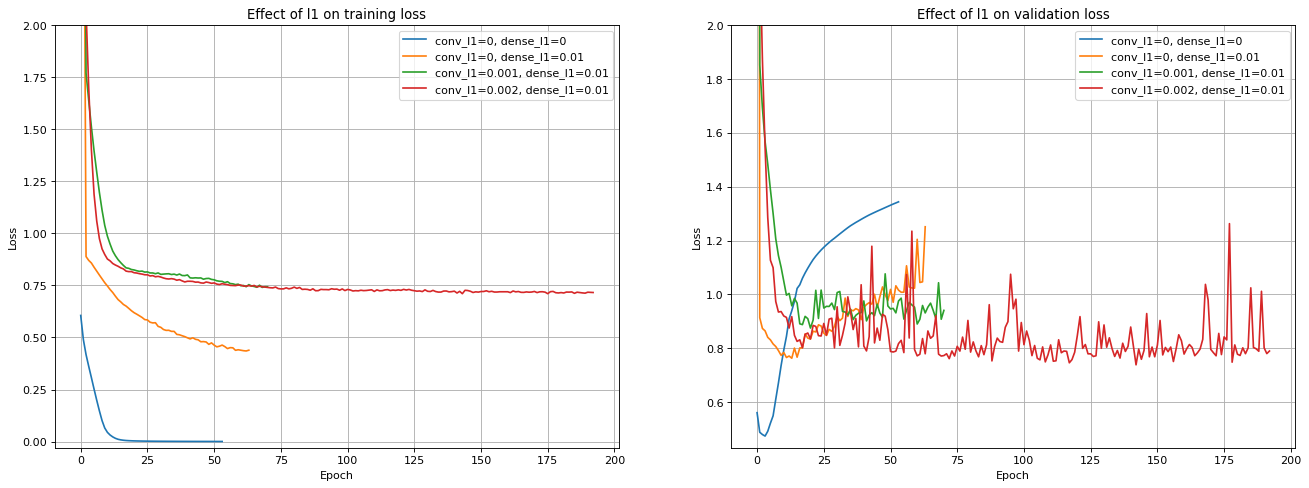

<Figure size 432x288 with 0 Axes>

In [220]:
ml_utils.plot_loss_by_param(l1_by_key, 'l1', 'l1_loss', ylim_right=2)

#### Accuracy

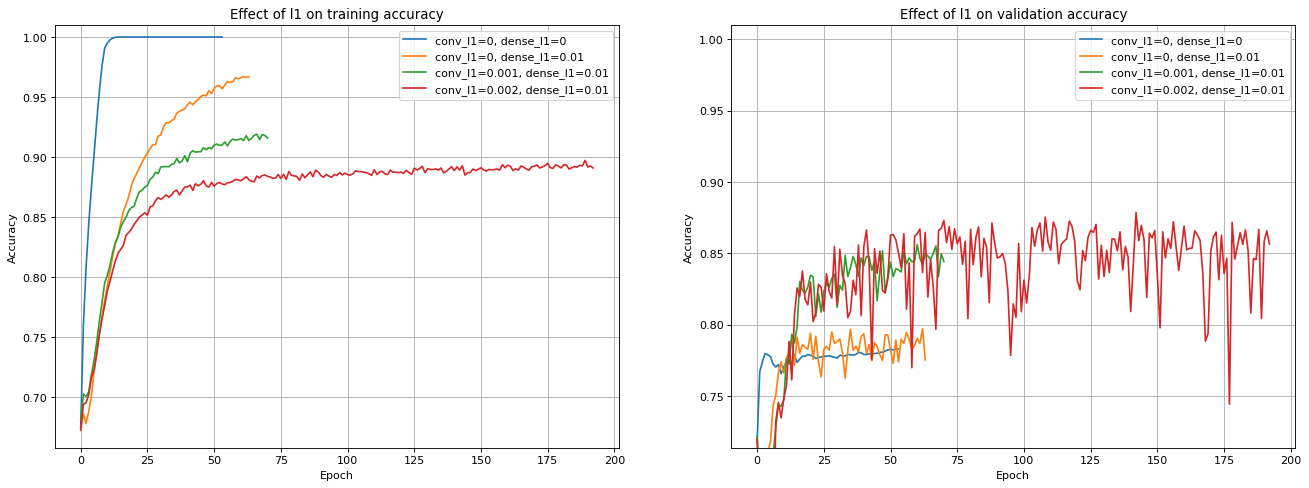

<Figure size 432x288 with 0 Axes>

In [224]:
ml_utils.plot_accuracies_by_param(l1_by_key, 'l1', 'l1_accuracy', ylim_right=1.01)

#### Generalization Gap

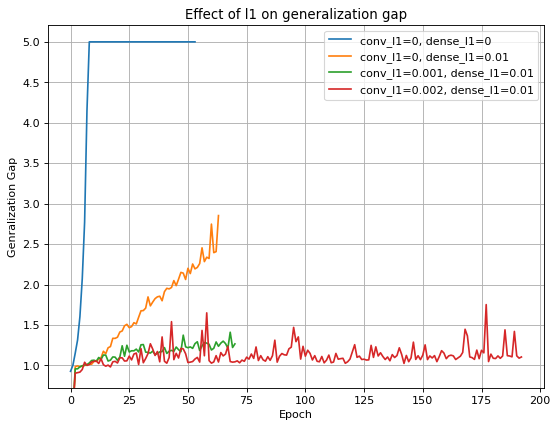

In [225]:
ml_utils.plot_generalization_gap_by_param(l1_by_key, 'l1', 'l1_gen_gap', 5)

#### Weight Visualization

Model: conv_l1=0, dense_l1=0, Max Weight: 0.19702987372875214, Min Weight: 0.19702987372875214, Weight Mean Square: 0.009070958010852337
Model: conv_l1=0.002, dense_l1=0.01, Max Weight: 1.0458285808563232, Min Weight: 1.0458285808563232, Weight Mean Square: 0.004272493068128824
Model: conv_l1=0, dense_l1=0, Max Weight: 0.11880972236394882, Min Weight: 0.11880972236394882, Weight Mean Square: 0.003912077751010656
Model: conv_l1=0.002, dense_l1=0.01, Max Weight: 1.0465571880340576, Min Weight: 1.0465571880340576, Weight Mean Square: 1.671601967245806e-05
Model: conv_l1=0, dense_l1=0, Max Weight: 0.10001704841852188, Min Weight: 0.10001704841852188, Weight Mean Square: 0.0015703312819823623
Model: conv_l1=0.002, dense_l1=0.01, Max Weight: 0.10217520594596863, Min Weight: 0.10217520594596863, Weight Mean Square: 3.866419149289868e-07
Model: conv_l1=0, dense_l1=0, Max Weight: 0.1375252902507782, Min Weight: 0.1375252902507782, Weight Mean Square: 0.0023956038057804108
Model: conv_l1=0.002, 

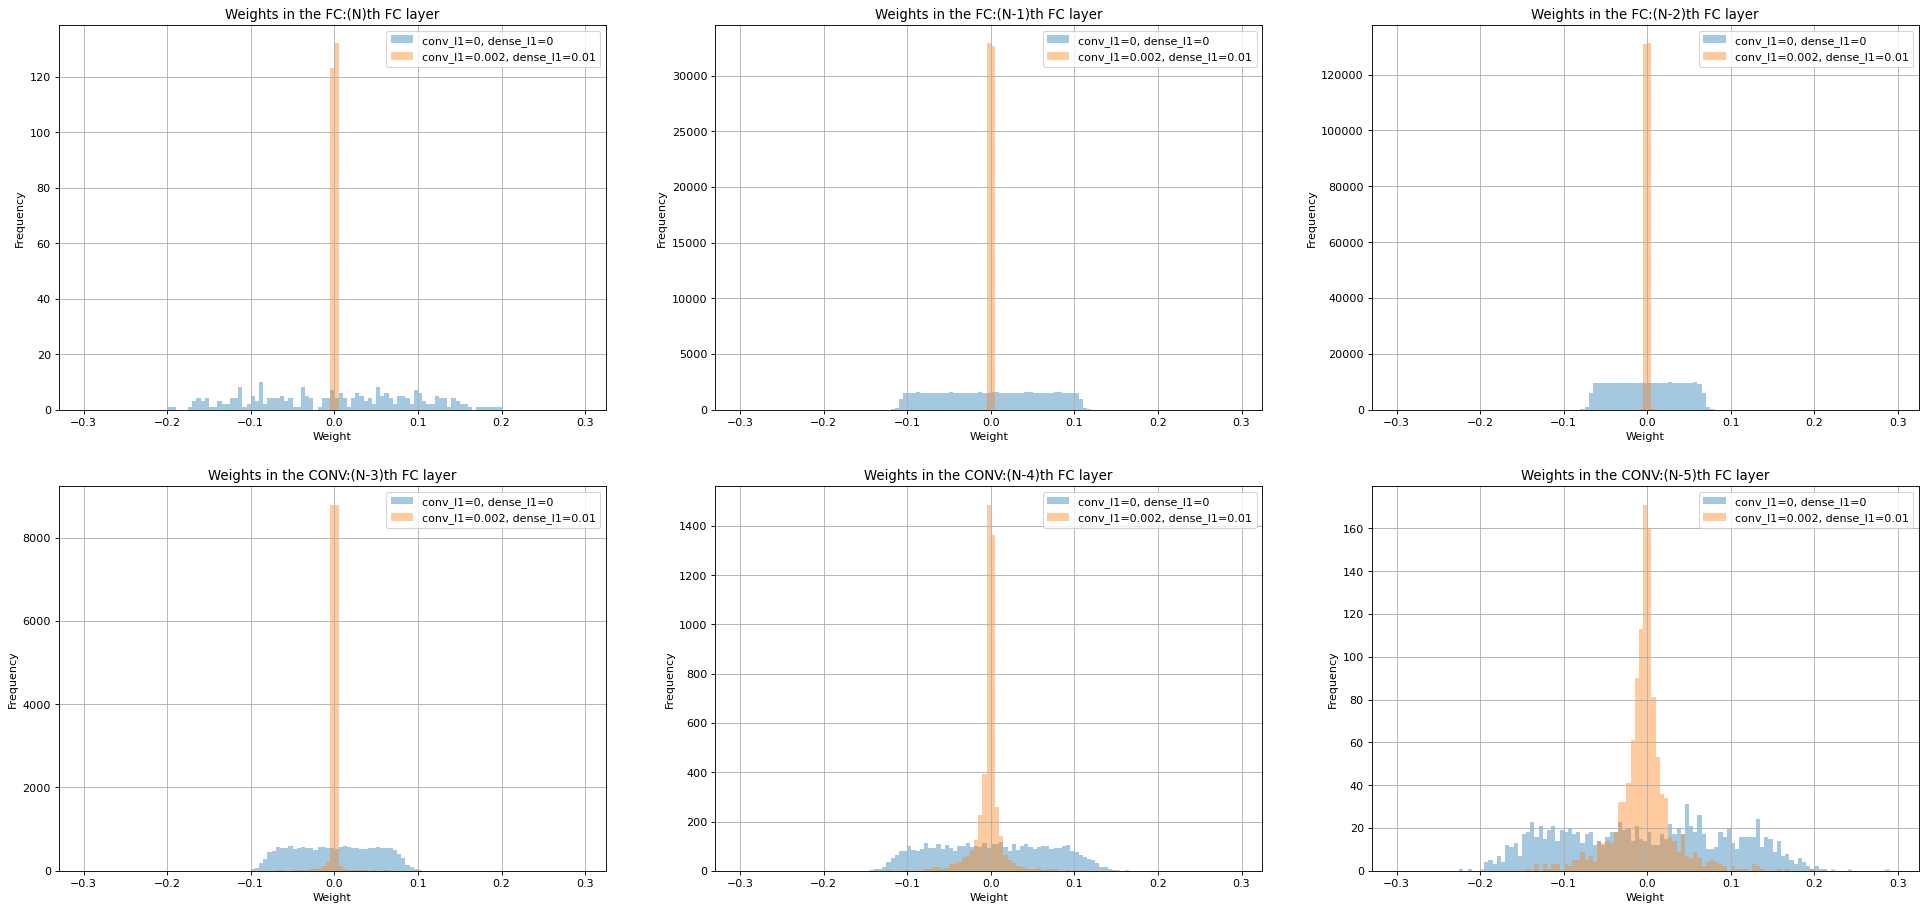

In [212]:
plt.figure(figsize=(30, 14), dpi=80)
for (weight_index, subplot, param) in [(42,231, 'FC:(N)'), (40,232, 'FC:(N-1)'), (34,233, 'FC:(N-2)'), 
                                      (28,234, 'CONV:(N-3)'), (22,235, 'CONV:(N-4)'), (16,236, 'CONV:(N-5)'),]:
    plt.subplot(subplot)
    plt.title('Weights in the {}th FC layer'.format(param))
    
    model_weights_by_regularizers = {}
    for key in model_state_by_l1.keys():
        if key in 'dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)' \
            or key in 'dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)_maxnorm=(0, 0)':
            model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0)
            model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
            model_weights_by_regularizers[l1_key[key]] = model.get_weights()[weight_index]

    ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l2')

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0_l2=0_l1=1e-05, Max Weight: 0.1531360149383545, Min Weight: 0.1531360149383545
Model: dense:dr=0_l2=0_l1=0.0001, Max Weight: 0.17068800330162048, Min Weight: 0.17068800330162048
Model: dense:dr=0_l2=0_l1=0.001, Max Weight: 0.6767701506614685, Min Weight: 0.6767701506614685


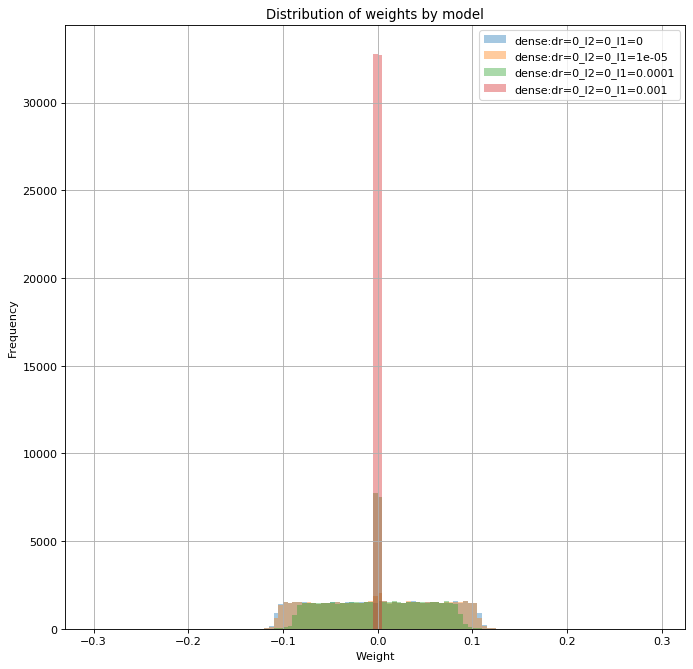

In [157]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'dense:dr=0_l2=0_l1=1e-05',
    'dense:dr=0_l2=0_l1=0.0001',
    'dense:dr=0_l2=0_l1=0.001'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l1')

#### Activation Visualization

dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)
dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)_maxnorm=(0, 0)


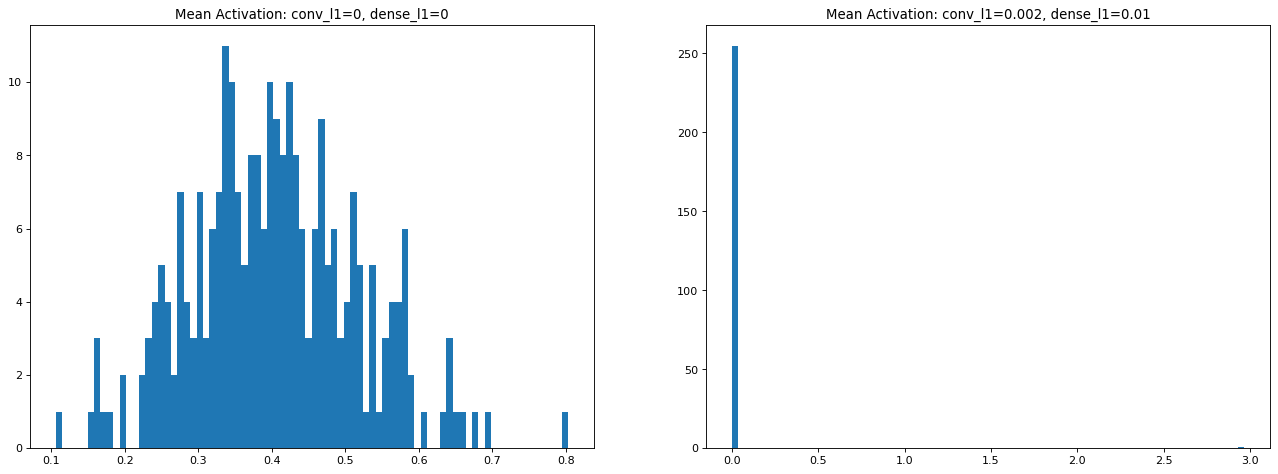

In [213]:
non_zero_activations_by_l1={}
plt.figure(figsize=(20, 7), dpi=80)
i=0
for key in [
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0,0), (0.002,0.01), (0,0)),
]:
    weights_path='pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key_to_str(key))
    dr_key=regularizer_printable_key(key, typ='l1')
    print(key_to_str(key))
    model = ml_utils.build_model()
    model.load_weights(weights_path)#'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activation = activation_model.predict(np_sample_batch[0], steps=1)[32]

    activation_average = np.average(activation, axis=0)
    non_zero_activation_average = np.average(np.sum(activation>0, axis=1))
    activation_flat=np.ndarray.flatten(activation)
    
    plt.subplot(121+i)
    plt.title('Mean Activation: {}'.format(dr_key))
    plt.hist(activation_average, bins=80)
    i=i+1
    
    
plt.show() 

dr=(0, 0)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)


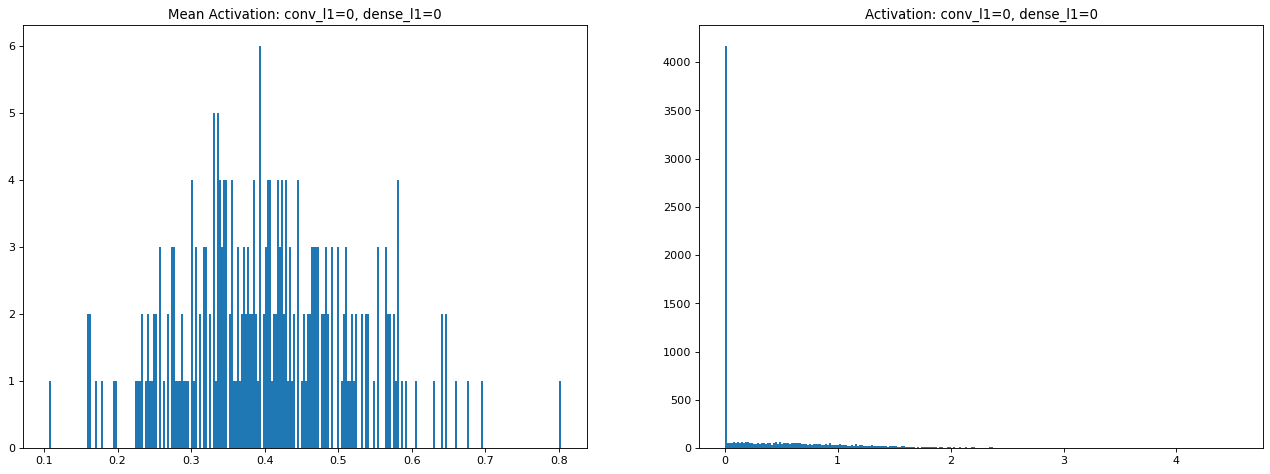

Average no. of non zero activations across a mini batch: 127.59375
dr=(0, 0)_l2=(0, 0)_l1=(0, 0.01)_maxnorm=(0, 0)


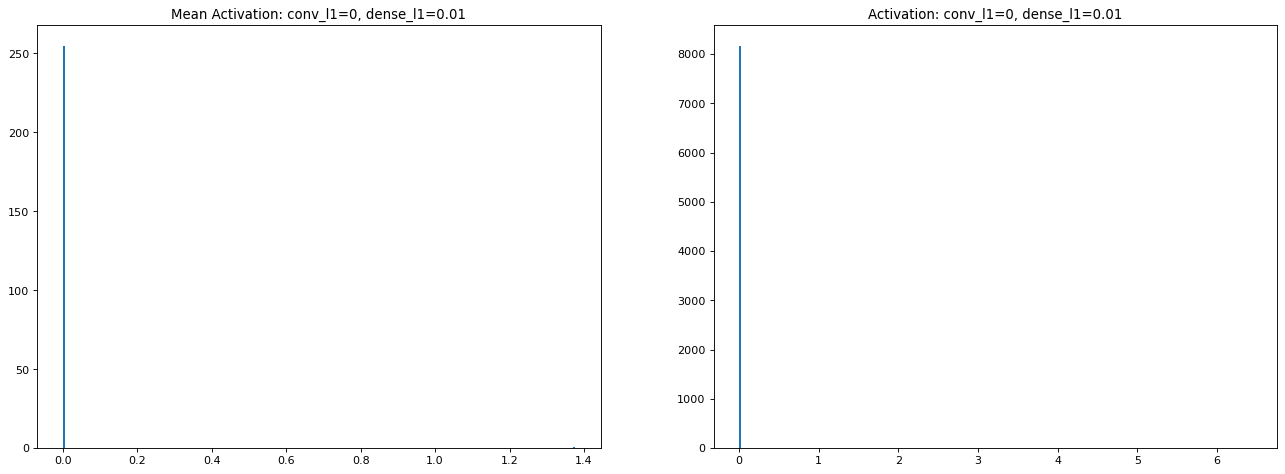

Average no. of non zero activations across a mini batch: 124.40625
dr=(0, 0)_l2=(0, 0)_l1=(0.001, 0.01)_maxnorm=(0, 0)


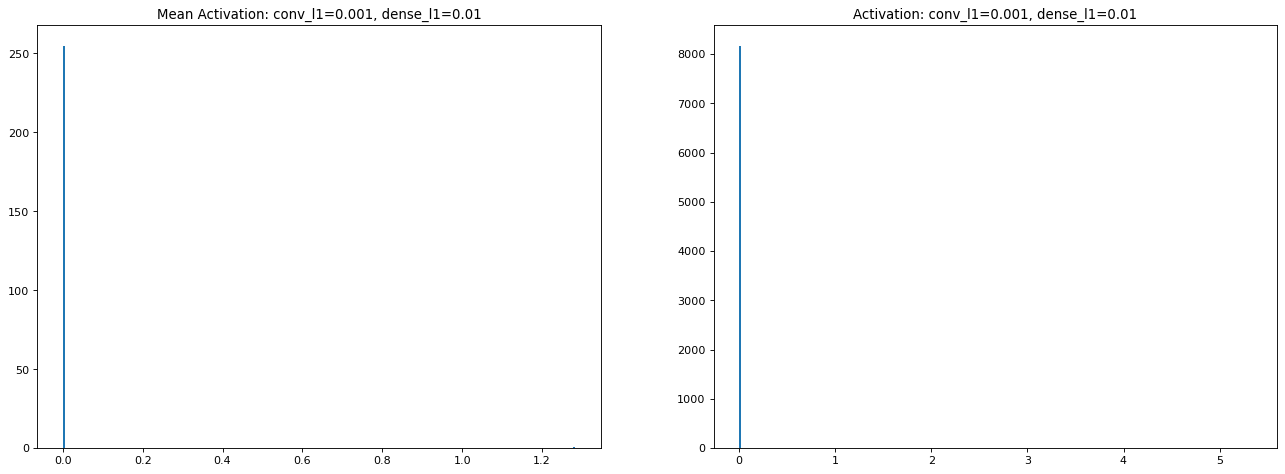

Average no. of non zero activations across a mini batch: 116.84375
dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)_maxnorm=(0, 0)


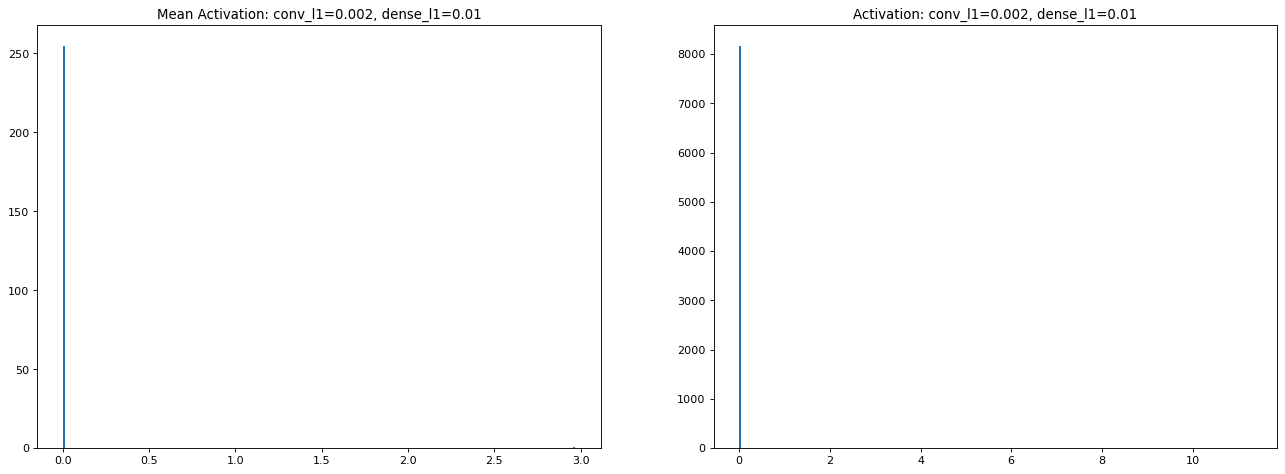

Average no. of non zero activations across a mini batch: 95.84375


Text(0.5, 0, 'Non-zero activations in last FC layer')

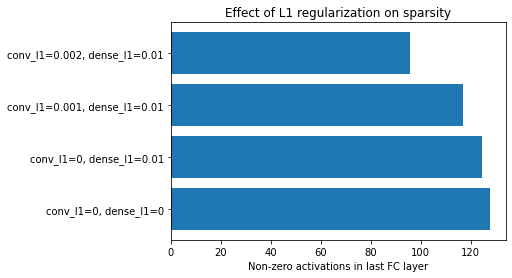

In [223]:
non_zero_activations_by_l1={}
for key in [
    ((0,0), (0,0), (0,0), (0,0)),
    ((0,0), (0,0), (0,0.01), (0,0)),
    ((0,0), (0,0), (0.001,0.01), (0,0)),
    ((0,0), (0,0), (0.002,0.01), (0,0)),
]:
    weights_path='pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key_to_str(key))
    dr_key=regularizer_printable_key(key, typ='l1')
    print(key_to_str(key))
    non_zero_activations_by_l1[dr_key]=visualize_activations(
        weights_path, 32, np_sample_batch, dr_key, show_plot=True, bins=256)
    
    
plt.title('Effect of L1 regularization on sparsity')
plt.barh(
    list(non_zero_activations_by_l1.keys()), 
    list(non_zero_activations_by_l1.values()))
plt.xlabel('Non-zero activations in last FC layer')   

In [129]:
summarize_activations(stats_by_regularizer, model_state_by_l1, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for dense:dr=0_l2=0_l1=1e-05 at convergence:  {'train_loss': 0.4739106807511446, 'val_loss': 0.5389250641408032, 'train_accuracy': 0.846964, 'val_accuracy': 0.8086844}
Non-zero Activations L(n-1): 143.5, Average Activation L(n-1): 38.48678207397461
Non-zero Activations Ln: 155.75, Average Activation Ln: 36.27257537841797

*********************************************************************

Stats for dense:dr=0_l2=0_l1=0.0001 at convergence:  {'train_loss': 0.9501155155311023, 'val_loss': 1.1824969077763492, 'train_accuracy': 0.9039764, 'val_accuracy': 0.79084265}
Non-zero Acti

### 4. Batch Normalization
Use the best of Dropout, L2 Regularization and L1 Regularization with Batch Normalization

In [22]:
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0, 0.01, 0),
    (0, 0.05, 0),
    (0, 1, 0),
    (0, 0, 0.001),
    (0, 0, 0.005),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    key='bn:' + key
    print('Processing: ', key)
    
    if key in model_state_by_regularizers:
        continue
    
    # Build and train model
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
    model = ml_utils.build_model(
        conv_dropout_rate=0 if dense_only else dropout,
        conv_l2_regularizer=0 if dense_only else l2,
        conv_l1_regularizer=0 if dense_only else l1,
        dense_dropout_rate=dropout,
        dense_l2_regularizer=l2,
        dense_l1_regularizer=l1,
        optimizer=optimizer,
        use_batch_normalization=True
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    model_state_by_regularizers[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Processing:  bn:dense:dr=0_l2=0_l1=0
Processing:  bn:dense:dr=0.4_l2=0_l1=0
Processing:  bn:dense:dr=0.6_l2=0_l1=0
Processing:  bn:dense:dr=0_l2=0.01_l1=0
Processing:  bn:dense:dr=0_l2=0.05_l1=0
Processing:  bn:dense:dr=0_l2=1_l1=0
Processing:  bn:dense:dr=0_l2=0_l1=0.001
Processing:  bn:dense:dr=0_l2=0_l1=0.005


In [23]:
model_state_by_bn={}
model_state_by_bn['dense:dr=0_l2=0_l1=0']=model_state_by_regularizers['dense:dr=0_l2=0_l1=0']
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0, 0.01, 0),
    (0, 0.05, 0),
    (0, 1, 0),
    (0, 0, 0.001),
    (0, 0, 0.005),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    key='bn:'+key
    if key in model_state_by_regularizers:
        model_state_by_bn[key] = model_state_by_regularizers[key] #model_state_by_regularizers[key]

#### Summarize Results

In [131]:
for key,model_state in model_state_by_bn.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Stats for bn:dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.4835080045836386, 'val_loss': 0.5069796144962311, 'train_accuracy': 0.76518, 'val_accuracy': 0.75687873}
Stats for bn:dense:dr=0.4_l2=0_l1=0 at convergence:  {'train_loss': 0.31285626659272886, 'val_loss': 0.3755742063465184, 'train_accuracy': 0.8624933, 'val_accuracy': 0.8411436}
Stats for bn:dense:dr=0.6_l2=0_l1=0 at convergence:  {'train_loss': 0.2724382679679264, 'val_loss': 0.35240566850422994, 'train_accuracy': 0.8839871, 'val_accuracy': 0.8531814}
Stats for bn:dense:dr=0_l2=0.01_l1=0 at convergence:  {'train_loss': 0.17298688962855435, 'val_loss': 0.9101071275056225, 'train_accuracy': 0.98409456, 'val_accuracy': 0.799871}
Stats for bn:dense:dr=0_l2=0.05_l1=0 at convergence:  {'train_loss': 0.5511659632761718, 'val_loss': 0.630058860125607, 't

#### Loss
Batch norm significantly increases the speed of convergence

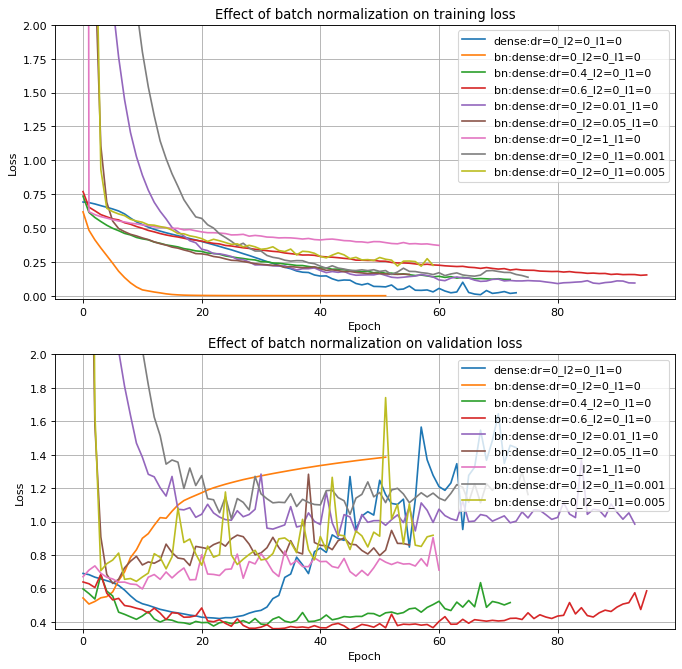

<Figure size 432x288 with 0 Axes>

In [25]:
ml_utils.plot_loss_by_param(model_state_by_bn, 'batch normalization', 'bn_loss', ylim_right=2)

#### Accuracy

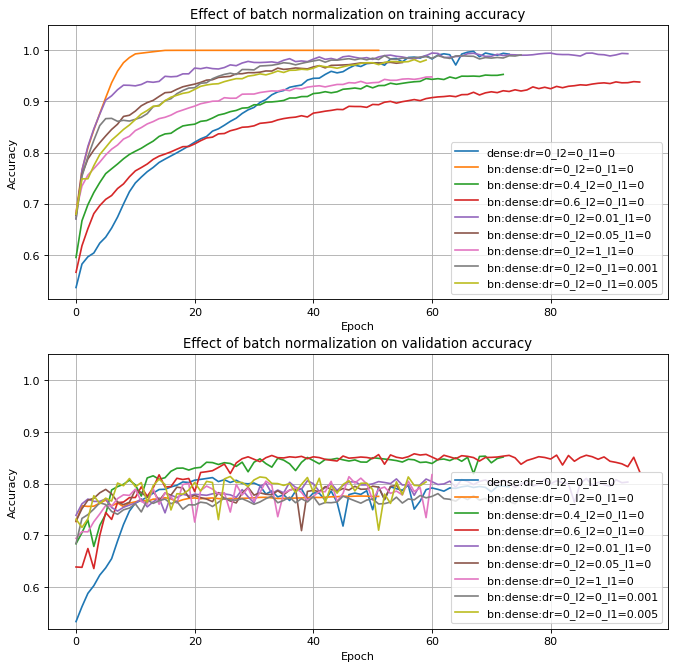

<Figure size 432x288 with 0 Axes>

In [26]:
ml_utils.plot_accuracies_by_param(model_state_by_bn, 'batch normalization', 'bn_accuracy', ylim_right=1.05)

#### Generalization Gap

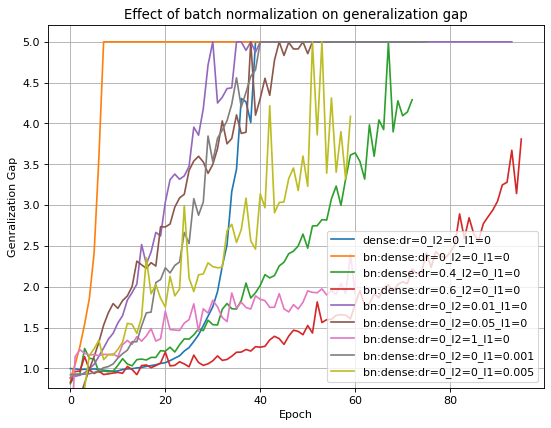

In [132]:
ml_utils.plot_generalization_gap_by_param(model_state_by_bn, 'batch normalization', 'bn_gen_gap', 5)

#### Weight Visualization
Batch Norm doesn't have any effect on the weight distrbution.

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: bn:dense:dr=0_l2=0_l1=0, Max Weight: 0.11604121327400208, Min Weight: 0.11604121327400208
Model: bn:dense:dr=0.4_l2=0_l1=0, Max Weight: 0.1318558156490326, Min Weight: 0.1318558156490326
Model: bn:dense:dr=0.6_l2=0_l1=0, Max Weight: 0.14206580817699432, Min Weight: 0.14206580817699432


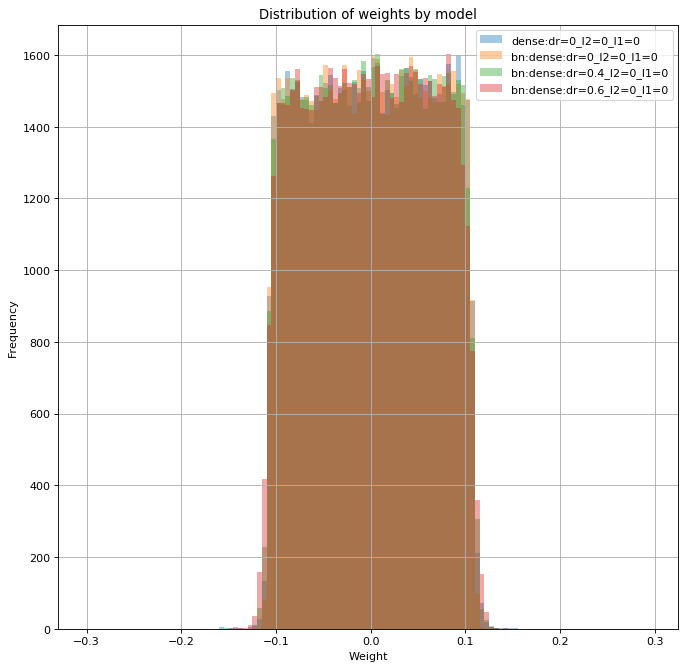

In [153]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'bn:dense:dr=0_l2=0_l1=0',
    'bn:dense:dr=0.4_l2=0_l1=0',
    'bn:dense:dr=0.6_l2=0_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_dropout')

#### Activation Visualization
The scale of node activation value goes up significantly higher as a result of using Batch Norm. The non-zero activations doesn't change even when applying dropout when we use batch norm.

In [133]:
summarize_activations(stats_by_regularizer, model_state_by_bn, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for bn:dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.4835080045836386, 'val_loss': 0.5069796144962311, 'train_accuracy': 0.76518, 'val_accuracy': 0.75687873}
Non-zero Activations L(n-1): 138.59375, Average Activation L(n-1): 218.00045776367188
Non-zero Activations Ln: 127.625, Average Activation Ln: 102.77838134765625

*********************************************************************

Stats for bn:dense:dr=0.4_l2=0_l1=0 at convergence:  {'train_loss': 0.31285626659272886, 'val_loss': 0.3755742063465184, 'train_accuracy': 0.8624933, 'val_accuracy': 0.8411436}
Non-zer

## Combining Regularizers

In [249]:
def generate_random(min, max, scale='linear'):
    rand=np.random.rand()
    if scale=='linear':
        return (rand*(max-min))+min
    else:
        log_max=np.log10(max)
        log_min=np.log10(min)
        return np.power(10, (rand*(log_max-log_min))+log_min)

In [253]:
generate_random(0.1, 0.25)

0.23376595011731197

In [248]:
all_regularizers={}
all_regularizers_tuple={}

1.0

In [273]:
def correct_order(a, b):
    if a<b:
        return (a,b)
    else:
        return (b,a)

In [275]:
for i in range(20):

    (conv_dropout_rate, dense_dropout_rate)=correct_order(generate_random(0.01, 0.25), generate_random(0.01, 0.7))
    (conv_l2_regularizer, dense_l2_regularizer)=correct_order(generate_random(0.000001, 0.03, 'log'), 
                                                 generate_random(0.00001, 0.1, 'log'))
    (conv_l1_regularizer, dense_l1_regularizer)=correct_order(generate_random(0.0000001, 0.003, 'log'), 
                                                 generate_random(0.000001, 0.01, 'log'))

    regularizers_tuple=(
        (conv_dropout_rate, dense_dropout_rate),
        (conv_l2_regularizer, dense_l2_regularizer),
        (conv_l1_regularizer, dense_l1_regularizer),
        (0, 0)
    )
    key = key_to_str(regularizers_tuple)
    print('Processing: ', key)

    # if key in all_regularizers:
    #     continue

    # Build and train model
    all_regularizers_tuple[key]=regularizers_tuple
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model = ml_utils.build_model(
        conv_dropout_rate=conv_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        conv_l2_regularizer=conv_l2_regularizer,
        dense_l2_regularizer=dense_l2_regularizer,
        conv_l1_regularizer=conv_l1_regularizer,
        dense_l1_regularizer=dense_l1_regularizer,
        optimizer=optimizer
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/regularization/regularizers_{}.h5'.format(key),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    all_regularizers[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=500,
        extra_callbacks=[es, mc],
    )

Processing:  dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.647885266956312e-05)_maxnorm=(0, 0)
Epoch 1/500
    582/Unknown - 11s 20ms/step - loss: 1.9756 - accuracy: 0.6426
Epoch 00001: val_loss improved from inf to 1.66004, saving model to pickled_objects/regularization/regularizers_dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.647885266956312e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 13s 22ms/step - loss: 1.9756 - accuracy: 0.6426 - val_loss: 1.6600 - val_accuracy: 0.5834
Epoch 2/500
581/582 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.7306
Epoch 00002: val_loss improved from 1.66004 to 0.96749, saving model to pickled_objects/regularization/regularizers_dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.6478

Epoch 21/500
580/582 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.8566
Epoch 00021: val_loss did not improve from 0.49787
582/582 [==============================] - 10s 16ms/step - loss: 0.5137 - accuracy: 0.8566 - val_loss: 0.5044 - val_accuracy: 0.8439
Epoch 22/500
581/582 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8588
Epoch 00022: val_loss did not improve from 0.49787
582/582 [==============================] - 10s 16ms/step - loss: 0.5037 - accuracy: 0.8589 - val_loss: 0.5093 - val_accuracy: 0.8551
Epoch 23/500
581/582 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.8611
Epoch 00023: val_loss did not improve from 0.49787
582/582 [==============================] - 10s 16ms/step - loss: 0.4974 - accuracy: 0.8611 - val_loss: 0.5024 - val_accuracy: 0.8463
Epoch 24/500
581/582 [============================>.] - ETA: 0s - loss: 0.4933 - accuracy: 0.8610
Epoch 00024: val_loss did not improve from 0.49787
582/5

Epoch 44/500
581/582 [============================>.] - ETA: 0s - loss: 0.4228 - accuracy: 0.8741
Epoch 00044: val_loss did not improve from 0.40404
582/582 [==============================] - 10s 16ms/step - loss: 0.4226 - accuracy: 0.8742 - val_loss: 0.4131 - val_accuracy: 0.8738
Epoch 45/500
580/582 [============================>.] - ETA: 0s - loss: 0.4165 - accuracy: 0.8754
Epoch 00045: val_loss did not improve from 0.40404
582/582 [==============================] - 10s 16ms/step - loss: 0.4162 - accuracy: 0.8756 - val_loss: 0.4177 - val_accuracy: 0.8697
Epoch 46/500
581/582 [============================>.] - ETA: 0s - loss: 0.4170 - accuracy: 0.8723
Epoch 00046: val_loss did not improve from 0.40404
582/582 [==============================] - 9s 16ms/step - loss: 0.4170 - accuracy: 0.8723 - val_loss: 0.4754 - val_accuracy: 0.8334
Epoch 47/500
581/582 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.8766
Epoch 00047: val_loss did not improve from 0.40404
582/58

Epoch 71/500
581/582 [============================>.] - ETA: 0s - loss: 0.3944 - accuracy: 0.8819
Epoch 00071: val_loss did not improve from 0.38202
582/582 [==============================] - 10s 16ms/step - loss: 0.3942 - accuracy: 0.8819 - val_loss: 0.4720 - val_accuracy: 0.8274
Epoch 72/500
581/582 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8844
Epoch 00072: val_loss did not improve from 0.38202
582/582 [==============================] - 10s 16ms/step - loss: 0.3923 - accuracy: 0.8845 - val_loss: 0.4232 - val_accuracy: 0.8532
Epoch 73/500
581/582 [============================>.] - ETA: 0s - loss: 0.3976 - accuracy: 0.8813
Epoch 00073: val_loss did not improve from 0.38202
582/582 [==============================] - 10s 16ms/step - loss: 0.3973 - accuracy: 0.8815 - val_loss: 0.4031 - val_accuracy: 0.8661
Epoch 74/500
581/582 [============================>.] - ETA: 0s - loss: 0.3947 - accuracy: 0.8871
Epoch 00074: val_loss did not improve from 0.38202
582/5

Epoch 97/500
581/582 [============================>.] - ETA: 0s - loss: 0.3819 - accuracy: 0.8883
Epoch 00097: val_loss did not improve from 0.36916
582/582 [==============================] - 10s 16ms/step - loss: 0.3819 - accuracy: 0.8883 - val_loss: 0.4313 - val_accuracy: 0.8562
Epoch 98/500
581/582 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8885
Epoch 00098: val_loss did not improve from 0.36916
582/582 [==============================] - 10s 16ms/step - loss: 0.3845 - accuracy: 0.8885 - val_loss: 0.3968 - val_accuracy: 0.8803
Epoch 99/500
581/582 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8910
Epoch 00099: val_loss did not improve from 0.36916
582/582 [==============================] - 10s 16ms/step - loss: 0.3836 - accuracy: 0.8910 - val_loss: 0.3718 - val_accuracy: 0.8914
Epoch 100/500
581/582 [============================>.] - ETA: 0s - loss: 0.3811 - accuracy: 0.8908
Epoch 00100: val_loss did not improve from 0.36916
582/

Epoch 124/500
581/582 [============================>.] - ETA: 0s - loss: 0.3770 - accuracy: 0.8911
Epoch 00124: val_loss improved from 0.35219 to 0.35104, saving model to pickled_objects/regularization/regularizers_dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.647885266956312e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.3768 - accuracy: 0.8912 - val_loss: 0.3510 - val_accuracy: 0.8955
Epoch 125/500
581/582 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8940
Epoch 00125: val_loss did not improve from 0.35104
582/582 [==============================] - 10s 16ms/step - loss: 0.3724 - accuracy: 0.8940 - val_loss: 0.3675 - val_accuracy: 0.8865
Epoch 126/500
581/582 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8924
Epoch 00126: val_loss did not improve from 0.35104
582/582 [==============================] - 10s 16ms/step

Epoch 151/500
581/582 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8953
Epoch 00151: val_loss did not improve from 0.33688
582/582 [==============================] - 10s 16ms/step - loss: 0.3671 - accuracy: 0.8952 - val_loss: 0.3913 - val_accuracy: 0.8882
Epoch 152/500
581/582 [============================>.] - ETA: 0s - loss: 0.3698 - accuracy: 0.8949
Epoch 00152: val_loss did not improve from 0.33688
582/582 [==============================] - 10s 16ms/step - loss: 0.3697 - accuracy: 0.8949 - val_loss: 0.3566 - val_accuracy: 0.8981
Epoch 153/500
581/582 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8917
Epoch 00153: val_loss did not improve from 0.33688
582/582 [==============================] - 10s 16ms/step - loss: 0.3705 - accuracy: 0.8916 - val_loss: 0.3491 - val_accuracy: 0.9000
Epoch 154/500
581/582 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8927
Epoch 00154: val_loss did not improve from 0.33688
5

581/582 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8958
Epoch 00178: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 16ms/step - loss: 0.3661 - accuracy: 0.8959 - val_loss: 0.3630 - val_accuracy: 0.8921
Epoch 179/500
581/582 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8955
Epoch 00179: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 16ms/step - loss: 0.3693 - accuracy: 0.8955 - val_loss: 0.3467 - val_accuracy: 0.8940
Epoch 180/500
580/582 [============================>.] - ETA: 0s - loss: 0.3681 - accuracy: 0.8962
Epoch 00180: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 16ms/step - loss: 0.3683 - accuracy: 0.8961 - val_loss: 0.3393 - val_accuracy: 0.9024
Epoch 181/500
581/582 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8978
Epoch 00181: val_loss did not improve from 0.32684
582/582 [======

Epoch 207/500
580/582 [============================>.] - ETA: 0s - loss: 0.3636 - accuracy: 0.8991
Epoch 00207: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 17ms/step - loss: 0.3635 - accuracy: 0.8991 - val_loss: 0.3357 - val_accuracy: 0.9041
Epoch 208/500
580/582 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8955
Epoch 00208: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 16ms/step - loss: 0.3627 - accuracy: 0.8954 - val_loss: 0.3377 - val_accuracy: 0.9050
Epoch 209/500
580/582 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8995
Epoch 00209: val_loss did not improve from 0.32684
582/582 [==============================] - 10s 17ms/step - loss: 0.3574 - accuracy: 0.8997 - val_loss: 0.3280 - val_accuracy: 0.9065
Epoch 210/500
581/582 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.9000
Epoch 00210: val_loss did not improve from 0.32684
5

580/582 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8968
Epoch 00234: val_loss did not improve from 0.32241
582/582 [==============================] - 9s 16ms/step - loss: 0.3568 - accuracy: 0.8967 - val_loss: 0.3496 - val_accuracy: 0.8940
Epoch 235/500
581/582 [============================>.] - ETA: 0s - loss: 0.3597 - accuracy: 0.8969
Epoch 00235: val_loss improved from 0.32241 to 0.31965, saving model to pickled_objects/regularization/regularizers_dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.647885266956312e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.3597 - accuracy: 0.8970 - val_loss: 0.3196 - val_accuracy: 0.9136
Epoch 236/500
581/582 [============================>.] - ETA: 0s - loss: 0.3582 - accuracy: 0.8984
Epoch 00236: val_loss did not improve from 0.31965
582/582 [==============================] - 10s 16ms/step - loss: 0.3579

580/582 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.9000
Epoch 00262: val_loss did not improve from 0.31965
582/582 [==============================] - 10s 16ms/step - loss: 0.3595 - accuracy: 0.8999 - val_loss: 0.3385 - val_accuracy: 0.9026
Epoch 263/500
578/582 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.8967
Epoch 00263: val_loss did not improve from 0.31965
582/582 [==============================] - 10s 16ms/step - loss: 0.3605 - accuracy: 0.8967 - val_loss: 0.3341 - val_accuracy: 0.9076
Epoch 264/500
580/582 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.9023
Epoch 00264: val_loss did not improve from 0.31965
582/582 [==============================] - 10s 16ms/step - loss: 0.3563 - accuracy: 0.9023 - val_loss: 0.3291 - val_accuracy: 0.9108
Epoch 265/500
581/582 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8995
Epoch 00265: val_loss did not improve from 0.31965
582/582 [======

Epoch 289/500
581/582 [============================>.] - ETA: 0s - loss: 0.3566 - accuracy: 0.9000
Epoch 00289: val_loss did not improve from 0.31549
582/582 [==============================] - 10s 17ms/step - loss: 0.3567 - accuracy: 0.9000 - val_loss: 0.3298 - val_accuracy: 0.9091
Epoch 290/500
581/582 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.8997
Epoch 00290: val_loss did not improve from 0.31549
582/582 [==============================] - 9s 16ms/step - loss: 0.3552 - accuracy: 0.8997 - val_loss: 0.3255 - val_accuracy: 0.9061
Epoch 291/500
581/582 [============================>.] - ETA: 0s - loss: 0.3571 - accuracy: 0.9008
Epoch 00291: val_loss did not improve from 0.31549
582/582 [==============================] - 10s 16ms/step - loss: 0.3570 - accuracy: 0.9009 - val_loss: 0.3551 - val_accuracy: 0.8921
Epoch 292/500
581/582 [============================>.] - ETA: 0s - loss: 0.3534 - accuracy: 0.8986
Epoch 00292: val_loss did not improve from 0.31549
58

Epoch 316/500
581/582 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.8978
Epoch 00316: val_loss did not improve from 0.30836
582/582 [==============================] - 10s 16ms/step - loss: 0.3563 - accuracy: 0.8977 - val_loss: 0.3154 - val_accuracy: 0.9138
Epoch 317/500
581/582 [============================>.] - ETA: 0s - loss: 0.3547 - accuracy: 0.8994
Epoch 00317: val_loss did not improve from 0.30836
582/582 [==============================] - 10s 16ms/step - loss: 0.3547 - accuracy: 0.8994 - val_loss: 0.3321 - val_accuracy: 0.9099
Epoch 318/500
580/582 [============================>.] - ETA: 0s - loss: 0.3559 - accuracy: 0.8975
Epoch 00318: val_loss did not improve from 0.30836
582/582 [==============================] - 10s 17ms/step - loss: 0.3559 - accuracy: 0.8975 - val_loss: 0.3193 - val_accuracy: 0.9162
Epoch 319/500
579/582 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.9014
Epoch 00319: val_loss did not improve from 0.30836
5

581/582 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.8960
Epoch 00344: val_loss did not improve from 0.30775
582/582 [==============================] - 10s 16ms/step - loss: 0.3609 - accuracy: 0.8961 - val_loss: 0.3195 - val_accuracy: 0.9121
Epoch 345/500
581/582 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.9001
Epoch 00345: val_loss did not improve from 0.30775
582/582 [==============================] - 10s 16ms/step - loss: 0.3549 - accuracy: 0.9002 - val_loss: 0.3392 - val_accuracy: 0.9056
Epoch 346/500
581/582 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy: 0.9007
Epoch 00346: val_loss did not improve from 0.30775
582/582 [==============================] - 10s 16ms/step - loss: 0.3502 - accuracy: 0.9006 - val_loss: 0.3478 - val_accuracy: 0.8972
Epoch 347/500
580/582 [============================>.] - ETA: 0s - loss: 0.3488 - accuracy: 0.9041
Epoch 00347: val_loss did not improve from 0.30775
582/582 [======

Epoch 371/500
580/582 [============================>.] - ETA: 0s - loss: 0.3467 - accuracy: 0.9030
Epoch 00371: val_loss did not improve from 0.29814
582/582 [==============================] - 10s 16ms/step - loss: 0.3470 - accuracy: 0.9026 - val_loss: 0.3031 - val_accuracy: 0.9162
Epoch 372/500
581/582 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.9014
Epoch 00372: val_loss did not improve from 0.29814
582/582 [==============================] - 10s 16ms/step - loss: 0.3491 - accuracy: 0.9015 - val_loss: 0.3164 - val_accuracy: 0.9129
Epoch 373/500
580/582 [============================>.] - ETA: 0s - loss: 0.3495 - accuracy: 0.9022
Epoch 00373: val_loss did not improve from 0.29814
582/582 [==============================] - 10s 16ms/step - loss: 0.3497 - accuracy: 0.9020 - val_loss: 0.3137 - val_accuracy: 0.9144
Epoch 374/500
581/582 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.9039
Epoch 00374: val_loss did not improve from 0.29814
5

Epoch 400/500
581/582 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.9018
Epoch 00400: val_loss did not improve from 0.29814
582/582 [==============================] - 9s 16ms/step - loss: 0.3484 - accuracy: 0.9019 - val_loss: 0.3106 - val_accuracy: 0.9151
Epoch 401/500
581/582 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.9027
Epoch 00401: val_loss did not improve from 0.29814
582/582 [==============================] - 10s 17ms/step - loss: 0.3442 - accuracy: 0.9028 - val_loss: 0.3259 - val_accuracy: 0.9097
Epoch 402/500
581/582 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.9042
Epoch 00402: val_loss did not improve from 0.29814
582/582 [==============================] - 10s 16ms/step - loss: 0.3413 - accuracy: 0.9042 - val_loss: 0.3180 - val_accuracy: 0.9101
Epoch 403/500
581/582 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.9009
Epoch 00403: val_loss did not improve from 0.29814
58

Epoch 8/500
581/582 [============================>.] - ETA: 0s - loss: 1.1362 - accuracy: 0.7816
Epoch 00008: val_loss improved from 1.15875 to 1.10667, saving model to pickled_objects/regularization/regularizers_dr=(0.2386597627640764, 0.31851651124616287)_l2=(0.006158490242985929, 0.006279384856082838)_l1=(2.14615603852007e-06, 0.0017996633766661845)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.1363 - accuracy: 0.7815 - val_loss: 1.1067 - val_accuracy: 0.7623
Epoch 9/500
581/582 [============================>.] - ETA: 0s - loss: 1.1037 - accuracy: 0.7868
Epoch 00009: val_loss improved from 1.10667 to 1.07540, saving model to pickled_objects/regularization/regularizers_dr=(0.2386597627640764, 0.31851651124616287)_l2=(0.006158490242985929, 0.006279384856082838)_l1=(2.14615603852007e-06, 0.0017996633766661845)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.1039 - accuracy: 0.7866 - val_loss: 1.0754 - val_accurac

Epoch 28/500
581/582 [============================>.] - ETA: 0s - loss: 0.8192 - accuracy: 0.8239
Epoch 00028: val_loss improved from 0.77423 to 0.76412, saving model to pickled_objects/regularization/regularizers_dr=(0.2386597627640764, 0.31851651124616287)_l2=(0.006158490242985929, 0.006279384856082838)_l1=(2.14615603852007e-06, 0.0017996633766661845)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.8190 - accuracy: 0.8240 - val_loss: 0.7641 - val_accuracy: 0.8491
Epoch 29/500
581/582 [============================>.] - ETA: 0s - loss: 0.8369 - accuracy: 0.8189
Epoch 00029: val_loss did not improve from 0.76412
582/582 [==============================] - 9s 16ms/step - loss: 0.8371 - accuracy: 0.8188 - val_loss: 0.7846 - val_accuracy: 0.8132
Epoch 30/500
581/582 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.8263
Epoch 00030: val_loss did not improve from 0.76412
582/582 [==============================] - 9s 16ms/step - loss: 

Epoch 55/500
581/582 [============================>.] - ETA: 0s - loss: 0.7548 - accuracy: 0.8274
Epoch 00055: val_loss did not improve from 0.68748
582/582 [==============================] - 9s 16ms/step - loss: 0.7548 - accuracy: 0.8274 - val_loss: 0.7047 - val_accuracy: 0.8313
Epoch 56/500
581/582 [============================>.] - ETA: 0s - loss: 0.7592 - accuracy: 0.8264
Epoch 00056: val_loss did not improve from 0.68748
582/582 [==============================] - 9s 16ms/step - loss: 0.7592 - accuracy: 0.8264 - val_loss: 0.6947 - val_accuracy: 0.8448
Epoch 57/500
581/582 [============================>.] - ETA: 0s - loss: 0.7368 - accuracy: 0.8274
Epoch 00057: val_loss did not improve from 0.68748
582/582 [==============================] - 9s 16ms/step - loss: 0.7372 - accuracy: 0.8273 - val_loss: 0.7603 - val_accuracy: 0.7846
Epoch 58/500
581/582 [============================>.] - ETA: 0s - loss: 0.7509 - accuracy: 0.8279
Epoch 00058: val_loss did not improve from 0.68748
582/582 

Epoch 81/500
581/582 [============================>.] - ETA: 0s - loss: 0.7158 - accuracy: 0.8318
Epoch 00081: val_loss did not improve from 0.64349
582/582 [==============================] - 10s 16ms/step - loss: 0.7156 - accuracy: 0.8319 - val_loss: 0.6859 - val_accuracy: 0.8351
Epoch 82/500
581/582 [============================>.] - ETA: 0s - loss: 0.7329 - accuracy: 0.8290
Epoch 00082: val_loss did not improve from 0.64349
582/582 [==============================] - 9s 16ms/step - loss: 0.7330 - accuracy: 0.8289 - val_loss: 0.7198 - val_accuracy: 0.7947
Epoch 83/500
581/582 [============================>.] - ETA: 0s - loss: 0.7211 - accuracy: 0.8300
Epoch 00083: val_loss improved from 0.64349 to 0.61832, saving model to pickled_objects/regularization/regularizers_dr=(0.2386597627640764, 0.31851651124616287)_l2=(0.006158490242985929, 0.006279384856082838)_l1=(2.14615603852007e-06, 0.0017996633766661845)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss:

581/582 [============================>.] - ETA: 0s - loss: 0.7084 - accuracy: 0.8320
Epoch 00109: val_loss did not improve from 0.61832
582/582 [==============================] - 9s 16ms/step - loss: 0.7086 - accuracy: 0.8320 - val_loss: 0.7498 - val_accuracy: 0.8074
Epoch 110/500
581/582 [============================>.] - ETA: 0s - loss: 0.7319 - accuracy: 0.8355
Epoch 00110: val_loss did not improve from 0.61832
582/582 [==============================] - 9s 16ms/step - loss: 0.7317 - accuracy: 0.8355 - val_loss: 0.6654 - val_accuracy: 0.8437
Epoch 111/500
580/582 [============================>.] - ETA: 0s - loss: 0.7018 - accuracy: 0.8372
Epoch 00111: val_loss did not improve from 0.61832
582/582 [==============================] - 9s 16ms/step - loss: 0.7018 - accuracy: 0.8369 - val_loss: 0.6201 - val_accuracy: 0.8532
Epoch 112/500
581/582 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 0.8306
Epoch 00112: val_loss did not improve from 0.61832
582/582 [=========

Epoch 3/500
581/582 [============================>.] - ETA: 0s - loss: 1.3967 - accuracy: 0.7110
Epoch 00003: val_loss did not improve from 1.50058
582/582 [==============================] - 10s 16ms/step - loss: 1.3968 - accuracy: 0.7109 - val_loss: 1.5084 - val_accuracy: 0.6552
Epoch 4/500
580/582 [============================>.] - ETA: 0s - loss: 1.3671 - accuracy: 0.7394
Epoch 00004: val_loss improved from 1.50058 to 1.49113, saving model to pickled_objects/regularization/regularizers_dr=(0.1051613778032763, 0.6179612060067015)_l2=(0.0004003401364588055, 0.03364662031702501)_l1=(0.0001260514661571395, 0.0007961907345193564)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 1.3674 - accuracy: 0.7393 - val_loss: 1.4911 - val_accuracy: 0.6797
Epoch 5/500
581/582 [============================>.] - ETA: 0s - loss: 1.3689 - accuracy: 0.7523
Epoch 00005: val_loss improved from 1.49113 to 1.37509, saving model to pickled_objects/regularization/regularizers_

581/582 [============================>.] - ETA: 0s - loss: 1.3126 - accuracy: 0.8431
Epoch 00028: val_loss improved from 1.28917 to 1.24765, saving model to pickled_objects/regularization/regularizers_dr=(0.1051613778032763, 0.6179612060067015)_l2=(0.0004003401364588055, 0.03364662031702501)_l1=(0.0001260514661571395, 0.0007961907345193564)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 1.3125 - accuracy: 0.8432 - val_loss: 1.2477 - val_accuracy: 0.8403
Epoch 29/500
580/582 [============================>.] - ETA: 0s - loss: 1.3152 - accuracy: 0.8401
Epoch 00029: val_loss did not improve from 1.24765
582/582 [==============================] - 10s 17ms/step - loss: 1.3153 - accuracy: 0.8401 - val_loss: 1.3173 - val_accuracy: 0.8383
Epoch 30/500
581/582 [============================>.] - ETA: 0s - loss: 1.3064 - accuracy: 0.8398
Epoch 00030: val_loss did not improve from 1.24765
582/582 [==============================] - 10s 17ms/step - loss: 1.3065 - a

Epoch 53/500
581/582 [============================>.] - ETA: 0s - loss: 1.1761 - accuracy: 0.8553
Epoch 00053: val_loss did not improve from 1.12127
582/582 [==============================] - 10s 16ms/step - loss: 1.1761 - accuracy: 0.8552 - val_loss: 1.2146 - val_accuracy: 0.8224
Epoch 54/500
580/582 [============================>.] - ETA: 0s - loss: 1.1734 - accuracy: 0.8567
Epoch 00054: val_loss did not improve from 1.12127
582/582 [==============================] - 10s 16ms/step - loss: 1.1733 - accuracy: 0.8566 - val_loss: 1.2270 - val_accuracy: 0.8194
Epoch 55/500
581/582 [============================>.] - ETA: 0s - loss: 1.1519 - accuracy: 0.8567
Epoch 00055: val_loss improved from 1.12127 to 1.08412, saving model to pickled_objects/regularization/regularizers_dr=(0.1051613778032763, 0.6179612060067015)_l2=(0.0004003401364588055, 0.03364662031702501)_l1=(0.0001260514661571395, 0.0007961907345193564)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - los

Epoch 81/500
581/582 [============================>.] - ETA: 0s - loss: 1.1202 - accuracy: 0.8638
Epoch 00081: val_loss did not improve from 1.05560
582/582 [==============================] - 10s 16ms/step - loss: 1.1202 - accuracy: 0.8637 - val_loss: 1.0719 - val_accuracy: 0.8502
Epoch 82/500
580/582 [============================>.] - ETA: 0s - loss: 1.1121 - accuracy: 0.8677
Epoch 00082: val_loss did not improve from 1.05560
582/582 [==============================] - 10s 16ms/step - loss: 1.1122 - accuracy: 0.8678 - val_loss: 1.1138 - val_accuracy: 0.8755
Epoch 83/500
581/582 [============================>.] - ETA: 0s - loss: 1.1313 - accuracy: 0.8670
Epoch 00083: val_loss did not improve from 1.05560
582/582 [==============================] - 10s 16ms/step - loss: 1.1316 - accuracy: 0.8670 - val_loss: 1.1612 - val_accuracy: 0.8727
Epoch 84/500
581/582 [============================>.] - ETA: 0s - loss: 1.1065 - accuracy: 0.8654
Epoch 00084: val_loss did not improve from 1.05560
582/5

Epoch 108/500
580/582 [============================>.] - ETA: 0s - loss: 1.0867 - accuracy: 0.8655
Epoch 00108: val_loss did not improve from 1.02169
582/582 [==============================] - 10s 17ms/step - loss: 1.0865 - accuracy: 0.8656 - val_loss: 1.0508 - val_accuracy: 0.8773
Epoch 109/500
581/582 [============================>.] - ETA: 0s - loss: 1.1008 - accuracy: 0.8694
Epoch 00109: val_loss did not improve from 1.02169
582/582 [==============================] - 9s 16ms/step - loss: 1.1007 - accuracy: 0.8694 - val_loss: 1.0653 - val_accuracy: 0.8646
Epoch 110/500
580/582 [============================>.] - ETA: 0s - loss: 1.0885 - accuracy: 0.8688
Epoch 00110: val_loss did not improve from 1.02169
582/582 [==============================] - 9s 16ms/step - loss: 1.0882 - accuracy: 0.8690 - val_loss: 1.0687 - val_accuracy: 0.8727
Epoch 111/500
581/582 [============================>.] - ETA: 0s - loss: 1.1006 - accuracy: 0.8681
Epoch 00111: val_loss did not improve from 1.02169
582

Epoch 135/500
580/582 [============================>.] - ETA: 0s - loss: 1.0689 - accuracy: 0.8776
Epoch 00135: val_loss did not improve from 0.98211
582/582 [==============================] - 10s 16ms/step - loss: 1.0690 - accuracy: 0.8778 - val_loss: 1.0797 - val_accuracy: 0.8902
Epoch 136/500
580/582 [============================>.] - ETA: 0s - loss: 1.0870 - accuracy: 0.8712
Epoch 00136: val_loss did not improve from 0.98211
582/582 [==============================] - 10s 16ms/step - loss: 1.0870 - accuracy: 0.8713 - val_loss: 1.0526 - val_accuracy: 0.8822
Epoch 137/500
580/582 [============================>.] - ETA: 0s - loss: 1.0956 - accuracy: 0.8714
Epoch 00137: val_loss did not improve from 0.98211
582/582 [==============================] - 10s 16ms/step - loss: 1.0952 - accuracy: 0.8714 - val_loss: 0.9867 - val_accuracy: 0.8807
Epoch 138/500
581/582 [============================>.] - ETA: 0s - loss: 1.0915 - accuracy: 0.8727
Epoch 00138: val_loss did not improve from 0.98211
5

Epoch 163/500
581/582 [============================>.] - ETA: 0s - loss: 1.0593 - accuracy: 0.8742
Epoch 00163: val_loss did not improve from 0.96607
582/582 [==============================] - 10s 16ms/step - loss: 1.0593 - accuracy: 0.8742 - val_loss: 1.0474 - val_accuracy: 0.8831
Epoch 164/500
581/582 [============================>.] - ETA: 0s - loss: 1.0914 - accuracy: 0.8733
Epoch 00164: val_loss did not improve from 0.96607
582/582 [==============================] - 9s 16ms/step - loss: 1.0920 - accuracy: 0.8732 - val_loss: 0.9969 - val_accuracy: 0.8706
Epoch 165/500
581/582 [============================>.] - ETA: 0s - loss: 1.0646 - accuracy: 0.8744
Epoch 00165: val_loss did not improve from 0.96607
582/582 [==============================] - 9s 16ms/step - loss: 1.0644 - accuracy: 0.8744 - val_loss: 1.0810 - val_accuracy: 0.8618
Epoch 166/500
580/582 [============================>.] - ETA: 0s - loss: 1.0581 - accuracy: 0.8761
Epoch 00166: val_loss did not improve from 0.96607
582

Epoch 191/500
581/582 [============================>.] - ETA: 0s - loss: 1.0358 - accuracy: 0.8756
Epoch 00191: val_loss did not improve from 0.95299
582/582 [==============================] - 10s 16ms/step - loss: 1.0360 - accuracy: 0.8756 - val_loss: 1.0259 - val_accuracy: 0.8932
Epoch 192/500
580/582 [============================>.] - ETA: 0s - loss: 1.0787 - accuracy: 0.8762
Epoch 00192: val_loss did not improve from 0.95299
582/582 [==============================] - 10s 17ms/step - loss: 1.0785 - accuracy: 0.8762 - val_loss: 1.0097 - val_accuracy: 0.8887
Epoch 193/500
581/582 [============================>.] - ETA: 0s - loss: 1.0363 - accuracy: 0.8755
Epoch 00193: val_loss did not improve from 0.95299
582/582 [==============================] - 10s 16ms/step - loss: 1.0373 - accuracy: 0.8755 - val_loss: 1.0151 - val_accuracy: 0.8951
Epoch 194/500
581/582 [============================>.] - ETA: 0s - loss: 1.0427 - accuracy: 0.8759
Epoch 00194: val_loss did not improve from 0.95299
5

581/582 [============================>.] - ETA: 0s - loss: 1.0672 - accuracy: 0.8769
Epoch 00219: val_loss did not improve from 0.94033
582/582 [==============================] - 9s 16ms/step - loss: 1.0672 - accuracy: 0.8769 - val_loss: 1.0012 - val_accuracy: 0.8932
Epoch 220/500
580/582 [============================>.] - ETA: 0s - loss: 1.0502 - accuracy: 0.8755
Epoch 00220: val_loss did not improve from 0.94033
582/582 [==============================] - 9s 16ms/step - loss: 1.0504 - accuracy: 0.8756 - val_loss: 1.0421 - val_accuracy: 0.9000
Epoch 221/500
581/582 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.8783
Epoch 00221: val_loss did not improve from 0.94033
582/582 [==============================] - 9s 16ms/step - loss: 1.0361 - accuracy: 0.8783 - val_loss: 1.0311 - val_accuracy: 0.8895
Epoch 222/500
581/582 [============================>.] - ETA: 0s - loss: 1.0364 - accuracy: 0.8749
Epoch 00222: val_loss did not improve from 0.94033
582/582 [=========

581/582 [============================>.] - ETA: 0s - loss: 1.0477 - accuracy: 0.8799
Epoch 00247: val_loss did not improve from 0.91975
582/582 [==============================] - 10s 16ms/step - loss: 1.0475 - accuracy: 0.8800 - val_loss: 0.9692 - val_accuracy: 0.8951
Epoch 248/500
581/582 [============================>.] - ETA: 0s - loss: 1.0353 - accuracy: 0.8769
Epoch 00248: val_loss did not improve from 0.91975
582/582 [==============================] - 10s 16ms/step - loss: 1.0352 - accuracy: 0.8769 - val_loss: 0.9999 - val_accuracy: 0.8863
Epoch 249/500
581/582 [============================>.] - ETA: 0s - loss: 1.0339 - accuracy: 0.8774
Epoch 00249: val_loss did not improve from 0.91975
582/582 [==============================] - 9s 16ms/step - loss: 1.0338 - accuracy: 0.8774 - val_loss: 1.0874 - val_accuracy: 0.8558
Epoch 250/500
581/582 [============================>.] - ETA: 0s - loss: 1.0350 - accuracy: 0.8810
Epoch 00250: val_loss did not improve from 0.91975
582/582 [=======

581/582 [============================>.] - ETA: 0s - loss: 1.0183 - accuracy: 0.8790
Epoch 00275: val_loss did not improve from 0.90803
582/582 [==============================] - 10s 16ms/step - loss: 1.0183 - accuracy: 0.8790 - val_loss: 1.0010 - val_accuracy: 0.8820
Epoch 276/500
581/582 [============================>.] - ETA: 0s - loss: 1.0069 - accuracy: 0.8809
Epoch 00276: val_loss did not improve from 0.90803
582/582 [==============================] - 10s 16ms/step - loss: 1.0068 - accuracy: 0.8809 - val_loss: 1.0159 - val_accuracy: 0.8609
Epoch 277/500
581/582 [============================>.] - ETA: 0s - loss: 1.0245 - accuracy: 0.8786
Epoch 00277: val_loss did not improve from 0.90803
582/582 [==============================] - 9s 16ms/step - loss: 1.0243 - accuracy: 0.8786 - val_loss: 0.9721 - val_accuracy: 0.8983
Epoch 278/500
580/582 [============================>.] - ETA: 0s - loss: 1.0190 - accuracy: 0.8777
Epoch 00278: val_loss improved from 0.90803 to 0.89513, saving mode

581/582 [============================>.] - ETA: 0s - loss: 1.0043 - accuracy: 0.8823
Epoch 00303: val_loss did not improve from 0.89513
582/582 [==============================] - 9s 16ms/step - loss: 1.0045 - accuracy: 0.8823 - val_loss: 0.9981 - val_accuracy: 0.8992
Epoch 304/500
581/582 [============================>.] - ETA: 0s - loss: 1.0165 - accuracy: 0.8801
Epoch 00304: val_loss did not improve from 0.89513
582/582 [==============================] - 10s 16ms/step - loss: 1.0165 - accuracy: 0.8800 - val_loss: 0.9710 - val_accuracy: 0.8977
Epoch 305/500
581/582 [============================>.] - ETA: 0s - loss: 1.0169 - accuracy: 0.8781
Epoch 00305: val_loss did not improve from 0.89513
582/582 [==============================] - 10s 16ms/step - loss: 1.0170 - accuracy: 0.8780 - val_loss: 0.9714 - val_accuracy: 0.9000
Epoch 306/500
581/582 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.8809
Epoch 00306: val_loss did not improve from 0.89513
582/582 [=======

Epoch 3/500
581/582 [============================>.] - ETA: 0s - loss: 1.2423 - accuracy: 0.6811
Epoch 00003: val_loss improved from 1.43465 to 1.21013, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 1.2422 - accuracy: 0.6810 - val_loss: 1.2101 - val_accuracy: 0.6350
Epoch 4/500
581/582 [============================>.] - ETA: 0s - loss: 1.0054 - accuracy: 0.7195
Epoch 00004: val_loss improved from 1.21013 to 1.04976, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 1.0053 - accuracy: 0.7195 - val_loss: 1.0498 - v

Epoch 26/500
580/582 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.8527
Epoch 00026: val_loss did not improve from 0.62733
582/582 [==============================] - 10s 17ms/step - loss: 0.6603 - accuracy: 0.8528 - val_loss: 0.6358 - val_accuracy: 0.8577
Epoch 27/500
580/582 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.8544
Epoch 00027: val_loss did not improve from 0.62733
582/582 [==============================] - 10s 17ms/step - loss: 0.6610 - accuracy: 0.8544 - val_loss: 0.6762 - val_accuracy: 0.8248
Epoch 28/500
580/582 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.8556
Epoch 00028: val_loss did not improve from 0.62733
582/582 [==============================] - 10s 17ms/step - loss: 0.6622 - accuracy: 0.8555 - val_loss: 0.6526 - val_accuracy: 0.8478
Epoch 29/500
581/582 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.8571
Epoch 00029: val_loss did not improve from 0.62733
582/5

Epoch 51/500
581/582 [============================>.] - ETA: 0s - loss: 0.6126 - accuracy: 0.8757
Epoch 00051: val_loss improved from 0.56431 to 0.56101, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.6127 - accuracy: 0.8757 - val_loss: 0.5610 - val_accuracy: 0.8887
Epoch 52/500
581/582 [============================>.] - ETA: 0s - loss: 0.6047 - accuracy: 0.8750
Epoch 00052: val_loss improved from 0.56101 to 0.54296, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.6045 - accuracy: 0.8750 - val_loss: 0.5430 -

Epoch 76/500
580/582 [============================>.] - ETA: 0s - loss: 0.5683 - accuracy: 0.8817
Epoch 00076: val_loss did not improve from 0.51342
582/582 [==============================] - 10s 17ms/step - loss: 0.5681 - accuracy: 0.8817 - val_loss: 0.5205 - val_accuracy: 0.8953
Epoch 77/500
580/582 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.8797
Epoch 00077: val_loss did not improve from 0.51342
582/582 [==============================] - 10s 17ms/step - loss: 0.5673 - accuracy: 0.8798 - val_loss: 0.5268 - val_accuracy: 0.8972
Epoch 78/500
581/582 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.8818
Epoch 00078: val_loss improved from 0.51342 to 0.50401, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step -

Epoch 99/500
581/582 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.8854
Epoch 00099: val_loss improved from 0.47510 to 0.47356, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.5336 - accuracy: 0.8854 - val_loss: 0.4736 - val_accuracy: 0.9084
Epoch 100/500
581/582 [============================>.] - ETA: 0s - loss: 0.5291 - accuracy: 0.8856
Epoch 00100: val_loss did not improve from 0.47356
582/582 [==============================] - 10s 17ms/step - loss: 0.5289 - accuracy: 0.8857 - val_loss: 0.4820 - val_accuracy: 0.9063
Epoch 101/500
580/582 [============================>.] - ETA: 0s - loss: 0.5301 - accuracy: 0.8865
Epoch 00101: val_loss did not improve from 0.47356
582/582 [==============================] - 10s 17ms/step

581/582 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.8927
Epoch 00123: val_loss did not improve from 0.45981
582/582 [==============================] - 10s 17ms/step - loss: 0.5195 - accuracy: 0.8927 - val_loss: 0.4664 - val_accuracy: 0.9140
Epoch 124/500
581/582 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.8912
Epoch 00124: val_loss did not improve from 0.45981
582/582 [==============================] - 10s 17ms/step - loss: 0.5141 - accuracy: 0.8912 - val_loss: 0.4683 - val_accuracy: 0.9076
Epoch 125/500
580/582 [============================>.] - ETA: 0s - loss: 0.5161 - accuracy: 0.8879
Epoch 00125: val_loss did not improve from 0.45981
582/582 [==============================] - 10s 17ms/step - loss: 0.5163 - accuracy: 0.8879 - val_loss: 0.4664 - val_accuracy: 0.9035
Epoch 126/500
581/582 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.8863
Epoch 00126: val_loss did not improve from 0.45981
582/582 [======

Epoch 149/500
581/582 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.8915
Epoch 00149: val_loss did not improve from 0.44825
582/582 [==============================] - 10s 17ms/step - loss: 0.4942 - accuracy: 0.8915 - val_loss: 0.4664 - val_accuracy: 0.9052
Epoch 150/500
581/582 [============================>.] - ETA: 0s - loss: 0.4971 - accuracy: 0.8917
Epoch 00150: val_loss did not improve from 0.44825
582/582 [==============================] - 10s 17ms/step - loss: 0.4970 - accuracy: 0.8917 - val_loss: 0.4649 - val_accuracy: 0.9041
Epoch 151/500
580/582 [============================>.] - ETA: 0s - loss: 0.4908 - accuracy: 0.8957
Epoch 00151: val_loss improved from 0.44825 to 0.44797, saving model to pickled_objects/regularization/regularizers_dr=(0.13031785166240853, 0.6696977079590244)_l2=(0.0004959297871778074, 0.0007642267037271171)_l1=(1.1933636175477511e-06, 5.186757548809262e-05)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/ste

Epoch 176/500
581/582 [============================>.] - ETA: 0s - loss: 0.4800 - accuracy: 0.8956
Epoch 00176: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4798 - accuracy: 0.8957 - val_loss: 0.4465 - val_accuracy: 0.9119
Epoch 177/500
581/582 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8969
Epoch 00177: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4781 - accuracy: 0.8970 - val_loss: 0.4395 - val_accuracy: 0.9114
Epoch 178/500
581/582 [============================>.] - ETA: 0s - loss: 0.4816 - accuracy: 0.8927
Epoch 00178: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4815 - accuracy: 0.8929 - val_loss: 0.4476 - val_accuracy: 0.9048
Epoch 179/500
581/582 [============================>.] - ETA: 0s - loss: 0.4836 - accuracy: 0.8951
Epoch 00179: val_loss did not improve from 0.43377
5

Epoch 205/500
580/582 [============================>.] - ETA: 0s - loss: 0.4713 - accuracy: 0.8978
Epoch 00205: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4713 - accuracy: 0.8978 - val_loss: 0.4397 - val_accuracy: 0.9112
Epoch 206/500
581/582 [============================>.] - ETA: 0s - loss: 0.4713 - accuracy: 0.9006
Epoch 00206: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4714 - accuracy: 0.9006 - val_loss: 0.4444 - val_accuracy: 0.9114
Epoch 207/500
580/582 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.8958
Epoch 00207: val_loss did not improve from 0.43377
582/582 [==============================] - 10s 17ms/step - loss: 0.4793 - accuracy: 0.8958 - val_loss: 0.4576 - val_accuracy: 0.9033
Epoch 208/500
581/582 [============================>.] - ETA: 0s - loss: 0.4716 - accuracy: 0.8977
Epoch 00208: val_loss did not improve from 0.43377
5

Epoch 13/500
580/582 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.8462
Epoch 00013: val_loss did not improve from 0.52839
582/582 [==============================] - 10s 17ms/step - loss: 0.5238 - accuracy: 0.8463 - val_loss: 0.5387 - val_accuracy: 0.8401
Epoch 14/500
581/582 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.8495
Epoch 00014: val_loss improved from 0.52839 to 0.51375, saving model to pickled_objects/regularization/regularizers_dr=(0.08237795600189184, 0.4655197408699526)_l2=(1.9893565160013712e-05, 0.002965252740772563)_l1=(3.4825411508279354e-06, 8.310926937081143e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.5193 - accuracy: 0.8495 - val_loss: 0.5138 - val_accuracy: 0.8525
Epoch 15/500
580/582 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.8500
Epoch 00015: val_loss did not improve from 0.51375
582/582 [==============================] - 10s 17ms/step -

580/582 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8898
Epoch 00037: val_loss did not improve from 0.42983
582/582 [==============================] - 10s 16ms/step - loss: 0.4309 - accuracy: 0.8899 - val_loss: 0.4631 - val_accuracy: 0.8721
Epoch 38/500
581/582 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8924
Epoch 00038: val_loss did not improve from 0.42983
582/582 [==============================] - 10s 17ms/step - loss: 0.4296 - accuracy: 0.8924 - val_loss: 0.4460 - val_accuracy: 0.8803
Epoch 39/500
581/582 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8936
Epoch 00039: val_loss improved from 0.42983 to 0.41822, saving model to pickled_objects/regularization/regularizers_dr=(0.08237795600189184, 0.4655197408699526)_l2=(1.9893565160013712e-05, 0.002965252740772563)_l1=(3.4825411508279354e-06, 8.310926937081143e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.4229

Epoch 61/500
579/582 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.9048
Epoch 00061: val_loss improved from 0.39292 to 0.39019, saving model to pickled_objects/regularization/regularizers_dr=(0.08237795600189184, 0.4655197408699526)_l2=(1.9893565160013712e-05, 0.002965252740772563)_l1=(3.4825411508279354e-06, 8.310926937081143e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.3744 - accuracy: 0.9051 - val_loss: 0.3902 - val_accuracy: 0.8955
Epoch 62/500
581/582 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.9036
Epoch 00062: val_loss did not improve from 0.39019
582/582 [==============================] - 10s 17ms/step - loss: 0.3688 - accuracy: 0.9037 - val_loss: 0.3974 - val_accuracy: 0.8844
Epoch 63/500
580/582 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.9046
Epoch 00063: val_loss did not improve from 0.39019
582/582 [==============================] - 10s 17ms/step -

Epoch 86/500
581/582 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.9136
Epoch 00086: val_loss did not improve from 0.36540
582/582 [==============================] - 10s 17ms/step - loss: 0.3373 - accuracy: 0.9136 - val_loss: 0.4059 - val_accuracy: 0.8674
Epoch 87/500
581/582 [============================>.] - ETA: 0s - loss: 0.3352 - accuracy: 0.9150
Epoch 00087: val_loss did not improve from 0.36540
582/582 [==============================] - 10s 16ms/step - loss: 0.3351 - accuracy: 0.9149 - val_loss: 0.3781 - val_accuracy: 0.8831
Epoch 88/500
581/582 [============================>.] - ETA: 0s - loss: 0.3318 - accuracy: 0.9159
Epoch 00088: val_loss did not improve from 0.36540
582/582 [==============================] - 10s 17ms/step - loss: 0.3320 - accuracy: 0.9159 - val_loss: 0.3852 - val_accuracy: 0.8796
Epoch 89/500
580/582 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.9166
Epoch 00089: val_loss improved from 0.36540 to 0.36415, 

Epoch 111/500
580/582 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.9212
Epoch 00111: val_loss did not improve from 0.35150
582/582 [==============================] - 10s 16ms/step - loss: 0.3205 - accuracy: 0.9212 - val_loss: 0.3567 - val_accuracy: 0.8988
Epoch 112/500
581/582 [============================>.] - ETA: 0s - loss: 0.3283 - accuracy: 0.9181
Epoch 00112: val_loss did not improve from 0.35150
582/582 [==============================] - 10s 17ms/step - loss: 0.3283 - accuracy: 0.9181 - val_loss: 0.3624 - val_accuracy: 0.8955
Epoch 113/500
580/582 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.9197
Epoch 00113: val_loss did not improve from 0.35150
582/582 [==============================] - 10s 16ms/step - loss: 0.3207 - accuracy: 0.9197 - val_loss: 0.3569 - val_accuracy: 0.9000
Epoch 114/500
581/582 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.9201
Epoch 00114: val_loss did not improve from 0.35150
5

580/582 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.9241
Epoch 00139: val_loss did not improve from 0.34907
582/582 [==============================] - 10s 16ms/step - loss: 0.3104 - accuracy: 0.9243 - val_loss: 0.3655 - val_accuracy: 0.8949
Epoch 140/500
581/582 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.9221
Epoch 00140: val_loss did not improve from 0.34907
582/582 [==============================] - 10s 17ms/step - loss: 0.3194 - accuracy: 0.9221 - val_loss: 0.3623 - val_accuracy: 0.8929
Epoch 141/500
581/582 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.9237
Epoch 00141: val_loss did not improve from 0.34907
582/582 [==============================] - 10s 16ms/step - loss: 0.3103 - accuracy: 0.9236 - val_loss: 0.3636 - val_accuracy: 0.8934
Epoch 142/500
581/582 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.9224
Epoch 00142: val_loss did not improve from 0.34907
582/582 [======

581/582 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.9253
Epoch 00167: val_loss did not improve from 0.34488
582/582 [==============================] - 10s 17ms/step - loss: 0.3031 - accuracy: 0.9253 - val_loss: 0.3577 - val_accuracy: 0.9033
Epoch 168/500
581/582 [============================>.] - ETA: 0s - loss: 0.3079 - accuracy: 0.9246
Epoch 00168: val_loss did not improve from 0.34488
582/582 [==============================] - 10s 16ms/step - loss: 0.3078 - accuracy: 0.9246 - val_loss: 0.3624 - val_accuracy: 0.8972
Epoch 169/500
581/582 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.9281
Epoch 00169: val_loss did not improve from 0.34488
582/582 [==============================] - 10s 16ms/step - loss: 0.3008 - accuracy: 0.9281 - val_loss: 0.3487 - val_accuracy: 0.9009
Epoch 170/500
581/582 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.9262
Epoch 00170: val_loss did not improve from 0.34488
582/582 [======

Epoch 196/500
581/582 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.9272
Epoch 00196: val_loss improved from 0.34488 to 0.34472, saving model to pickled_objects/regularization/regularizers_dr=(0.08237795600189184, 0.4655197408699526)_l2=(1.9893565160013712e-05, 0.002965252740772563)_l1=(3.4825411508279354e-06, 8.310926937081143e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.3007 - accuracy: 0.9272 - val_loss: 0.3447 - val_accuracy: 0.9071
Epoch 197/500
580/582 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.9291
Epoch 00197: val_loss did not improve from 0.34472
582/582 [==============================] - 10s 16ms/step - loss: 0.2971 - accuracy: 0.9291 - val_loss: 0.3528 - val_accuracy: 0.9003
Epoch 198/500
581/582 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.9308
Epoch 00198: val_loss did not improve from 0.34472
582/582 [==============================] - 10s 16ms/ste

581/582 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9319
Epoch 00223: val_loss did not improve from 0.34456
582/582 [==============================] - 10s 16ms/step - loss: 0.2919 - accuracy: 0.9317 - val_loss: 0.3671 - val_accuracy: 0.8949
Epoch 224/500
581/582 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.9299
Epoch 00224: val_loss did not improve from 0.34456
582/582 [==============================] - 10s 16ms/step - loss: 0.2917 - accuracy: 0.9299 - val_loss: 0.3459 - val_accuracy: 0.8990
Epoch 225/500
581/582 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.9316
Epoch 00225: val_loss did not improve from 0.34456
582/582 [==============================] - 10s 16ms/step - loss: 0.2893 - accuracy: 0.9317 - val_loss: 0.3590 - val_accuracy: 0.9000
Epoch 226/500
581/582 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.9315
Epoch 00226: val_loss did not improve from 0.34456
582/582 [======

Epoch 249/500
580/582 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.9326
Epoch 00249: val_loss did not improve from 0.32938
582/582 [==============================] - 10s 16ms/step - loss: 0.2887 - accuracy: 0.9327 - val_loss: 0.3402 - val_accuracy: 0.9054
Epoch 250/500
581/582 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.9340
Epoch 00250: val_loss did not improve from 0.32938
582/582 [==============================] - 10s 16ms/step - loss: 0.2887 - accuracy: 0.9341 - val_loss: 0.3404 - val_accuracy: 0.9054
Epoch 251/500
580/582 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.9317
Epoch 00251: val_loss did not improve from 0.32938
582/582 [==============================] - 10s 16ms/step - loss: 0.2852 - accuracy: 0.9318 - val_loss: 0.3332 - val_accuracy: 0.9074
Epoch 252/500
581/582 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.9343
Epoch 00252: val_loss did not improve from 0.32938
5

581/582 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.9355
Epoch 00277: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2822 - accuracy: 0.9356 - val_loss: 0.3397 - val_accuracy: 0.9065
Epoch 278/500
581/582 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.9350
Epoch 00278: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2857 - accuracy: 0.9350 - val_loss: 0.3398 - val_accuracy: 0.9069
Epoch 279/500
581/582 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.9349
Epoch 00279: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2816 - accuracy: 0.9349 - val_loss: 0.3463 - val_accuracy: 0.9061
Epoch 280/500
581/582 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.9350
Epoch 00280: val_loss did not improve from 0.32871
582/582 [======

Epoch 306/500
581/582 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.9360
Epoch 00306: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2859 - accuracy: 0.9361 - val_loss: 0.3499 - val_accuracy: 0.9052
Epoch 307/500
581/582 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.9351
Epoch 00307: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2867 - accuracy: 0.9351 - val_loss: 0.3619 - val_accuracy: 0.8988
Epoch 308/500
580/582 [============================>.] - ETA: 0s - loss: 0.2841 - accuracy: 0.9366
Epoch 00308: val_loss did not improve from 0.32871
582/582 [==============================] - 10s 16ms/step - loss: 0.2842 - accuracy: 0.9365 - val_loss: 0.3695 - val_accuracy: 0.9005
Epoch 309/500
581/582 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.9363
Epoch 00309: val_loss did not improve from 0.32871
5

Epoch 8/500
581/582 [============================>.] - ETA: 0s - loss: 0.9328 - accuracy: 0.8179
Epoch 00008: val_loss did not improve from 0.89267
582/582 [==============================] - 10s 16ms/step - loss: 0.9326 - accuracy: 0.8178 - val_loss: 0.9915 - val_accuracy: 0.7898
Epoch 9/500
581/582 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.8215
Epoch 00009: val_loss did not improve from 0.89267
582/582 [==============================] - 10s 17ms/step - loss: 0.9174 - accuracy: 0.8215 - val_loss: 0.8983 - val_accuracy: 0.8343
Epoch 10/500
581/582 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.8355
Epoch 00010: val_loss improved from 0.89267 to 0.88143, saving model to pickled_objects/regularization/regularizers_dr=(0.08158775822944737, 0.40327578838387274)_l2=(0.0004419864936118671, 0.0019829008338370477)_l1=(8.40348200038326e-05, 0.0004058944191363637)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - lo

581/582 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.8825
Epoch 00028: val_loss improved from 0.67206 to 0.66583, saving model to pickled_objects/regularization/regularizers_dr=(0.08158775822944737, 0.40327578838387274)_l2=(0.0004419864936118671, 0.0019829008338370477)_l1=(8.40348200038326e-05, 0.0004058944191363637)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.6922 - accuracy: 0.8824 - val_loss: 0.6658 - val_accuracy: 0.8917
Epoch 29/500
581/582 [============================>.] - ETA: 0s - loss: 0.7028 - accuracy: 0.8838
Epoch 00029: val_loss did not improve from 0.66583
582/582 [==============================] - 9s 16ms/step - loss: 0.7027 - accuracy: 0.8837 - val_loss: 0.7003 - val_accuracy: 0.8811
Epoch 30/500
581/582 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.8842
Epoch 00030: val_loss did not improve from 0.66583
582/582 [==============================] - 9s 16ms/step - loss: 0.6810 - 

581/582 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.8948
Epoch 00049: val_loss did not improve from 0.57103
582/582 [==============================] - 9s 16ms/step - loss: 0.5721 - accuracy: 0.8949 - val_loss: 0.6294 - val_accuracy: 0.8742
Epoch 50/500
581/582 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.8877
Epoch 00050: val_loss did not improve from 0.57103
582/582 [==============================] - 9s 16ms/step - loss: 0.5797 - accuracy: 0.8876 - val_loss: 0.5817 - val_accuracy: 0.8792
Epoch 51/500
581/582 [============================>.] - ETA: 0s - loss: 0.5719 - accuracy: 0.8944
Epoch 00051: val_loss improved from 0.57103 to 0.56131, saving model to pickled_objects/regularization/regularizers_dr=(0.08158775822944737, 0.40327578838387274)_l2=(0.0004419864936118671, 0.0019829008338370477)_l1=(8.40348200038326e-05, 0.0004058944191363637)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.5717 - a

Epoch 74/500
580/582 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.8971
Epoch 00074: val_loss did not improve from 0.49292
582/582 [==============================] - 9s 16ms/step - loss: 0.5126 - accuracy: 0.8971 - val_loss: 0.5400 - val_accuracy: 0.8811
Epoch 75/500
581/582 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.8971
Epoch 00075: val_loss did not improve from 0.49292
582/582 [==============================] - 10s 17ms/step - loss: 0.5143 - accuracy: 0.8972 - val_loss: 0.6644 - val_accuracy: 0.8242
Epoch 76/500
581/582 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.8962
Epoch 00076: val_loss did not improve from 0.49292
582/582 [==============================] - 9s 16ms/step - loss: 0.5239 - accuracy: 0.8962 - val_loss: 0.5375 - val_accuracy: 0.8908
Epoch 77/500
581/582 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8955
Epoch 00077: val_loss did not improve from 0.49292
582/582

Epoch 102/500
580/582 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.9011
Epoch 00102: val_loss did not improve from 0.48519
582/582 [==============================] - 10s 17ms/step - loss: 0.4890 - accuracy: 0.9012 - val_loss: 0.4895 - val_accuracy: 0.8925
Epoch 103/500
581/582 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.9028
Epoch 00103: val_loss improved from 0.48519 to 0.46168, saving model to pickled_objects/regularization/regularizers_dr=(0.08158775822944737, 0.40327578838387274)_l2=(0.0004419864936118671, 0.0019829008338370477)_l1=(8.40348200038326e-05, 0.0004058944191363637)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.4838 - accuracy: 0.9028 - val_loss: 0.4617 - val_accuracy: 0.9071
Epoch 104/500
581/582 [============================>.] - ETA: 0s - loss: 0.4936 - accuracy: 0.8980
Epoch 00104: val_loss did not improve from 0.46168
582/582 [==============================] - 10s 16ms/step

581/582 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.9008
Epoch 00129: val_loss did not improve from 0.45548
582/582 [==============================] - 10s 16ms/step - loss: 0.4790 - accuracy: 0.9009 - val_loss: 0.4767 - val_accuracy: 0.9052
Epoch 130/500
581/582 [============================>.] - ETA: 0s - loss: 0.4876 - accuracy: 0.9008
Epoch 00130: val_loss did not improve from 0.45548
582/582 [==============================] - 10s 16ms/step - loss: 0.4879 - accuracy: 0.9008 - val_loss: 0.4828 - val_accuracy: 0.8910
Epoch 131/500
579/582 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.9003
Epoch 00131: val_loss did not improve from 0.45548
582/582 [==============================] - 10s 16ms/step - loss: 0.4854 - accuracy: 0.9002 - val_loss: 0.4813 - val_accuracy: 0.8927
Epoch 132/500
581/582 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.9062
Epoch 00132: val_loss did not improve from 0.45548
582/582 [======

Epoch 158/500
581/582 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.9038
Epoch 00158: val_loss did not improve from 0.45153
582/582 [==============================] - 10s 16ms/step - loss: 0.4678 - accuracy: 0.9038 - val_loss: 0.4562 - val_accuracy: 0.9037
Epoch 159/500
581/582 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.9022
Epoch 00159: val_loss did not improve from 0.45153
582/582 [==============================] - 10s 16ms/step - loss: 0.4647 - accuracy: 0.9022 - val_loss: 0.4639 - val_accuracy: 0.9007
Epoch 160/500
581/582 [============================>.] - ETA: 0s - loss: 0.4725 - accuracy: 0.9023
Epoch 00160: val_loss improved from 0.45153 to 0.44909, saving model to pickled_objects/regularization/regularizers_dr=(0.08158775822944737, 0.40327578838387274)_l2=(0.0004419864936118671, 0.0019829008338370477)_l1=(8.40348200038326e-05, 0.0004058944191363637)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step

Epoch 184/500
581/582 [============================>.] - ETA: 0s - loss: 0.4685 - accuracy: 0.9021
Epoch 00184: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4683 - accuracy: 0.9021 - val_loss: 0.4488 - val_accuracy: 0.9093
Epoch 185/500
581/582 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.9064
Epoch 00185: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4601 - accuracy: 0.9063 - val_loss: 0.4570 - val_accuracy: 0.9050
Epoch 186/500
581/582 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.9062
Epoch 00186: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4633 - accuracy: 0.9062 - val_loss: 0.4525 - val_accuracy: 0.9052
Epoch 187/500
580/582 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.9036
Epoch 00187: val_loss did not improve from 0.43294
5

Epoch 213/500
581/582 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.9064
Epoch 00213: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4614 - accuracy: 0.9063 - val_loss: 0.4691 - val_accuracy: 0.9015
Epoch 214/500
581/582 [============================>.] - ETA: 0s - loss: 0.4628 - accuracy: 0.9071
Epoch 00214: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4629 - accuracy: 0.9070 - val_loss: 0.4914 - val_accuracy: 0.8887
Epoch 215/500
581/582 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.9039
Epoch 00215: val_loss did not improve from 0.43294
582/582 [==============================] - 10s 16ms/step - loss: 0.4654 - accuracy: 0.9039 - val_loss: 0.4395 - val_accuracy: 0.9108
Epoch 216/500
581/582 [============================>.] - ETA: 0s - loss: 0.4569 - accuracy: 0.9029
Epoch 00216: val_loss did not improve from 0.43294
5

Epoch 12/500
581/582 [============================>.] - ETA: 0s - loss: 1.8279 - accuracy: 0.7824
Epoch 00012: val_loss did not improve from 1.87265
582/582 [==============================] - 9s 16ms/step - loss: 1.8278 - accuracy: 0.7825 - val_loss: 1.9663 - val_accuracy: 0.6767
Epoch 13/500
581/582 [============================>.] - ETA: 0s - loss: 1.8240 - accuracy: 0.7839
Epoch 00013: val_loss improved from 1.87265 to 1.85578, saving model to pickled_objects/regularization/regularizers_dr=(0.11354042450415375, 0.6286171511372334)_l2=(4.4220032844521326e-05, 0.000553936140859406)_l1=(0.0009845754674817789, 0.001677938180142877)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.8238 - accuracy: 0.7839 - val_loss: 1.8558 - val_accuracy: 0.7463
Epoch 14/500
581/582 [============================>.] - ETA: 0s - loss: 1.8272 - accuracy: 0.7908
Epoch 00014: val_loss improved from 1.85578 to 1.77238, saving model to pickled_objects/regularization/regularize

Epoch 32/500
581/582 [============================>.] - ETA: 0s - loss: 1.3300 - accuracy: 0.8204
Epoch 00032: val_loss improved from 1.43117 to 1.42566, saving model to pickled_objects/regularization/regularizers_dr=(0.11354042450415375, 0.6286171511372334)_l2=(4.4220032844521326e-05, 0.000553936140859406)_l1=(0.0009845754674817789, 0.001677938180142877)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.3301 - accuracy: 0.8204 - val_loss: 1.4257 - val_accuracy: 0.8173
Epoch 33/500
581/582 [============================>.] - ETA: 0s - loss: 1.3353 - accuracy: 0.8212
Epoch 00033: val_loss did not improve from 1.42566
582/582 [==============================] - 9s 16ms/step - loss: 1.3352 - accuracy: 0.8213 - val_loss: 1.4588 - val_accuracy: 0.8646
Epoch 34/500
581/582 [============================>.] - ETA: 0s - loss: 1.3360 - accuracy: 0.8225
Epoch 00034: val_loss improved from 1.42566 to 1.37807, saving model to pickled_objects/regularization/regularize

Epoch 55/500
581/582 [============================>.] - ETA: 0s - loss: 1.0955 - accuracy: 0.8359
Epoch 00055: val_loss did not improve from 1.18099
582/582 [==============================] - 9s 16ms/step - loss: 1.0955 - accuracy: 0.8359 - val_loss: 1.2399 - val_accuracy: 0.8083
Epoch 56/500
581/582 [============================>.] - ETA: 0s - loss: 1.1088 - accuracy: 0.8389
Epoch 00056: val_loss did not improve from 1.18099
582/582 [==============================] - 9s 16ms/step - loss: 1.1090 - accuracy: 0.8387 - val_loss: 1.2595 - val_accuracy: 0.8586
Epoch 57/500
580/582 [============================>.] - ETA: 0s - loss: 1.1102 - accuracy: 0.8413
Epoch 00057: val_loss did not improve from 1.18099
582/582 [==============================] - 9s 16ms/step - loss: 1.1101 - accuracy: 0.8412 - val_loss: 1.2262 - val_accuracy: 0.8500
Epoch 58/500
581/582 [============================>.] - ETA: 0s - loss: 1.0890 - accuracy: 0.8400
Epoch 00058: val_loss did not improve from 1.18099
582/582 

Epoch 81/500
581/582 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.8425
Epoch 00081: val_loss did not improve from 1.07284
582/582 [==============================] - 9s 16ms/step - loss: 0.9858 - accuracy: 0.8424 - val_loss: 1.1036 - val_accuracy: 0.8454
Epoch 82/500
581/582 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.8470
Epoch 00082: val_loss did not improve from 1.07284
582/582 [==============================] - 9s 16ms/step - loss: 0.9860 - accuracy: 0.8470 - val_loss: 1.1170 - val_accuracy: 0.7969
Epoch 83/500
581/582 [============================>.] - ETA: 0s - loss: 0.9977 - accuracy: 0.8447
Epoch 00083: val_loss did not improve from 1.07284
582/582 [==============================] - 9s 16ms/step - loss: 0.9976 - accuracy: 0.8448 - val_loss: 1.1726 - val_accuracy: 0.8644
Epoch 84/500
581/582 [============================>.] - ETA: 0s - loss: 0.9485 - accuracy: 0.8443
Epoch 00084: val_loss did not improve from 1.07284
582/582 

581/582 [============================>.] - ETA: 0s - loss: 0.9179 - accuracy: 0.8482
Epoch 00109: val_loss did not improve from 1.06509
582/582 [==============================] - 9s 16ms/step - loss: 0.9178 - accuracy: 0.8482 - val_loss: 1.1189 - val_accuracy: 0.8502
Epoch 110/500
581/582 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.8465
Epoch 00110: val_loss did not improve from 1.06509
582/582 [==============================] - 9s 16ms/step - loss: 0.9265 - accuracy: 0.8465 - val_loss: 1.1037 - val_accuracy: 0.8691
Epoch 111/500
581/582 [============================>.] - ETA: 0s - loss: 0.9543 - accuracy: 0.8495
Epoch 00111: val_loss did not improve from 1.06509
582/582 [==============================] - 9s 16ms/step - loss: 0.9546 - accuracy: 0.8495 - val_loss: 1.1452 - val_accuracy: 0.8568
Epoch 112/500
581/582 [============================>.] - ETA: 0s - loss: 0.9619 - accuracy: 0.8427
Epoch 00112: val_loss did not improve from 1.06509
582/582 [=========

Epoch 137/500
581/582 [============================>.] - ETA: 0s - loss: 0.8992 - accuracy: 0.8484
Epoch 00137: val_loss did not improve from 1.05380
582/582 [==============================] - 9s 16ms/step - loss: 0.8992 - accuracy: 0.8483 - val_loss: 1.0942 - val_accuracy: 0.8558
Epoch 138/500
581/582 [============================>.] - ETA: 0s - loss: 0.9338 - accuracy: 0.8482
Epoch 00138: val_loss did not improve from 1.05380
582/582 [==============================] - 9s 16ms/step - loss: 0.9337 - accuracy: 0.8483 - val_loss: 1.1873 - val_accuracy: 0.8543
Epoch 139/500
581/582 [============================>.] - ETA: 0s - loss: 0.9171 - accuracy: 0.8484
Epoch 00139: val_loss did not improve from 1.05380
582/582 [==============================] - 9s 16ms/step - loss: 0.9168 - accuracy: 0.8485 - val_loss: 1.1102 - val_accuracy: 0.8661
Epoch 140/500
581/582 [============================>.] - ETA: 0s - loss: 0.9046 - accuracy: 0.8463
Epoch 00140: val_loss did not improve from 1.05380
582/

581/582 [============================>.] - ETA: 0s - loss: 0.8825 - accuracy: 0.8506
Epoch 00165: val_loss did not improve from 1.02512
582/582 [==============================] - 9s 16ms/step - loss: 0.8823 - accuracy: 0.8506 - val_loss: 1.0777 - val_accuracy: 0.8794
Epoch 166/500
581/582 [============================>.] - ETA: 0s - loss: 0.9241 - accuracy: 0.8504
Epoch 00166: val_loss did not improve from 1.02512
582/582 [==============================] - 9s 16ms/step - loss: 0.9240 - accuracy: 0.8503 - val_loss: 1.1161 - val_accuracy: 0.8115
Epoch 167/500
581/582 [============================>.] - ETA: 0s - loss: 0.8964 - accuracy: 0.8491
Epoch 00167: val_loss did not improve from 1.02512
582/582 [==============================] - 9s 16ms/step - loss: 0.8964 - accuracy: 0.8490 - val_loss: 1.0587 - val_accuracy: 0.8338
Epoch 168/500
581/582 [============================>.] - ETA: 0s - loss: 0.8821 - accuracy: 0.8502
Epoch 00168: val_loss improved from 1.02512 to 0.99837, saving model 

581/582 [============================>.] - ETA: 0s - loss: 0.8800 - accuracy: 0.8508
Epoch 00193: val_loss did not improve from 0.99837
582/582 [==============================] - 9s 16ms/step - loss: 0.8799 - accuracy: 0.8507 - val_loss: 1.0995 - val_accuracy: 0.8536
Epoch 194/500
581/582 [============================>.] - ETA: 0s - loss: 0.8994 - accuracy: 0.8516
Epoch 00194: val_loss did not improve from 0.99837
582/582 [==============================] - 9s 16ms/step - loss: 0.8995 - accuracy: 0.8516 - val_loss: 1.1534 - val_accuracy: 0.7880
Epoch 195/500
580/582 [============================>.] - ETA: 0s - loss: 0.9199 - accuracy: 0.8467
Epoch 00195: val_loss did not improve from 0.99837
582/582 [==============================] - 9s 16ms/step - loss: 0.9204 - accuracy: 0.8466 - val_loss: 1.1214 - val_accuracy: 0.8710
Epoch 196/500
581/582 [============================>.] - ETA: 0s - loss: 0.8790 - accuracy: 0.8505
Epoch 00196: val_loss did not improve from 0.99837
582/582 [=========

Epoch 3/500
581/582 [============================>.] - ETA: 0s - loss: 1.1105 - accuracy: 0.7676
Epoch 00003: val_loss improved from 1.07443 to 1.06995, saving model to pickled_objects/regularization/regularizers_dr=(0.07915655224548776, 0.17893326004968793)_l2=(0.007193913279071267, 0.013080825535825652)_l1=(3.960893986343535e-06, 0.0029645526197281257)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.1106 - accuracy: 0.7675 - val_loss: 1.0700 - val_accuracy: 0.7685
Epoch 4/500
581/582 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.7901
Epoch 00004: val_loss improved from 1.06995 to 0.94928, saving model to pickled_objects/regularization/regularizers_dr=(0.07915655224548776, 0.17893326004968793)_l2=(0.007193913279071267, 0.013080825535825652)_l1=(3.960893986343535e-06, 0.0029645526197281257)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.9892 - accuracy: 0.7902 - val_loss: 0.9493 - val_acc

581/582 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.8615
Epoch 00023: val_loss did not improve from 0.63893
582/582 [==============================] - 10s 16ms/step - loss: 0.6943 - accuracy: 0.8613 - val_loss: 0.7398 - val_accuracy: 0.8306
Epoch 24/500
581/582 [============================>.] - ETA: 0s - loss: 0.7166 - accuracy: 0.8571
Epoch 00024: val_loss did not improve from 0.63893
582/582 [==============================] - 10s 16ms/step - loss: 0.7167 - accuracy: 0.8570 - val_loss: 0.6935 - val_accuracy: 0.8562
Epoch 25/500
581/582 [============================>.] - ETA: 0s - loss: 0.6980 - accuracy: 0.8609
Epoch 00025: val_loss did not improve from 0.63893
582/582 [==============================] - 9s 16ms/step - loss: 0.6980 - accuracy: 0.8607 - val_loss: 0.6436 - val_accuracy: 0.8788
Epoch 26/500
581/582 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.8597
Epoch 00026: val_loss did not improve from 0.63893
582/582 [==========

Epoch 50/500
581/582 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.8695
Epoch 00050: val_loss did not improve from 0.60983
582/582 [==============================] - 9s 16ms/step - loss: 0.6557 - accuracy: 0.8694 - val_loss: 0.6887 - val_accuracy: 0.8278
Epoch 51/500
581/582 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.8678
Epoch 00051: val_loss did not improve from 0.60983
582/582 [==============================] - 9s 16ms/step - loss: 0.6465 - accuracy: 0.8678 - val_loss: 0.6638 - val_accuracy: 0.8613
Epoch 52/500
581/582 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.8650
Epoch 00052: val_loss did not improve from 0.60983
582/582 [==============================] - 9s 16ms/step - loss: 0.6565 - accuracy: 0.8650 - val_loss: 0.7024 - val_accuracy: 0.8340
Epoch 53/500
581/582 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.8666
Epoch 00053: val_loss did not improve from 0.60983
582/582 

Epoch 77/500
581/582 [============================>.] - ETA: 0s - loss: 0.6356 - accuracy: 0.8713
Epoch 00077: val_loss did not improve from 0.59031
582/582 [==============================] - 9s 16ms/step - loss: 0.6359 - accuracy: 0.8712 - val_loss: 0.6008 - val_accuracy: 0.8837
Epoch 78/500
580/582 [============================>.] - ETA: 0s - loss: 0.6489 - accuracy: 0.8720
Epoch 00078: val_loss did not improve from 0.59031
582/582 [==============================] - 9s 16ms/step - loss: 0.6496 - accuracy: 0.8718 - val_loss: 0.6359 - val_accuracy: 0.8811
Epoch 79/500
581/582 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.8712
Epoch 00079: val_loss did not improve from 0.59031
582/582 [==============================] - 9s 16ms/step - loss: 0.6328 - accuracy: 0.8713 - val_loss: 0.6232 - val_accuracy: 0.8899
Epoch 80/500
581/582 [============================>.] - ETA: 0s - loss: 0.6433 - accuracy: 0.8741
Epoch 00080: val_loss improved from 0.59031 to 0.58144, sav

Epoch 105/500
581/582 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.8709
Epoch 00105: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6131 - accuracy: 0.8709 - val_loss: 0.6074 - val_accuracy: 0.8822
Epoch 106/500
581/582 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.8716
Epoch 00106: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6281 - accuracy: 0.8716 - val_loss: 0.6501 - val_accuracy: 0.8500
Epoch 107/500
581/582 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.8753
Epoch 00107: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6287 - accuracy: 0.8753 - val_loss: 0.5801 - val_accuracy: 0.8859
Epoch 108/500
581/582 [============================>.] - ETA: 0s - loss: 0.6369 - accuracy: 0.8753
Epoch 00108: val_loss did not improve from 0.57204
582/

581/582 [============================>.] - ETA: 0s - loss: 0.6338 - accuracy: 0.8767
Epoch 00134: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6337 - accuracy: 0.8767 - val_loss: 0.5795 - val_accuracy: 0.8801
Epoch 135/500
581/582 [============================>.] - ETA: 0s - loss: 0.6038 - accuracy: 0.8762
Epoch 00135: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6035 - accuracy: 0.8763 - val_loss: 0.6316 - val_accuracy: 0.8379
Epoch 136/500
581/582 [============================>.] - ETA: 0s - loss: 0.6115 - accuracy: 0.8757
Epoch 00136: val_loss did not improve from 0.57204
582/582 [==============================] - 9s 16ms/step - loss: 0.6116 - accuracy: 0.8757 - val_loss: 0.6697 - val_accuracy: 0.8603
Epoch 137/500
581/582 [============================>.] - ETA: 0s - loss: 0.6095 - accuracy: 0.8754
Epoch 00137: val_loss did not improve from 0.57204
582/582 [=========

Epoch 16/500
580/582 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.8335
Epoch 00016: val_loss improved from 0.81147 to 0.79062, saving model to pickled_objects/regularization/regularizers_dr=(0.12212012492669862, 0.21835025376837142)_l2=(3.128094980698841e-05, 0.0005700786923243188)_l1=(0.0006260884148619729, 0.0016954142726704259)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.8442 - accuracy: 0.8335 - val_loss: 0.7906 - val_accuracy: 0.8474
Epoch 17/500
579/582 [============================>.] - ETA: 0s - loss: 0.8184 - accuracy: 0.8384
Epoch 00017: val_loss improved from 0.79062 to 0.75417, saving model to pickled_objects/regularization/regularizers_dr=(0.12212012492669862, 0.21835025376837142)_l2=(3.128094980698841e-05, 0.0005700786923243188)_l1=(0.0006260884148619729, 0.0016954142726704259)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.8179 - accuracy: 0.8387 - val_loss: 0.7542 - v

Epoch 39/500
580/582 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.8584
Epoch 00039: val_loss did not improve from 0.62339
582/582 [==============================] - 10s 16ms/step - loss: 0.6695 - accuracy: 0.8585 - val_loss: 0.6374 - val_accuracy: 0.8482
Epoch 40/500
581/582 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.8555
Epoch 00040: val_loss improved from 0.62339 to 0.59972, saving model to pickled_objects/regularization/regularizers_dr=(0.12212012492669862, 0.21835025376837142)_l2=(3.128094980698841e-05, 0.0005700786923243188)_l1=(0.0006260884148619729, 0.0016954142726704259)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.6497 - accuracy: 0.8555 - val_loss: 0.5997 - val_accuracy: 0.8656
Epoch 41/500
580/582 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.8603
Epoch 00041: val_loss did not improve from 0.59972
582/582 [==============================] - 9s 16ms/step - l

580/582 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.8644
Epoch 00064: val_loss did not improve from 0.58494
582/582 [==============================] - 9s 16ms/step - loss: 0.6275 - accuracy: 0.8645 - val_loss: 0.6053 - val_accuracy: 0.8663
Epoch 65/500
580/582 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.8640
Epoch 00065: val_loss improved from 0.58494 to 0.57445, saving model to pickled_objects/regularization/regularizers_dr=(0.12212012492669862, 0.21835025376837142)_l2=(3.128094980698841e-05, 0.0005700786923243188)_l1=(0.0006260884148619729, 0.0016954142726704259)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.6269 - accuracy: 0.8640 - val_loss: 0.5744 - val_accuracy: 0.8803
Epoch 66/500
581/582 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.8637
Epoch 00066: val_loss did not improve from 0.57445
582/582 [==============================] - 9s 16ms/step - loss: 0.6180 - 

Epoch 91/500
581/582 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.8654
Epoch 00091: val_loss did not improve from 0.55455
582/582 [==============================] - 9s 16ms/step - loss: 0.6232 - accuracy: 0.8654 - val_loss: 0.5919 - val_accuracy: 0.8577
Epoch 92/500
581/582 [============================>.] - ETA: 0s - loss: 0.6161 - accuracy: 0.8669
Epoch 00092: val_loss improved from 0.55455 to 0.55290, saving model to pickled_objects/regularization/regularizers_dr=(0.12212012492669862, 0.21835025376837142)_l2=(3.128094980698841e-05, 0.0005700786923243188)_l1=(0.0006260884148619729, 0.0016954142726704259)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.6160 - accuracy: 0.8669 - val_loss: 0.5529 - val_accuracy: 0.8914
Epoch 93/500
581/582 [============================>.] - ETA: 0s - loss: 0.6147 - accuracy: 0.8662
Epoch 00093: val_loss did not improve from 0.55290
582/582 [==============================] - 9s 16ms/step - lo

Epoch 119/500
580/582 [============================>.] - ETA: 0s - loss: 0.6095 - accuracy: 0.8709
Epoch 00119: val_loss did not improve from 0.53994
582/582 [==============================] - 9s 16ms/step - loss: 0.6096 - accuracy: 0.8708 - val_loss: 0.6030 - val_accuracy: 0.8596
Epoch 120/500
581/582 [============================>.] - ETA: 0s - loss: 0.6015 - accuracy: 0.8721
Epoch 00120: val_loss did not improve from 0.53994
582/582 [==============================] - 9s 16ms/step - loss: 0.6013 - accuracy: 0.8721 - val_loss: 0.5893 - val_accuracy: 0.8469
Epoch 121/500
581/582 [============================>.] - ETA: 0s - loss: 0.6062 - accuracy: 0.8683
Epoch 00121: val_loss did not improve from 0.53994
582/582 [==============================] - 9s 16ms/step - loss: 0.6063 - accuracy: 0.8682 - val_loss: 0.6375 - val_accuracy: 0.8315
Epoch 122/500
581/582 [============================>.] - ETA: 0s - loss: 0.5929 - accuracy: 0.8687
Epoch 00122: val_loss did not improve from 0.53994
582/

580/582 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.8699
Epoch 00147: val_loss did not improve from 0.53437
582/582 [==============================] - 10s 17ms/step - loss: 0.5998 - accuracy: 0.8699 - val_loss: 0.5407 - val_accuracy: 0.8837
Epoch 148/500
581/582 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.8707
Epoch 00148: val_loss did not improve from 0.53437
582/582 [==============================] - 9s 16ms/step - loss: 0.5907 - accuracy: 0.8707 - val_loss: 0.5422 - val_accuracy: 0.8934
Epoch 149/500
581/582 [============================>.] - ETA: 0s - loss: 0.6087 - accuracy: 0.8679
Epoch 00149: val_loss did not improve from 0.53437
582/582 [==============================] - 9s 16ms/step - loss: 0.6086 - accuracy: 0.8679 - val_loss: 0.6154 - val_accuracy: 0.8392
Epoch 150/500
581/582 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.8673
Epoch 00150: val_loss did not improve from 0.53437
582/582 [========

581/582 [============================>.] - ETA: 0s - loss: 0.6082 - accuracy: 0.8694
Epoch 00175: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.6082 - accuracy: 0.8693 - val_loss: 0.5887 - val_accuracy: 0.8785
Epoch 176/500
581/582 [============================>.] - ETA: 0s - loss: 0.6055 - accuracy: 0.8706
Epoch 00176: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.6052 - accuracy: 0.8707 - val_loss: 0.5815 - val_accuracy: 0.8530
Epoch 177/500
581/582 [============================>.] - ETA: 0s - loss: 0.5973 - accuracy: 0.8703
Epoch 00177: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.5977 - accuracy: 0.8702 - val_loss: 0.5798 - val_accuracy: 0.8695
Epoch 178/500
581/582 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.8708
Epoch 00178: val_loss did not improve from 0.51786
582/582 [=========

580/582 [============================>.] - ETA: 0s - loss: 0.6042 - accuracy: 0.8686
Epoch 00204: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.6041 - accuracy: 0.8686 - val_loss: 0.5640 - val_accuracy: 0.8790
Epoch 205/500
581/582 [============================>.] - ETA: 0s - loss: 0.5984 - accuracy: 0.8699
Epoch 00205: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.5982 - accuracy: 0.8700 - val_loss: 0.5596 - val_accuracy: 0.8751
Epoch 206/500
581/582 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.8710
Epoch 00206: val_loss did not improve from 0.51786
582/582 [==============================] - 9s 16ms/step - loss: 0.5914 - accuracy: 0.8711 - val_loss: 0.5588 - val_accuracy: 0.8878
Epoch 207/500
581/582 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.8723
Epoch 00207: val_loss did not improve from 0.51786
582/582 [=========

Epoch 13/500
580/582 [============================>.] - ETA: 0s - loss: 0.7979 - accuracy: 0.8342
Epoch 00013: val_loss did not improve from 0.75732
582/582 [==============================] - 9s 16ms/step - loss: 0.7978 - accuracy: 0.8343 - val_loss: 0.7918 - val_accuracy: 0.8224
Epoch 14/500
581/582 [============================>.] - ETA: 0s - loss: 0.7925 - accuracy: 0.8402
Epoch 00014: val_loss did not improve from 0.75732
582/582 [==============================] - 10s 16ms/step - loss: 0.7924 - accuracy: 0.8402 - val_loss: 0.8049 - val_accuracy: 0.8272
Epoch 15/500
581/582 [============================>.] - ETA: 0s - loss: 0.7739 - accuracy: 0.8425
Epoch 00015: val_loss improved from 0.75732 to 0.70446, saving model to pickled_objects/regularization/regularizers_dr=(0.1465841772675024, 0.29095647508593975)_l2=(2.0401825350645276e-06, 0.0061619063365164085)_l1=(1.0729156608720709e-05, 0.0007730763684620931)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step -

Epoch 36/500
580/582 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.8783
Epoch 00036: val_loss improved from 0.55246 to 0.53677, saving model to pickled_objects/regularization/regularizers_dr=(0.1465841772675024, 0.29095647508593975)_l2=(2.0401825350645276e-06, 0.0061619063365164085)_l1=(1.0729156608720709e-05, 0.0007730763684620931)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.5784 - accuracy: 0.8782 - val_loss: 0.5368 - val_accuracy: 0.8781
Epoch 37/500
581/582 [============================>.] - ETA: 0s - loss: 0.5793 - accuracy: 0.8785
Epoch 00037: val_loss improved from 0.53677 to 0.52901, saving model to pickled_objects/regularization/regularizers_dr=(0.1465841772675024, 0.29095647508593975)_l2=(2.0401825350645276e-06, 0.0061619063365164085)_l1=(1.0729156608720709e-05, 0.0007730763684620931)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.5791 - accuracy: 0.8786 - val_loss: 0.5290 

581/582 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.8910
Epoch 00061: val_loss did not improve from 0.49389
582/582 [==============================] - 9s 16ms/step - loss: 0.5270 - accuracy: 0.8909 - val_loss: 0.5052 - val_accuracy: 0.8854
Epoch 62/500
580/582 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.8946
Epoch 00062: val_loss did not improve from 0.49389
582/582 [==============================] - 9s 16ms/step - loss: 0.5194 - accuracy: 0.8946 - val_loss: 0.5234 - val_accuracy: 0.8837
Epoch 63/500
581/582 [============================>.] - ETA: 0s - loss: 0.5260 - accuracy: 0.8917
Epoch 00063: val_loss did not improve from 0.49389
582/582 [==============================] - 9s 16ms/step - loss: 0.5259 - accuracy: 0.8917 - val_loss: 0.5015 - val_accuracy: 0.8882
Epoch 64/500
581/582 [============================>.] - ETA: 0s - loss: 0.5181 - accuracy: 0.8911
Epoch 00064: val_loss did not improve from 0.49389
582/582 [============

Epoch 88/500
581/582 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.8988
Epoch 00088: val_loss did not improve from 0.44915
582/582 [==============================] - 10s 16ms/step - loss: 0.5118 - accuracy: 0.8988 - val_loss: 0.4864 - val_accuracy: 0.8998
Epoch 89/500
581/582 [============================>.] - ETA: 0s - loss: 0.5070 - accuracy: 0.8983
Epoch 00089: val_loss did not improve from 0.44915
582/582 [==============================] - 10s 16ms/step - loss: 0.5070 - accuracy: 0.8982 - val_loss: 0.4731 - val_accuracy: 0.8964
Epoch 90/500
581/582 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.8998
Epoch 00090: val_loss did not improve from 0.44915
582/582 [==============================] - 9s 16ms/step - loss: 0.4929 - accuracy: 0.8999 - val_loss: 0.4831 - val_accuracy: 0.9007
Epoch 91/500
581/582 [============================>.] - ETA: 0s - loss: 0.5100 - accuracy: 0.9009
Epoch 00091: val_loss did not improve from 0.44915
582/58

Epoch 116/500
580/582 [============================>.] - ETA: 0s - loss: 0.4877 - accuracy: 0.9033
Epoch 00116: val_loss did not improve from 0.43911
582/582 [==============================] - 10s 17ms/step - loss: 0.4877 - accuracy: 0.9032 - val_loss: 0.5090 - val_accuracy: 0.8938
Epoch 117/500
581/582 [============================>.] - ETA: 0s - loss: 0.4985 - accuracy: 0.9095
Epoch 00117: val_loss did not improve from 0.43911
582/582 [==============================] - 10s 16ms/step - loss: 0.4985 - accuracy: 0.9095 - val_loss: 0.4937 - val_accuracy: 0.8929
Epoch 118/500
581/582 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.9035
Epoch 00118: val_loss did not improve from 0.43911
582/582 [==============================] - 10s 16ms/step - loss: 0.4754 - accuracy: 0.9035 - val_loss: 0.4560 - val_accuracy: 0.9024
Epoch 119/500
581/582 [============================>.] - ETA: 0s - loss: 0.4878 - accuracy: 0.9044
Epoch 00119: val_loss did not improve from 0.43911
5

Epoch 145/500
581/582 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.9086
Epoch 00145: val_loss did not improve from 0.43911
582/582 [==============================] - 10s 16ms/step - loss: 0.4846 - accuracy: 0.9085 - val_loss: 0.4796 - val_accuracy: 0.9065
Epoch 146/500
581/582 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.9073
Epoch 00146: val_loss did not improve from 0.43911
582/582 [==============================] - 9s 16ms/step - loss: 0.4951 - accuracy: 0.9073 - val_loss: 0.4766 - val_accuracy: 0.9093
Epoch 00146: early stopping
Processing:  dr=(0.217931758222871, 0.6831098384519911)_l2=(1.1139259893956458e-05, 0.0067847731899096375)_l1=(4.089455095045521e-06, 0.000831691474604089)_maxnorm=(0, 0)
Epoch 1/500
    582/Unknown - 11s 20ms/step - loss: 7.9283 - accuracy: 0.5568
Epoch 00001: val_loss improved from inf to 2.77723, saving model to pickled_objects/regularization/regularizers_dr=(0.217931758222871, 0.6831098384519911)_l2=

Epoch 24/500
581/582 [============================>.] - ETA: 0s - loss: 1.3862 - accuracy: 0.8188
Epoch 00024: val_loss did not improve from 1.33454
582/582 [==============================] - 9s 16ms/step - loss: 1.3862 - accuracy: 0.8188 - val_loss: 1.3353 - val_accuracy: 0.8463
Epoch 25/500
581/582 [============================>.] - ETA: 0s - loss: 1.3980 - accuracy: 0.8186
Epoch 00025: val_loss improved from 1.33454 to 1.30122, saving model to pickled_objects/regularization/regularizers_dr=(0.217931758222871, 0.6831098384519911)_l2=(1.1139259893956458e-05, 0.0067847731899096375)_l1=(4.089455095045521e-06, 0.000831691474604089)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.3982 - accuracy: 0.8185 - val_loss: 1.3012 - val_accuracy: 0.8586
Epoch 26/500
581/582 [============================>.] - ETA: 0s - loss: 1.3825 - accuracy: 0.8228
Epoch 00026: val_loss did not improve from 1.30122
582/582 [==============================] - 9s 16ms/step - loss:

580/582 [============================>.] - ETA: 0s - loss: 1.3176 - accuracy: 0.8390
Epoch 00049: val_loss did not improve from 1.20513
582/582 [==============================] - 10s 16ms/step - loss: 1.3175 - accuracy: 0.8390 - val_loss: 1.2791 - val_accuracy: 0.8682
Epoch 50/500
579/582 [============================>.] - ETA: 0s - loss: 1.3053 - accuracy: 0.8421
Epoch 00050: val_loss did not improve from 1.20513
582/582 [==============================] - 9s 16ms/step - loss: 1.3057 - accuracy: 0.8424 - val_loss: 1.3240 - val_accuracy: 0.8813
Epoch 51/500
581/582 [============================>.] - ETA: 0s - loss: 1.3123 - accuracy: 0.8424
Epoch 00051: val_loss did not improve from 1.20513
582/582 [==============================] - 9s 16ms/step - loss: 1.3124 - accuracy: 0.8423 - val_loss: 1.2468 - val_accuracy: 0.8760
Epoch 52/500
581/582 [============================>.] - ETA: 0s - loss: 1.2972 - accuracy: 0.8446
Epoch 00052: val_loss did not improve from 1.20513
582/582 [===========

Epoch 76/500
581/582 [============================>.] - ETA: 0s - loss: 1.2392 - accuracy: 0.8538
Epoch 00076: val_loss did not improve from 1.15149
582/582 [==============================] - 9s 16ms/step - loss: 1.2393 - accuracy: 0.8538 - val_loss: 1.1871 - val_accuracy: 0.8880
Epoch 77/500
581/582 [============================>.] - ETA: 0s - loss: 1.2331 - accuracy: 0.8545
Epoch 00077: val_loss did not improve from 1.15149
582/582 [==============================] - 9s 16ms/step - loss: 1.2330 - accuracy: 0.8545 - val_loss: 1.1911 - val_accuracy: 0.8945
Epoch 78/500
580/582 [============================>.] - ETA: 0s - loss: 1.2281 - accuracy: 0.8544
Epoch 00078: val_loss improved from 1.15149 to 1.14502, saving model to pickled_objects/regularization/regularizers_dr=(0.217931758222871, 0.6831098384519911)_l2=(1.1139259893956458e-05, 0.0067847731899096375)_l1=(4.089455095045521e-06, 0.000831691474604089)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss:

Epoch 103/500
581/582 [============================>.] - ETA: 0s - loss: 1.1725 - accuracy: 0.8642
Epoch 00103: val_loss did not improve from 1.10212
582/582 [==============================] - 9s 16ms/step - loss: 1.1725 - accuracy: 0.8643 - val_loss: 1.1580 - val_accuracy: 0.9020
Epoch 104/500
581/582 [============================>.] - ETA: 0s - loss: 1.1453 - accuracy: 0.8610
Epoch 00104: val_loss did not improve from 1.10212
582/582 [==============================] - 9s 16ms/step - loss: 1.1453 - accuracy: 0.8610 - val_loss: 1.1105 - val_accuracy: 0.9089
Epoch 105/500
581/582 [============================>.] - ETA: 0s - loss: 1.1925 - accuracy: 0.8606
Epoch 00105: val_loss did not improve from 1.10212
582/582 [==============================] - 9s 16ms/step - loss: 1.1922 - accuracy: 0.8607 - val_loss: 1.1321 - val_accuracy: 0.8983
Epoch 106/500
580/582 [============================>.] - ETA: 0s - loss: 1.1643 - accuracy: 0.8631
Epoch 00106: val_loss did not improve from 1.10212
582/

581/582 [============================>.] - ETA: 0s - loss: 1.1265 - accuracy: 0.8653
Epoch 00131: val_loss did not improve from 1.07702
582/582 [==============================] - 9s 16ms/step - loss: 1.1264 - accuracy: 0.8653 - val_loss: 1.1558 - val_accuracy: 0.8951
Epoch 132/500
580/582 [============================>.] - ETA: 0s - loss: 1.1193 - accuracy: 0.8653
Epoch 00132: val_loss did not improve from 1.07702
582/582 [==============================] - 9s 16ms/step - loss: 1.1195 - accuracy: 0.8652 - val_loss: 1.1523 - val_accuracy: 0.8985
Epoch 133/500
581/582 [============================>.] - ETA: 0s - loss: 1.1346 - accuracy: 0.8656
Epoch 00133: val_loss did not improve from 1.07702
582/582 [==============================] - 9s 16ms/step - loss: 1.1344 - accuracy: 0.8657 - val_loss: 1.1293 - val_accuracy: 0.8949
Epoch 134/500
581/582 [============================>.] - ETA: 0s - loss: 1.1167 - accuracy: 0.8662
Epoch 00134: val_loss did not improve from 1.07702
582/582 [=========

Epoch 159/500
581/582 [============================>.] - ETA: 0s - loss: 1.1048 - accuracy: 0.8654
Epoch 00159: val_loss did not improve from 1.03337
582/582 [==============================] - 9s 16ms/step - loss: 1.1047 - accuracy: 0.8654 - val_loss: 1.1196 - val_accuracy: 0.9015
Epoch 160/500
581/582 [============================>.] - ETA: 0s - loss: 1.0792 - accuracy: 0.8679
Epoch 00160: val_loss did not improve from 1.03337
582/582 [==============================] - 9s 16ms/step - loss: 1.0791 - accuracy: 0.8680 - val_loss: 1.0458 - val_accuracy: 0.9005
Epoch 161/500
581/582 [============================>.] - ETA: 0s - loss: 1.0831 - accuracy: 0.8669
Epoch 00161: val_loss did not improve from 1.03337
582/582 [==============================] - 9s 16ms/step - loss: 1.0830 - accuracy: 0.8670 - val_loss: 1.0455 - val_accuracy: 0.9052
Epoch 162/500
581/582 [============================>.] - ETA: 0s - loss: 1.0843 - accuracy: 0.8704
Epoch 00162: val_loss did not improve from 1.03337
582/

581/582 [============================>.] - ETA: 0s - loss: 1.0318 - accuracy: 0.8701
Epoch 00187: val_loss improved from 1.03290 to 1.03284, saving model to pickled_objects/regularization/regularizers_dr=(0.217931758222871, 0.6831098384519911)_l2=(1.1139259893956458e-05, 0.0067847731899096375)_l1=(4.089455095045521e-06, 0.000831691474604089)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 1.0319 - accuracy: 0.8701 - val_loss: 1.0328 - val_accuracy: 0.9063
Epoch 188/500
581/582 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.8698
Epoch 00188: val_loss did not improve from 1.03284
582/582 [==============================] - 9s 16ms/step - loss: 1.0388 - accuracy: 0.8699 - val_loss: 1.1026 - val_accuracy: 0.9037
Epoch 189/500
581/582 [============================>.] - ETA: 0s - loss: 1.0280 - accuracy: 0.8720
Epoch 00189: val_loss did not improve from 1.03284
582/582 [==============================] - 9s 16ms/step - loss: 1.0279 - a

Epoch 215/500
581/582 [============================>.] - ETA: 0s - loss: 1.0213 - accuracy: 0.8698
Epoch 00215: val_loss did not improve from 0.99973
582/582 [==============================] - 10s 17ms/step - loss: 1.0214 - accuracy: 0.8697 - val_loss: 1.1000 - val_accuracy: 0.9005
Epoch 216/500
581/582 [============================>.] - ETA: 0s - loss: 1.0097 - accuracy: 0.8729
Epoch 00216: val_loss did not improve from 0.99973
582/582 [==============================] - 9s 16ms/step - loss: 1.0098 - accuracy: 0.8728 - val_loss: 1.0792 - val_accuracy: 0.9069
Epoch 217/500
580/582 [============================>.] - ETA: 0s - loss: 1.0285 - accuracy: 0.8710
Epoch 00217: val_loss did not improve from 0.99973
582/582 [==============================] - 9s 16ms/step - loss: 1.0284 - accuracy: 0.8710 - val_loss: 1.0574 - val_accuracy: 0.9091
Epoch 218/500
581/582 [============================>.] - ETA: 0s - loss: 1.0050 - accuracy: 0.8734
Epoch 00218: val_loss did not improve from 0.99973
582

581/582 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.8737
Epoch 00244: val_loss did not improve from 0.99973
582/582 [==============================] - 9s 16ms/step - loss: 0.9891 - accuracy: 0.8738 - val_loss: 1.0849 - val_accuracy: 0.9048
Epoch 245/500
581/582 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.8726
Epoch 00245: val_loss did not improve from 0.99973
582/582 [==============================] - 9s 16ms/step - loss: 0.9950 - accuracy: 0.8726 - val_loss: 1.1349 - val_accuracy: 0.9024
Epoch 246/500
581/582 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.8732
Epoch 00246: val_loss did not improve from 0.99973
582/582 [==============================] - 9s 16ms/step - loss: 0.9797 - accuracy: 0.8733 - val_loss: 1.0665 - val_accuracy: 0.9110
Epoch 00246: early stopping
Processing:  dr=(0.05119112254274572, 0.3695152582808492)_l2=(1.7509661993029131e-06, 6.309371498229636e-05)_l1=(1.210387192574376e-07, 0.00

Epoch 20/500
581/582 [============================>.] - ETA: 0s - loss: 0.8744 - accuracy: 0.8762
Epoch 00020: val_loss did not improve from 0.88632
582/582 [==============================] - 10s 16ms/step - loss: 0.8744 - accuracy: 0.8761 - val_loss: 0.8957 - val_accuracy: 0.8540
Epoch 21/500
580/582 [============================>.] - ETA: 0s - loss: 0.8827 - accuracy: 0.8781
Epoch 00021: val_loss did not improve from 0.88632
582/582 [==============================] - 10s 16ms/step - loss: 0.8827 - accuracy: 0.8782 - val_loss: 0.8933 - val_accuracy: 0.8598
Epoch 22/500
581/582 [============================>.] - ETA: 0s - loss: 0.8779 - accuracy: 0.8824
Epoch 00022: val_loss improved from 0.88632 to 0.87209, saving model to pickled_objects/regularization/regularizers_dr=(0.05119112254274572, 0.3695152582808492)_l2=(1.7509661993029131e-06, 6.309371498229636e-05)_l1=(1.210387192574376e-07, 0.0014955151379876684)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step -

Epoch 43/500
581/582 [============================>.] - ETA: 0s - loss: 0.7544 - accuracy: 0.9071
Epoch 00043: val_loss did not improve from 0.72187
582/582 [==============================] - 10s 16ms/step - loss: 0.7542 - accuracy: 0.9071 - val_loss: 0.7230 - val_accuracy: 0.8813
Epoch 44/500
581/582 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.9054
Epoch 00044: val_loss did not improve from 0.72187
582/582 [==============================] - 9s 16ms/step - loss: 0.6838 - accuracy: 0.9054 - val_loss: 0.7352 - val_accuracy: 0.8777
Epoch 45/500
581/582 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.9090
Epoch 00045: val_loss did not improve from 0.72187
582/582 [==============================] - 10s 16ms/step - loss: 0.6976 - accuracy: 0.9090 - val_loss: 0.7275 - val_accuracy: 0.8755
Epoch 46/500
580/582 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.9099
Epoch 00046: val_loss improved from 0.72187 to 0.69624, s

581/582 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.9214
Epoch 00068: val_loss did not improve from 0.61805
582/582 [==============================] - 10s 16ms/step - loss: 0.5780 - accuracy: 0.9214 - val_loss: 0.7050 - val_accuracy: 0.8884
Epoch 69/500
581/582 [============================>.] - ETA: 0s - loss: 0.5950 - accuracy: 0.9216
Epoch 00069: val_loss did not improve from 0.61805
582/582 [==============================] - 10s 16ms/step - loss: 0.5948 - accuracy: 0.9217 - val_loss: 0.6633 - val_accuracy: 0.8779
Epoch 70/500
581/582 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.9227
Epoch 00070: val_loss improved from 0.61805 to 0.61584, saving model to pickled_objects/regularization/regularizers_dr=(0.05119112254274572, 0.3695152582808492)_l2=(1.7509661993029131e-06, 6.309371498229636e-05)_l1=(1.210387192574376e-07, 0.0014955151379876684)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.5684

Epoch 95/500
581/582 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.9310
Epoch 00095: val_loss did not improve from 0.57656
582/582 [==============================] - 10s 16ms/step - loss: 0.5191 - accuracy: 0.9311 - val_loss: 0.6618 - val_accuracy: 0.8889
Epoch 96/500
581/582 [============================>.] - ETA: 0s - loss: 0.5227 - accuracy: 0.9335
Epoch 00096: val_loss improved from 0.57656 to 0.54477, saving model to pickled_objects/regularization/regularizers_dr=(0.05119112254274572, 0.3695152582808492)_l2=(1.7509661993029131e-06, 6.309371498229636e-05)_l1=(1.210387192574376e-07, 0.0014955151379876684)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.5225 - accuracy: 0.9335 - val_loss: 0.5448 - val_accuracy: 0.8923
Epoch 97/500
581/582 [============================>.] - ETA: 0s - loss: 0.4977 - accuracy: 0.9303
Epoch 00097: val_loss did not improve from 0.54477
582/582 [==============================] - 10s 16ms/step -

581/582 [============================>.] - ETA: 0s - loss: 0.4872 - accuracy: 0.9355
Epoch 00123: val_loss did not improve from 0.54477
582/582 [==============================] - 10s 16ms/step - loss: 0.4871 - accuracy: 0.9355 - val_loss: 0.5606 - val_accuracy: 0.8932
Epoch 124/500
581/582 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.9390
Epoch 00124: val_loss did not improve from 0.54477
582/582 [==============================] - 10s 16ms/step - loss: 0.4862 - accuracy: 0.9390 - val_loss: 0.5957 - val_accuracy: 0.8899
Epoch 125/500
579/582 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.9404
Epoch 00125: val_loss did not improve from 0.54477
582/582 [==============================] - 10s 16ms/step - loss: 0.4776 - accuracy: 0.9402 - val_loss: 0.5738 - val_accuracy: 0.8856
Epoch 126/500
581/582 [============================>.] - ETA: 0s - loss: 0.4579 - accuracy: 0.9398
Epoch 00126: val_loss did not improve from 0.54477
582/582 [======

581/582 [============================>.] - ETA: 0s - loss: 0.4702 - accuracy: 0.9428
Epoch 00151: val_loss did not improve from 0.52697
582/582 [==============================] - 9s 16ms/step - loss: 0.4705 - accuracy: 0.9427 - val_loss: 0.6240 - val_accuracy: 0.8848
Epoch 152/500
581/582 [============================>.] - ETA: 0s - loss: 0.4673 - accuracy: 0.9394
Epoch 00152: val_loss did not improve from 0.52697
582/582 [==============================] - 9s 16ms/step - loss: 0.4672 - accuracy: 0.9394 - val_loss: 0.5556 - val_accuracy: 0.8996
Epoch 153/500
581/582 [============================>.] - ETA: 0s - loss: 0.4990 - accuracy: 0.9426
Epoch 00153: val_loss did not improve from 0.52697
582/582 [==============================] - 10s 16ms/step - loss: 0.4988 - accuracy: 0.9426 - val_loss: 0.5994 - val_accuracy: 0.8936
Epoch 154/500
581/582 [============================>.] - ETA: 0s - loss: 0.4774 - accuracy: 0.9421
Epoch 00154: val_loss did not improve from 0.52697
582/582 [========

Epoch 1/500
    582/Unknown - 11s 19ms/step - loss: 2.9872 - accuracy: 0.6695
Epoch 00001: val_loss improved from inf to 1.08697, saving model to pickled_objects/regularization/regularizers_dr=(0.06374192513449123, 0.24829265968086284)_l2=(0.006571395525216136, 0.01429329920789389)_l1=(1.3885027624778223e-07, 4.558024193006564e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 12s 21ms/step - loss: 2.9872 - accuracy: 0.6695 - val_loss: 1.0870 - val_accuracy: 0.6756
Epoch 2/500
581/582 [============================>.] - ETA: 0s - loss: 0.8577 - accuracy: 0.7492
Epoch 00002: val_loss improved from 1.08697 to 0.78531, saving model to pickled_objects/regularization/regularizers_dr=(0.06374192513449123, 0.24829265968086284)_l2=(0.006571395525216136, 0.01429329920789389)_l1=(1.3885027624778223e-07, 4.558024193006564e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.8576 - accuracy: 0.7491 - val_loss: 0.7853 - val_accuracy: 0.7448
Epoch 3/

Epoch 22/500
581/582 [============================>.] - ETA: 0s - loss: 0.5258 - accuracy: 0.8709
Epoch 00022: val_loss did not improve from 0.52257
582/582 [==============================] - 9s 16ms/step - loss: 0.5258 - accuracy: 0.8708 - val_loss: 0.5253 - val_accuracy: 0.8760
Epoch 23/500
581/582 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.8683
Epoch 00023: val_loss did not improve from 0.52257
582/582 [==============================] - 9s 16ms/step - loss: 0.5268 - accuracy: 0.8684 - val_loss: 0.5466 - val_accuracy: 0.8517
Epoch 24/500
581/582 [============================>.] - ETA: 0s - loss: 0.5293 - accuracy: 0.8691
Epoch 00024: val_loss did not improve from 0.52257
582/582 [==============================] - 9s 16ms/step - loss: 0.5291 - accuracy: 0.8691 - val_loss: 0.5245 - val_accuracy: 0.8680
Epoch 25/500
581/582 [============================>.] - ETA: 0s - loss: 0.5167 - accuracy: 0.8713
Epoch 00025: val_loss improved from 0.52257 to 0.49997, sav

Epoch 46/500
581/582 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8806
Epoch 00046: val_loss improved from 0.43581 to 0.43266, saving model to pickled_objects/regularization/regularizers_dr=(0.06374192513449123, 0.24829265968086284)_l2=(0.006571395525216136, 0.01429329920789389)_l1=(1.3885027624778223e-07, 4.558024193006564e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss: 0.4584 - accuracy: 0.8806 - val_loss: 0.4327 - val_accuracy: 0.8848
Epoch 47/500
581/582 [============================>.] - ETA: 0s - loss: 0.4576 - accuracy: 0.8798
Epoch 00047: val_loss did not improve from 0.43266
582/582 [==============================] - 9s 16ms/step - loss: 0.4578 - accuracy: 0.8798 - val_loss: 0.4507 - val_accuracy: 0.8745
Epoch 48/500
580/582 [============================>.] - ETA: 0s - loss: 0.4584 - accuracy: 0.8794
Epoch 00048: val_loss did not improve from 0.43266
582/582 [==============================] - 9s 16ms/step - loss

Epoch 72/500
580/582 [============================>.] - ETA: 0s - loss: 0.4271 - accuracy: 0.8855
Epoch 00072: val_loss did not improve from 0.39880
582/582 [==============================] - 9s 16ms/step - loss: 0.4269 - accuracy: 0.8856 - val_loss: 0.4459 - val_accuracy: 0.8749
Epoch 73/500
581/582 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.8832
Epoch 00073: val_loss did not improve from 0.39880
582/582 [==============================] - 9s 16ms/step - loss: 0.4337 - accuracy: 0.8832 - val_loss: 0.4166 - val_accuracy: 0.8882
Epoch 74/500
581/582 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8815
Epoch 00074: val_loss improved from 0.39880 to 0.39853, saving model to pickled_objects/regularization/regularizers_dr=(0.06374192513449123, 0.24829265968086284)_l2=(0.006571395525216136, 0.01429329920789389)_l1=(1.3885027624778223e-07, 4.558024193006564e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 9s 16ms/step - loss

Epoch 99/500
581/582 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8859
Epoch 00099: val_loss did not improve from 0.38783
582/582 [==============================] - 9s 16ms/step - loss: 0.4217 - accuracy: 0.8860 - val_loss: 0.3959 - val_accuracy: 0.8925
Epoch 100/500
581/582 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8868
Epoch 00100: val_loss did not improve from 0.38783
582/582 [==============================] - 9s 16ms/step - loss: 0.4229 - accuracy: 0.8868 - val_loss: 0.4108 - val_accuracy: 0.8867
Epoch 101/500
581/582 [============================>.] - ETA: 0s - loss: 0.4221 - accuracy: 0.8838
Epoch 00101: val_loss did not improve from 0.38783
582/582 [==============================] - 9s 16ms/step - loss: 0.4218 - accuracy: 0.8838 - val_loss: 0.3972 - val_accuracy: 0.8889
Epoch 102/500
579/582 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8835
Epoch 00102: val_loss did not improve from 0.38783
582/5

581/582 [============================>.] - ETA: 0s - loss: 0.4189 - accuracy: 0.8838
Epoch 00127: val_loss did not improve from 0.38682
582/582 [==============================] - 9s 16ms/step - loss: 0.4187 - accuracy: 0.8838 - val_loss: 0.4339 - val_accuracy: 0.8723
Epoch 128/500
580/582 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8887
Epoch 00128: val_loss improved from 0.38682 to 0.37957, saving model to pickled_objects/regularization/regularizers_dr=(0.06374192513449123, 0.24829265968086284)_l2=(0.006571395525216136, 0.01429329920789389)_l1=(1.3885027624778223e-07, 4.558024193006564e-06)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 16ms/step - loss: 0.4105 - accuracy: 0.8888 - val_loss: 0.3796 - val_accuracy: 0.8966
Epoch 129/500
581/582 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8884
Epoch 00129: val_loss did not improve from 0.37957
582/582 [==============================] - 9s 16ms/step - loss: 0.4104 -

Epoch 155/500
581/582 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8861
Epoch 00155: val_loss did not improve from 0.37257
582/582 [==============================] - 10s 16ms/step - loss: 0.4088 - accuracy: 0.8861 - val_loss: 0.3931 - val_accuracy: 0.8897
Epoch 156/500
580/582 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8847
Epoch 00156: val_loss did not improve from 0.37257
582/582 [==============================] - 9s 16ms/step - loss: 0.4112 - accuracy: 0.8848 - val_loss: 0.4321 - val_accuracy: 0.8785
Epoch 157/500
580/582 [============================>.] - ETA: 0s - loss: 0.4080 - accuracy: 0.8886
Epoch 00157: val_loss did not improve from 0.37257
582/582 [==============================] - 9s 16ms/step - loss: 0.4079 - accuracy: 0.8887 - val_loss: 0.3764 - val_accuracy: 0.8953
Epoch 158/500
581/582 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8878
Epoch 00158: val_loss did not improve from 0.37257
582

580/582 [============================>.] - ETA: 0s - loss: 0.4063 - accuracy: 0.8902
Epoch 00184: val_loss did not improve from 0.37257
582/582 [==============================] - 10s 16ms/step - loss: 0.4065 - accuracy: 0.8901 - val_loss: 0.4876 - val_accuracy: 0.8519
Epoch 185/500
581/582 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8892
Epoch 00185: val_loss did not improve from 0.37257
582/582 [==============================] - 10s 16ms/step - loss: 0.4067 - accuracy: 0.8892 - val_loss: 0.3920 - val_accuracy: 0.8887
Epoch 186/500
581/582 [============================>.] - ETA: 0s - loss: 0.4139 - accuracy: 0.8883
Epoch 00186: val_loss did not improve from 0.37257
582/582 [==============================] - 9s 16ms/step - loss: 0.4138 - accuracy: 0.8883 - val_loss: 0.3963 - val_accuracy: 0.8893
Epoch 187/500
581/582 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8934
Epoch 00187: val_loss did not improve from 0.37257
582/582 [=======

580/582 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8930
Epoch 00212: val_loss did not improve from 0.36841
582/582 [==============================] - 9s 16ms/step - loss: 0.3963 - accuracy: 0.8931 - val_loss: 0.3966 - val_accuracy: 0.8947
Epoch 213/500
581/582 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8920
Epoch 00213: val_loss did not improve from 0.36841
582/582 [==============================] - 9s 16ms/step - loss: 0.3976 - accuracy: 0.8920 - val_loss: 0.4572 - val_accuracy: 0.8680
Epoch 214/500
581/582 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8878
Epoch 00214: val_loss did not improve from 0.36841
582/582 [==============================] - 9s 16ms/step - loss: 0.4034 - accuracy: 0.8878 - val_loss: 0.4568 - val_accuracy: 0.8601
Epoch 215/500
581/582 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8921
Epoch 00215: val_loss did not improve from 0.36841
582/582 [=========

Epoch 240/500
581/582 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8923
Epoch 00240: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.4066 - accuracy: 0.8923 - val_loss: 0.3711 - val_accuracy: 0.9065
Epoch 241/500
581/582 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.8935
Epoch 00241: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.4007 - accuracy: 0.8936 - val_loss: 0.3732 - val_accuracy: 0.9048
Epoch 242/500
581/582 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8914
Epoch 00242: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.4002 - accuracy: 0.8914 - val_loss: 0.3940 - val_accuracy: 0.8816
Epoch 243/500
581/582 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.8904
Epoch 00243: val_loss did not improve from 0.35596
582/

581/582 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8914
Epoch 00269: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.3986 - accuracy: 0.8915 - val_loss: 0.4177 - val_accuracy: 0.8828
Epoch 270/500
581/582 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8925
Epoch 00270: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.3983 - accuracy: 0.8925 - val_loss: 0.4400 - val_accuracy: 0.8710
Epoch 271/500
581/582 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8907
Epoch 00271: val_loss did not improve from 0.35596
582/582 [==============================] - 9s 16ms/step - loss: 0.3999 - accuracy: 0.8906 - val_loss: 0.3724 - val_accuracy: 0.9000
Epoch 272/500
581/582 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8911
Epoch 00272: val_loss did not improve from 0.35596
582/582 [=========

580/582 [============================>.] - ETA: 0s - loss: 0.8493 - accuracy: 0.7794
Epoch 00006: val_loss improved from 0.87446 to 0.82009, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.8493 - accuracy: 0.7794 - val_loss: 0.8201 - val_accuracy: 0.7743
Epoch 7/500
581/582 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.7859
Epoch 00007: val_loss did not improve from 0.82009
582/582 [==============================] - 10s 17ms/step - loss: 0.8443 - accuracy: 0.7859 - val_loss: 0.8543 - val_accuracy: 0.7610
Epoch 8/500
581/582 [============================>.] - ETA: 0s - loss: 0.8351 - accuracy: 0.7964
Epoch 00008: val_loss improved from 0.82009 to 0.79850, saving model to pickled_objects/regularization/regularizers_dr=(0.159

Epoch 30/500
580/582 [============================>.] - ETA: 0s - loss: 0.7333 - accuracy: 0.8539
Epoch 00030: val_loss improved from 0.72314 to 0.71576, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.7330 - accuracy: 0.8541 - val_loss: 0.7158 - val_accuracy: 0.8609
Epoch 31/500
581/582 [============================>.] - ETA: 0s - loss: 0.7370 - accuracy: 0.8574
Epoch 00031: val_loss improved from 0.71576 to 0.69800, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.7369 - accuracy: 0.8575 - val_loss: 0.6980 - v

581/582 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.8699
Epoch 00054: val_loss did not improve from 0.61936
582/582 [==============================] - 10s 17ms/step - loss: 0.6881 - accuracy: 0.8700 - val_loss: 0.6320 - val_accuracy: 0.8938
Epoch 55/500
581/582 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.8711
Epoch 00055: val_loss improved from 0.61936 to 0.61371, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.6806 - accuracy: 0.8711 - val_loss: 0.6137 - val_accuracy: 0.8929
Epoch 56/500
581/582 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.8745
Epoch 00056: val_loss improved from 0.61371 to 0.58404, saving model to pickled_objects/regularization/regularizers_dr=(0.1

Epoch 81/500
580/582 [============================>.] - ETA: 0s - loss: 0.6399 - accuracy: 0.8759
Epoch 00081: val_loss did not improve from 0.57576
582/582 [==============================] - 10s 17ms/step - loss: 0.6399 - accuracy: 0.8759 - val_loss: 0.5847 - val_accuracy: 0.8962
Epoch 82/500
580/582 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.8788
Epoch 00082: val_loss did not improve from 0.57576
582/582 [==============================] - 10s 17ms/step - loss: 0.6442 - accuracy: 0.8788 - val_loss: 0.6752 - val_accuracy: 0.8534
Epoch 83/500
581/582 [============================>.] - ETA: 0s - loss: 0.6311 - accuracy: 0.8800
Epoch 00083: val_loss improved from 0.57576 to 0.57395, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - 

Epoch 107/500
581/582 [============================>.] - ETA: 0s - loss: 0.6151 - accuracy: 0.8818
Epoch 00107: val_loss did not improve from 0.53915
582/582 [==============================] - 10s 17ms/step - loss: 0.6150 - accuracy: 0.8819 - val_loss: 0.6045 - val_accuracy: 0.8927
Epoch 108/500
581/582 [============================>.] - ETA: 0s - loss: 0.6084 - accuracy: 0.8865
Epoch 00108: val_loss did not improve from 0.53915
582/582 [==============================] - 10s 17ms/step - loss: 0.6082 - accuracy: 0.8865 - val_loss: 0.5582 - val_accuracy: 0.9065
Epoch 109/500
581/582 [============================>.] - ETA: 0s - loss: 0.6033 - accuracy: 0.8866
Epoch 00109: val_loss did not improve from 0.53915
582/582 [==============================] - 10s 17ms/step - loss: 0.6034 - accuracy: 0.8866 - val_loss: 0.5527 - val_accuracy: 0.8998
Epoch 110/500
580/582 [============================>.] - ETA: 0s - loss: 0.6174 - accuracy: 0.8844
Epoch 00110: val_loss did not improve from 0.53915
5

580/582 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.8859
Epoch 00134: val_loss improved from 0.52588 to 0.52161, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.5933 - accuracy: 0.8859 - val_loss: 0.5216 - val_accuracy: 0.9114
Epoch 135/500
580/582 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.8895
Epoch 00135: val_loss improved from 0.52161 to 0.51770, saving model to pickled_objects/regularization/regularizers_dr=(0.15915481635994325, 0.40828772613687564)_l2=(1.161649224742595e-05, 0.054557692249669464)_l1=(5.607897035705723e-05, 0.0001388453092406398)_maxnorm=(0, 0).h5
582/582 [==============================] - 10s 17ms/step - loss: 0.5929 - accuracy: 0.8897 - val_loss: 0.5177 - val_accuracy:

Epoch 161/500
580/582 [============================>.] - ETA: 0s - loss: 0.5792 - accuracy: 0.8930
Epoch 00161: val_loss did not improve from 0.51026
582/582 [==============================] - 10s 17ms/step - loss: 0.5792 - accuracy: 0.8930 - val_loss: 0.5286 - val_accuracy: 0.9037
Epoch 162/500
580/582 [============================>.] - ETA: 0s - loss: 0.5844 - accuracy: 0.8861
Epoch 00162: val_loss did not improve from 0.51026
582/582 [==============================] - 10s 17ms/step - loss: 0.5841 - accuracy: 0.8861 - val_loss: 0.5236 - val_accuracy: 0.9069
Epoch 163/500
581/582 [============================>.] - ETA: 0s - loss: 0.5823 - accuracy: 0.8904
Epoch 00163: val_loss did not improve from 0.51026
582/582 [==============================] - 10s 17ms/step - loss: 0.5823 - accuracy: 0.8904 - val_loss: 0.6004 - val_accuracy: 0.8699
Epoch 164/500
581/582 [============================>.] - ETA: 0s - loss: 0.5820 - accuracy: 0.8872
Epoch 00164: val_loss did not improve from 0.51026
5

578/582 [============================>.] - ETA: 0s - loss: 0.5648 - accuracy: 0.8951
Epoch 00189: val_loss did not improve from 0.50023
582/582 [==============================] - 10s 17ms/step - loss: 0.5645 - accuracy: 0.8953 - val_loss: 0.5233 - val_accuracy: 0.8910
Epoch 190/500
580/582 [============================>.] - ETA: 0s - loss: 0.5600 - accuracy: 0.8938
Epoch 00190: val_loss did not improve from 0.50023
582/582 [==============================] - 10s 17ms/step - loss: 0.5599 - accuracy: 0.8938 - val_loss: 0.5277 - val_accuracy: 0.8908
Epoch 191/500
581/582 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8916
Epoch 00191: val_loss did not improve from 0.50023
582/582 [==============================] - 10s 17ms/step - loss: 0.5602 - accuracy: 0.8916 - val_loss: 0.5183 - val_accuracy: 0.9082
Epoch 192/500
580/582 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.8945
Epoch 00192: val_loss did not improve from 0.50023
582/582 [======

580/582 [============================>.] - ETA: 0s - loss: 0.5694 - accuracy: 0.8904
Epoch 00217: val_loss did not improve from 0.49520
582/582 [==============================] - 10s 17ms/step - loss: 0.5693 - accuracy: 0.8905 - val_loss: 0.5169 - val_accuracy: 0.9117
Epoch 218/500
580/582 [============================>.] - ETA: 0s - loss: 0.5620 - accuracy: 0.8951
Epoch 00218: val_loss did not improve from 0.49520
582/582 [==============================] - 10s 17ms/step - loss: 0.5626 - accuracy: 0.8949 - val_loss: 0.5610 - val_accuracy: 0.8994
Epoch 219/500
581/582 [============================>.] - ETA: 0s - loss: 0.5640 - accuracy: 0.8920
Epoch 00219: val_loss did not improve from 0.49520
582/582 [==============================] - 10s 17ms/step - loss: 0.5640 - accuracy: 0.8920 - val_loss: 0.5060 - val_accuracy: 0.9056
Epoch 220/500
580/582 [============================>.] - ETA: 0s - loss: 0.5575 - accuracy: 0.8933
Epoch 00220: val_loss did not improve from 0.49520
582/582 [======

Epoch 244/500
580/582 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.8948
Epoch 00244: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5423 - accuracy: 0.8949 - val_loss: 0.5135 - val_accuracy: 0.9007
Epoch 245/500
580/582 [============================>.] - ETA: 0s - loss: 0.5493 - accuracy: 0.8923
Epoch 00245: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5497 - accuracy: 0.8923 - val_loss: 0.5171 - val_accuracy: 0.9058
Epoch 246/500
581/582 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.8951
Epoch 00246: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5457 - accuracy: 0.8952 - val_loss: 0.5288 - val_accuracy: 0.8929
Epoch 247/500
581/582 [============================>.] - ETA: 0s - loss: 0.5477 - accuracy: 0.8945
Epoch 00247: val_loss did not improve from 0.47442
5

Epoch 273/500
581/582 [============================>.] - ETA: 0s - loss: 0.5491 - accuracy: 0.8950
Epoch 00273: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5489 - accuracy: 0.8951 - val_loss: 0.5112 - val_accuracy: 0.9067
Epoch 274/500
580/582 [============================>.] - ETA: 0s - loss: 0.5344 - accuracy: 0.8938
Epoch 00274: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5344 - accuracy: 0.8938 - val_loss: 0.4880 - val_accuracy: 0.9110
Epoch 275/500
581/582 [============================>.] - ETA: 0s - loss: 0.5379 - accuracy: 0.8960
Epoch 00275: val_loss did not improve from 0.47442
582/582 [==============================] - 10s 17ms/step - loss: 0.5377 - accuracy: 0.8961 - val_loss: 0.4996 - val_accuracy: 0.9076
Epoch 276/500
580/582 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.8938
Epoch 00276: val_loss did not improve from 0.47442
5

581/582 [============================>.] - ETA: 0s - loss: 0.5427 - accuracy: 0.8964
Epoch 00300: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5427 - accuracy: 0.8964 - val_loss: 0.4828 - val_accuracy: 0.9179
Epoch 301/500
581/582 [============================>.] - ETA: 0s - loss: 0.5345 - accuracy: 0.8955
Epoch 00301: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5344 - accuracy: 0.8955 - val_loss: 0.5029 - val_accuracy: 0.9117
Epoch 302/500
581/582 [============================>.] - ETA: 0s - loss: 0.5407 - accuracy: 0.8977
Epoch 00302: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5405 - accuracy: 0.8977 - val_loss: 0.4872 - val_accuracy: 0.9192
Epoch 303/500
581/582 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.9007
Epoch 00303: val_loss did not improve from 0.46677
582/582 [======

Epoch 329/500
581/582 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.8967
Epoch 00329: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5439 - accuracy: 0.8968 - val_loss: 0.5059 - val_accuracy: 0.9082
Epoch 330/500
581/582 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.8964
Epoch 00330: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5419 - accuracy: 0.8964 - val_loss: 0.4869 - val_accuracy: 0.9160
Epoch 331/500
580/582 [============================>.] - ETA: 0s - loss: 0.5389 - accuracy: 0.8965
Epoch 00331: val_loss did not improve from 0.46677
582/582 [==============================] - 10s 17ms/step - loss: 0.5389 - accuracy: 0.8965 - val_loss: 0.4961 - val_accuracy: 0.9127
Epoch 332/500
581/582 [============================>.] - ETA: 0s - loss: 0.5408 - accuracy: 0.8953
Epoch 00332: val_loss did not improve from 0.46677
5

578/582 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.8973
Epoch 00356: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5285 - accuracy: 0.8973 - val_loss: 0.5108 - val_accuracy: 0.9132
Epoch 357/500
581/582 [============================>.] - ETA: 0s - loss: 0.5249 - accuracy: 0.9002
Epoch 00357: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5248 - accuracy: 0.9002 - val_loss: 0.4675 - val_accuracy: 0.9153
Epoch 358/500
580/582 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.8969
Epoch 00358: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5329 - accuracy: 0.8968 - val_loss: 0.4860 - val_accuracy: 0.9121
Epoch 359/500
580/582 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.8997
Epoch 00359: val_loss did not improve from 0.46263
582/582 [======

Epoch 385/500
581/582 [============================>.] - ETA: 0s - loss: 0.5339 - accuracy: 0.8969
Epoch 00385: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5340 - accuracy: 0.8969 - val_loss: 0.4670 - val_accuracy: 0.9136
Epoch 386/500
580/582 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.8992
Epoch 00386: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5265 - accuracy: 0.8992 - val_loss: 0.4695 - val_accuracy: 0.9157
Epoch 387/500
581/582 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.8998
Epoch 00387: val_loss did not improve from 0.46263
582/582 [==============================] - 10s 17ms/step - loss: 0.5278 - accuracy: 0.8999 - val_loss: 0.4866 - val_accuracy: 0.9149
Epoch 388/500
580/582 [============================>.] - ETA: 0s - loss: 0.5249 - accuracy: 0.8966
Epoch 00388: val_loss did not improve from 0.46263
5

    550/Unknown - 11s 20ms/step - loss: 1.0961 - accuracy: 0.5903

KeyboardInterrupt: 

In [276]:
all_regularizer_stats={}
for key,model_state in all_regularizers.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats['epochs']=best_epoch
    all_regularizer_stats[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dr=(0.11947607973197165, 0.40221942471936745)_l2=(1.2137359479853202e-06, 0.0029548945587266834)_l1=(5.500811590933897e-05, 0.00029358643643953575)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.5280419745796282, 'val_loss': 0.4948984441691882, 'train_accuracy': 0.90816766, 'val_accuracy': 0.91380054, 'epochs': 244}
Stats for dr=(0.16674599811169563, 0.18477120575244965)_l2=(0.00012238547350545102, 9.499535455183794e-05)_l1=(5.149038057532383e-07, 2.7637615125314215e-06)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.5214095955379288, 'val_loss': 0.4307748803945437, 'train_accuracy': 0.84142935, 'val_accuracy': 0.87510747, 'epochs': 141}
Stats for dr=(0.10094052505903059, 0.17017849119128362)_l2=(0.0001437554676473176, 0.0016109562677641305)_l1=(6.609520296040929e-07, 0.00022184606981622443)_maxnorm=(0, 0) at convergence:  {'train_loss': 0.6704826416410726, 'val_loss': 0.5714050549758624, 'train_accuracy': 0.8498119, 'val_accuracy': 0.8867154, 'epochs': 67}
Stats for dr=(

In [277]:
visualize_stats(all_regularizer_stats)

train_loss  val_loss  \
dr=(0.11947607973197165, 0.40221942471936745)_l...    0.528042  0.494898   
dr=(0.16674599811169563, 0.18477120575244965)_l...    0.521410  0.430775   
dr=(0.10094052505903059, 0.17017849119128362)_l...    0.670483  0.571405   
dr=(0.18163966902877104, 0.24092525082818517)_l...    0.341113  0.298136   
dr=(0.2386597627640764, 0.31851651124616287)_l2...    0.721090  0.618316   
dr=(0.1051613778032763, 0.6179612060067015)_l2=...    1.018785  0.895128   
dr=(0.13031785166240853, 0.6696977079590244)_l2...    0.486722  0.433768   
dr=(0.08237795600189184, 0.4655197408699526)_l2...    0.285919  0.328714   
dr=(0.08158775822944737, 0.40327578838387274)_l...    0.458890  0.432942   
dr=(0.11354042450415375, 0.6286171511372334)_l2...    0.882043  0.998372   
dr=(0.07915655224548776, 0.17893326004968793)_l...    0.627056  0.572039   
dr=(0.12212012492669862, 0.21835025376837142)_l...    0.589697  0.517860   
dr=(0.1465841772675024, 0.29095647508593975)_l2...    0.490120  0.439107   
dr=(0.217931758222871, 0.6831098384519911)_l2=(...    1.045743  0.999731   
dr=(0.05119112254274572, 0.3695152582808492)_l2...    0.477350  0.526973   
dr=(0.06374192513449123, 0.24829265968086284)_l...    0.400047  0.355962   
dr=(0.15915481635994325, 0.40828772613687564)_l...    0.536248  0.462631   

                                                    train_accuracy  \
dr=(0.11947607973197165, 0.40221942471936745)_l...        0.908168   
dr=(0.16674599811169563, 0.18477120575244965)_l...        0.841429   
dr=(0.10094052505903059, 0.17017849119128362)_l...        0.849812   
dr=(0.18163966902877104, 0.24092525082818517)_l...        0.903063   
dr=(0.2386597627640764, 0.31851651124616287)_l2...        0.830038   
dr=(0.1051613778032763, 0.6179612060067015)_l2=...        0.877754   
dr=(0.13031785166240853, 0.6696977079590244)_l2...        0.896239   
dr=(0.08237795600189184, 0.4655197408699526)_l2...        0.931703   
dr=(0.08158775822944737, 0.40327578838387274)_l...        0.905481   
dr=(0.11354042450415375, 0.6286171511372334)_l2...        0.850188   
dr=(0.07915655224548776, 0.17893326004968793)_l...        0.871306   
dr=(0.12212012492669862, 0.21835025376837142)_l...        0.869318   
dr=(0.1465841772675024, 0.29095647508593975)_l2...        0.899355   
dr=(0.217931758222871, 0.6831098384519911)_l2=(...        0.870392   
dr=(0.05119112254274572, 0.3695152582808492)_l2...        0.937614   
dr=(0.06374192513449123, 0.24829265968086284)_l...        0.892800   
dr=(0.15915481635994325, 0.40828772613687564)_l...        0.898281   

                                                    val_accuracy  epochs  
dr=(0.11947607973197165, 0.40221942471936745)_l...      0.913801     244  
dr=(0.16674599811169563, 0.18477120575244965)_l...      0.875107     141  
dr=(0.10094052505903059, 0.17017849119128362)_l...      0.886715      67  
dr=(0.18163966902877104, 0.24092525082818517)_l...      0.916165     366  
dr=(0.2386597627640764, 0.31851651124616287)_l2...      0.860060      82  
dr=(0.1051613778032763, 0.6179612060067015)_l2=...      0.900473     277  
dr=(0.13031785166240853, 0.6696977079590244)_l2...      0.912296     164  
dr=(0.08237795600189184, 0.4655197408699526)_l2...      0.905632     270  
dr=(0.08158775822944737, 0.40327578838387274)_l...      0.915305     173  
dr=(0.11354042450415375, 0.6286171511372334)_l2...      0.859630     167  
dr=(0.07915655224548776, 0.17893326004968793)_l...      0.888650      89  
dr=(0.12212012492669862, 0.21835025376837142)_l...      0.897249     162  
dr=(0.1465841772675024, 0.29095647508593975)_l2...      0.898538      95  
dr=(0.217931758222871, 0.6831098384519911)_l2=(...      0.905417     195  
dr=(0.05119112254274572, 0.3695152582808492)_l2...      0.895314     128  
dr=(0.06374192513449123, 0.24829265968086284)_l...      0.909071     237  
dr=(0.15915481635994325, 0.40828772613687564)_l...      0.910361     354

In [288]:
ml_utils.save_model_state(all_regularizers, 'regularization/all_regularizers')

In [280]:
val_acc=[v['val_accuracy'] for k,v in all_regularizer_stats.items()]

In [282]:
print('Experiments: {}, Mean Accuracy: {}, Max Accuracy: {}, Min Accuracy: {}'.format( 
      len(val_acc), np.average(val_acc), max(val_acc), min(val_acc)))

Experiments: 17, Mean Accuracy: 0.8970462083816528, Max Accuracy: 0.9161651134490967, Min Accuracy: 0.859630286693573


In [287]:
best_regularizers_stats={}
best_regularizers_stats['dr=(0.18163, 0.24092)_l2=(0.00037, 0.00233)_l1=(7.80416e-06, 3.64788e-05)']=\
all_regularizer_stats['dr=(0.18163966902877104, 0.24092525082818517)_l2=(0.000379774891195525, 0.0023343594208268845)_l1=(7.804166575000084e-06, 3.647885266956312e-05)_maxnorm=(0, 0)']
best_regularizers_stats['dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)']=\
stats_by_regularizer['dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)_maxnorm=(0, 0)']
best_regularizers_stats['dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)']=\
stats_by_regularizer['dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)_maxnorm=(0, 0)']
best_regularizers_stats['dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)']=\
stats_by_regularizer['dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)_maxnorm=(0, 0)']

visualize_stats(best_regularizers_stats)






train_loss  val_loss  \
dr=(0.18163, 0.24092)_l2=(0.00037, 0.00233)_l1=...    0.341113  0.298136   
dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)                     0.237740  0.195328   
dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)                    0.463764  0.521371   
dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)                  0.721335  0.738795   

                                                    train_accuracy  \
dr=(0.18163, 0.24092)_l2=(0.00037, 0.00233)_l1=...        0.903063   
dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)                         0.901451   
dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)                        0.914401   
dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)                      0.889253   

                                                    val_accuracy  epochs  
dr=(0.18163, 0.24092)_l2=(0.00037, 0.00233)_l1=...      0.916165     366  
dr=(0.2, 0.6)_l2=(0, 0)_l1=(0, 0)                       0.918960     485  
dr=(0, 0)_l2=(0.02, 0.1)_l1=(0, 0)                      0.888005      76  
dr=(0, 0)_l2=(0, 0)_l1=(0.002, 0.01)                    0.878547     142

## Using a combination of BN, Dropout and L2

In [28]:
dropout_rate = np.linspace(0.5, 0.7, 3)
l2_rate = np.power(10, np.linspace(-2, 1, 3))

for d in dropout_rate:
    for l in l2_rate:
        regularizer_config=(d,l,0)
        dropout = regularizer_config[0]
        l2 = regularizer_config[1]
        l1 = regularizer_config[2]
        dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
        key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
        if dense_only:
            key='dense:'+key
        key='bn:' + key
        print('Processing: ', key)

        if key in model_state_by_regularizers:
            continue

        # Build and train model
        optimizer = keras.optimizers.SGD(learning_rate=0.01)
        model = ml_utils.build_model(
            conv_dropout_rate=0 if dense_only else dropout,
            conv_l2_regularizer=0 if dense_only else l2,
            conv_l1_regularizer=0 if dense_only else l1,
            dense_dropout_rate=dropout,
            dense_l2_regularizer=l2,
            dense_l1_regularizer=l1,
            optimizer=optimizer,
            use_batch_normalization=True
        )
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
        mc = keras.callbacks.ModelCheckpoint(
            'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
        model_state_by_regularizers[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=1000,
            extra_callbacks=[es, mc],
        )

Processing:  bn:dense:dr=0.5_l2=0.01_l1=0
Processing:  bn:dense:dr=0.5_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.5_l2=10.0_l1=0
Processing:  bn:dense:dr=0.6_l2=0.01_l1=0
Processing:  bn:dense:dr=0.6_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.6_l2=10.0_l1=0
Processing:  bn:dense:dr=0.7_l2=0.01_l1=0
Processing:  bn:dense:dr=0.7_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.7_l2=10.0_l1=0


In [29]:
all_regularizers={}
dropout_rate = np.linspace(0.5, 0.7, 3)
l2_rate = np.power(10, np.linspace(-2, 1, 3))

for d in dropout_rate:
    for l in l2_rate:
        regularizer_config=(d,l,0)
        dropout = regularizer_config[0]
        l2 = regularizer_config[1]
        l1 = regularizer_config[2]
        dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
        key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
        if dense_only:
            key='dense:'+key
        key='bn:' + key
        
        all_regularizers[key]=model_state_by_regularizers[key]
        
        
        

#### Summarize Results

In [134]:
for key,model_state in all_regularizers.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=all_regularizers[key]
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for bn:dense:dr=0.5_l2=0.01_l1=0 at convergence:  {'train_loss': 0.3363308568560648, 'val_loss': 0.4492143635472206, 'train_accuracy': 0.9092961, 'val_accuracy': 0.86177987}
Stats for bn:dense:dr=0.5_l2=0.31622776601683794_l1=0 at convergence:  {'train_loss': 0.49460859733650214, 'val_loss': 0.48602620971529453, 'train_accuracy': 0.85088664, 'val_accuracy': 0.85511607}
Stats for bn:dense:dr=0.5_l2=10.0_l1=0 at convergence:  {'train_loss': 32.632423214845794, 'val_loss': 0.6931703621394014, 'train_accuracy': 0.5018807, 'val_accuracy': 0.50988823}
Stats for bn:dense:dr=0.6_l2=0.01_l1=0 at convergence:  {'train_loss': 0.3918382309253084, 'val_loss': 0.4530353477760537, 'train_accuracy': 0.8702848, 'val_accuracy': 0.8400688}
Stats for bn:dense:dr=0.6_l2=0.31622776601683794_l1=0 at convergence:  {'train_loss': 0.5313630606973127, 'val_loss': 0.5880036337734902, 'train_accuracy': 0.8898442, 'val_accuracy': 0.85748065}
Stats for bn:dense:dr=0.6_l2=10.0_l1=0 at convergence:  {'train_loss

#### Loss

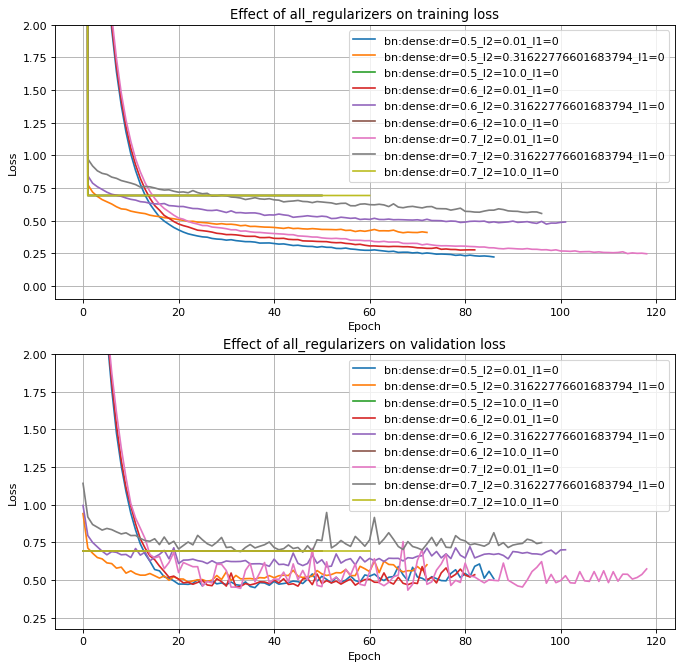

<Figure size 432x288 with 0 Axes>

In [31]:
ml_utils.plot_loss_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_loss', ylim_right=2)

#### Accuracy

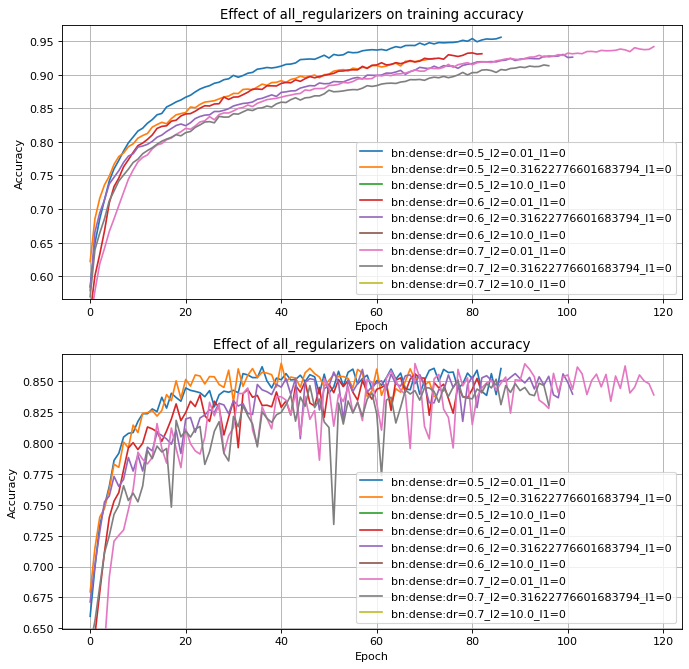

<Figure size 432x288 with 0 Axes>

In [32]:
ml_utils.plot_accuracies_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_accuracy')

#### Generalization Gap

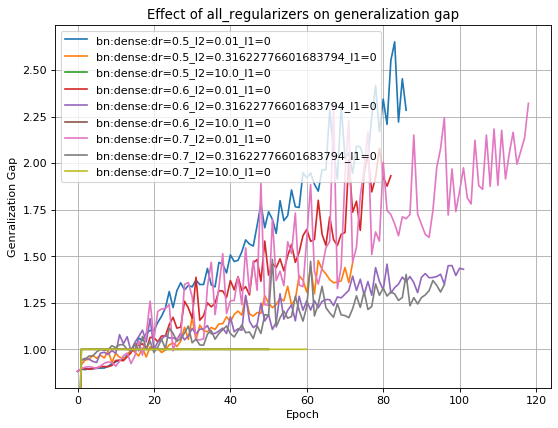

In [33]:
ml_utils.plot_generalization_gap_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_gen_gap', 5)

#### Weight Visualization

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0.4_l2=0_l1=0, Max Weight: 0.14278064668178558, Min Weight: 0.14278064668178558
Model: dense:dr=0_l2=0.01_l1=0, Max Weight: 0.070401132106781, Min Weight: 0.070401132106781
Model: dense:dr=0_l2=0_l1=0.001, Max Weight: 0.6767701506614685, Min Weight: 0.6767701506614685
Model: bn:dense:dr=0.5_l2=0.01_l1=0, Max Weight: 0.02868460677564144, Min Weight: 0.02868460677564144


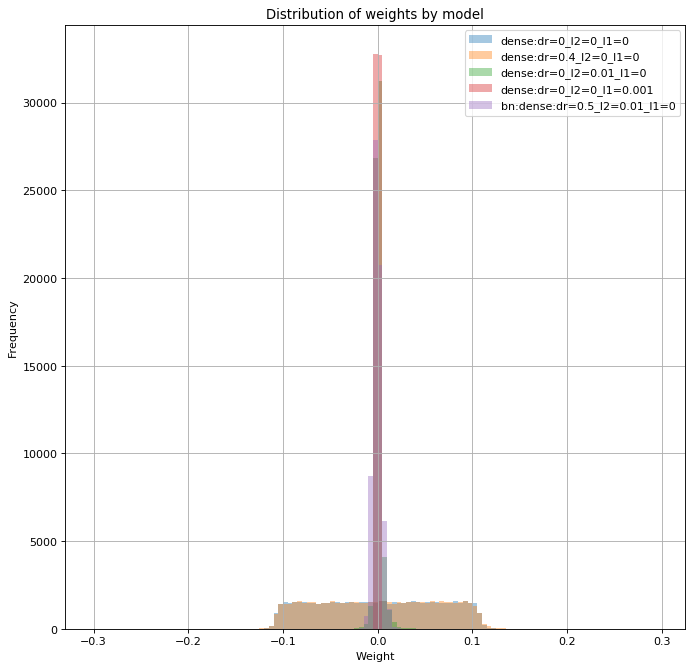

In [144]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0', 
    'dense:dr=0.4_l2=0_l1=0', 
    'dense:dr=0_l2=0.01_l1=0', 
    'dense:dr=0_l2=0_l1=0.001', 
    'bn:dense:dr=0.5_l2=0.01_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_all_regularizers')

#### Activation Visualization

In [135]:
summarize_activations(stats_by_regularizer, all_regularizers, np_sample_batch)

Stats for bn:dense:dr=0.5_l2=0.01_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f20108ed0>
Non-zero Activations L(n-1): 90.84375, Average Activation L(n-1): 50.16057586669922
Non-zero Activations Ln: 130.4375, Average Activation Ln: 25.948408126831055

*********************************************************************

Stats for bn:dense:dr=0.5_l2=0.31622776601683794_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f2011e390>
Non-zero Activations L(n-1): 49.21875, Average Activation L(n-1): 21.637069702148438
Non-zero Activations Ln: 129.0625, Average Activation Ln: 9.267204284667969

*********************************************************************

Stats for bn:dense:dr=0.5_l2=10.0_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f20075810>
Non-zero Activations L(n-1): 38.65625, Average Activation L(n-1): 6.845478555713744e-26
Non-zero Activations Ln: 0.0, Average Activation Ln: 0.0

**********************************************

## Appendix

Type: dr=0_l2=0_l1=0, non-zero Activations: 107.875, Average Activation: 31.580801010131836
Type: dense:dr=0.2_l2=0_l1=0, non-zero Activations: 101.4375, Average Activation: 43.295108795166016
Type: dense:dr=0.4_l2=0_l1=0, non-zero Activations: 71.96875, Average Activation: 121.11151123046875
Type: dense:dr=0.5_l2=0_l1=0, non-zero Activations: 49.6875, Average Activation: 88.51631164550781


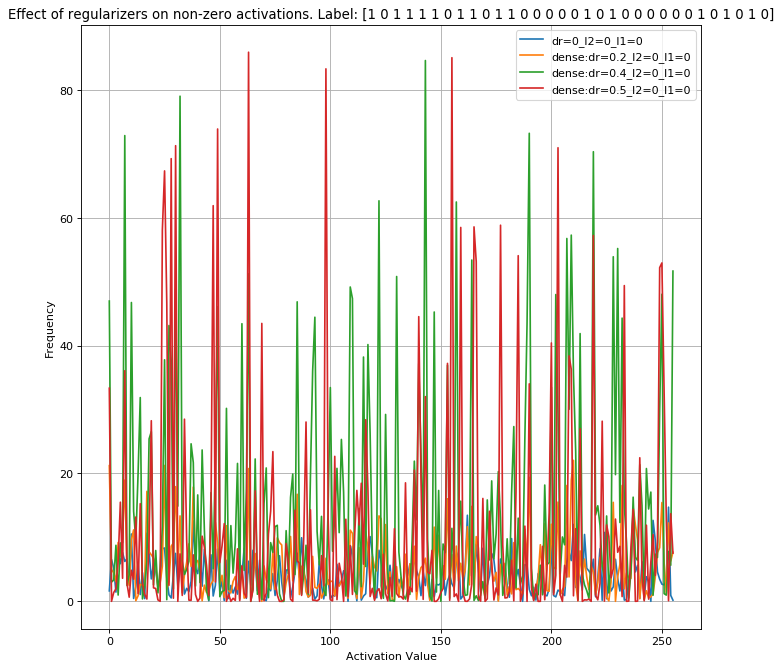

In [24]:
plt.figure(figsize=(10, 10), dpi=80)
bins=[0.1*a + 0.1 for a in range(200)]
non_zero_activation_16_dropout=np.zeros(256)
non_zero_activation_16_no_dropout=np.zeros(256)
non_zero_activation_18_dropout=np.zeros(256)
non_zero_activation_18_no_dropout=np.zeros(256)

for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
    if typ=='dr=0_l2=0.001_l1=0':
        continue
    activation_sum = np.sum(activation_18, axis=0)
    non_zero_activations = np.average(np.sum(activation_18>0, axis=1))
    average_activation = np.average(np.sum(activation_18, axis=1))
    print('Type: {typ}, non-zero Activations: {non_zero_activations}, Average Activation: {average_activation}'.
          format(typ=typ, non_zero_activations=non_zero_activations, average_activation=average_activation))
    plt.plot(range(256), activation_sum, label=str(typ))
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Effect of {param_name} on non-zero activations. Label: {label}'.format(
        param_name='regularizers',
        label=label
    ))

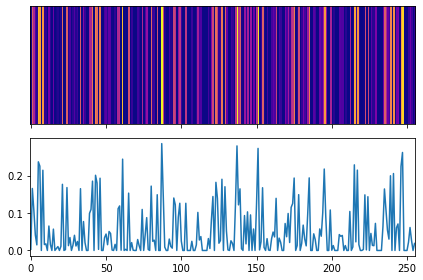

In [64]:
x = range(256)
y = activation_18[0]

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

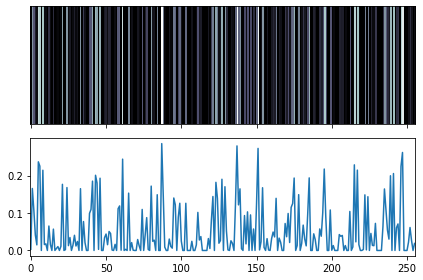

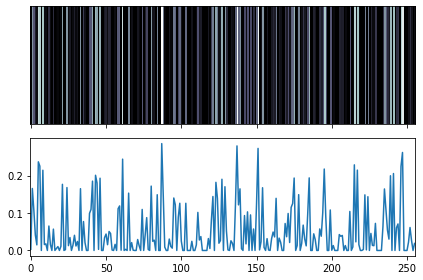

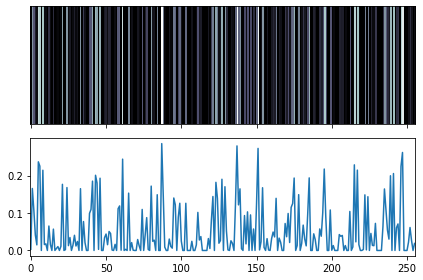

In [66]:
plt.figure()
x = range(256)

for i in range(1):
    for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
        fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)
        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        ax.imshow(y[np.newaxis,:], cmap=plt.cm.bone, aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        ax2.plot(x,y)

        plt.tight_layout()
        plt.show()

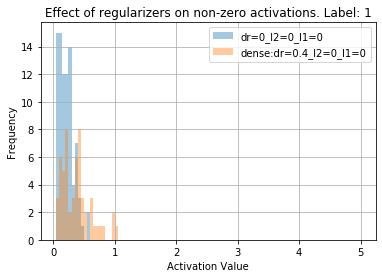

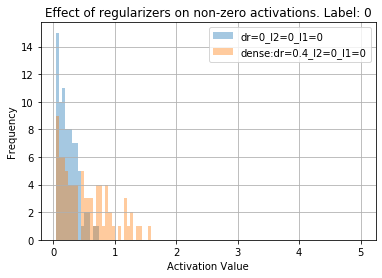

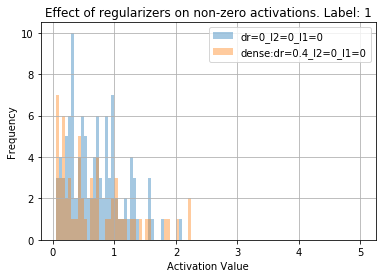

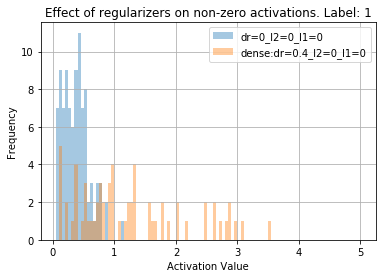

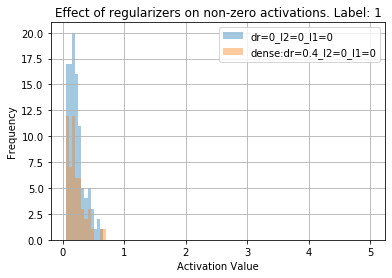

In [60]:
plt.figure()
#plt.title('Effect of {param_name} on non-zero activations'.format(param_name='regularizers'))
bins=[0.05*a + 0.05 for a in range(100)]

for i in range(5):
    for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
        if typ=='dr=0_l2=0.001_l1=0':
            continue
        sns.distplot(activation_18[i], label=str(typ), kde=False, bins=bins)
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.legend(loc='best')
        plt.title('Effect of {param_name} on non-zero activations. Label: {label}'.format(
            param_name='regularizers',
            label=label[i]
        ))
    
    plt.show()